In [1]:
import networkx as nx
import json
from networkx.algorithms import bipartite
from itertools import chain
import re
from collections import defaultdict
from Graph_Helpers import *
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
result_folder = 'Derived_Data/Spice2Phytochemical2Disease/'

file = 'PHYTOCHEMICALS/spiceherb_phy.json'
file_nonzero = 'PHYTOCHEMICALS/spiceherb_phy_nonzeroactivity.json'
spice2phyto = json2dict(file)
spice2phyto_nonzero = json2dict(file_nonzero)
print(len(spice2phyto))
print(len(spice2phyto_nonzero))


756
751


In [3]:
def process_name_spice(s):
    return ' '.join(s.lower().split()).capitalize()

In [4]:
import collections
spice2phyto_nonzero_copy = spice2phyto_nonzero.copy()
spice_nonzero = list(spice2phyto_nonzero.keys())
spice_lower = [s.lower().replace(' ','') for s in spice_nonzero]
spice_dupli = [item for item, count in collections.Counter(spice_lower).items() if count > 1]
spice_dupli_pairs = []
print(spice_dupli)
for k in range(len(spice_nonzero)):
    spice_name = spice_nonzero[k]
    # remove duplicate spices
    if spice_lower[k] in spice_dupli:
        # get all idxs of the duplicates
        dupli_idxs = [i for i, s in enumerate(spice_lower) if s == spice_lower[k]]
        dupli_pair = [process_name_spice(spice_nonzero[i]) for i in dupli_idxs]
        if dupli_pair not in spice_dupli_pairs:
            print(dupli_pair)
            spice_dupli_pairs.append(dupli_pair)
        # use the intersection of all duplicates as the new phyto list
        phytos_overlap = list(set([phyto for l in [spice2phyto_nonzero_copy[spice_nonzero[i]] for i in dupli_idxs] for phyto in l]))
        for i in dupli_idxs:
            if spice_nonzero[i] in spice2phyto_nonzero:
                # remove duplicate
                del spice2phyto_nonzero[spice_nonzero[i]]
                # update spice2phyto
                spice2phyto_nonzero[process_name_spice(spice_name)] = phytos_overlap
    else:
        # rename spice
        spice2phyto_nonzero[process_name_spice(spice_name)] = spice2phyto_nonzero.pop(spice_name)


['canereed', 'tonkabean', 'staranise', 'curryleaf', 'brazilianpeppertree', 'ethiopianpepper']
['Cane reed', 'Cane reed']
['Tonka bean', 'Tonka bean']
['Star anise', 'Star anise']
['Curry leaf', 'Curryleaf']
['Brazilian pepper tree', 'Brazilian peppertree']
['Ethiopian pepper', 'Ethiopian pepper']


In [5]:
spice_dupli_pairs

[['Cane reed', 'Cane reed'],
 ['Tonka bean', 'Tonka bean'],
 ['Star anise', 'Star anise'],
 ['Curry leaf', 'Curryleaf'],
 ['Brazilian pepper tree', 'Brazilian peppertree'],
 ['Ethiopian pepper', 'Ethiopian pepper']]

In [6]:
spice_dupli_extras = [['Grains-of-paradise', 'Grains of paradise'],
                      ['Cloves', 'Clove'],
                      ['Cardamom', 'Cardamon']]
for spice_pair in spice_dupli_extras:
    if spice_pair[1] in spice2phyto_nonzero:
        phytos_overlap = list(set(spice2phyto_nonzero[spice_pair[0]]).intersection(set(spice2phyto_nonzero[spice_pair[1]])))
        spice2phyto_nonzero[spice_pair[0]] = phytos_overlap
        del spice2phyto_nonzero[spice_pair[1]]


In [7]:
spice_dupli_pairs.extend(spice_dupli_extras)
print(spice_dupli_pairs)

[['Cane reed', 'Cane reed'], ['Tonka bean', 'Tonka bean'], ['Star anise', 'Star anise'], ['Curry leaf', 'Curryleaf'], ['Brazilian pepper tree', 'Brazilian peppertree'], ['Ethiopian pepper', 'Ethiopian pepper'], ['Grains-of-paradise', 'Grains of paradise'], ['Cloves', 'Clove'], ['Cardamom', 'Cardamon']]


In [8]:
dict2json(spice2phyto_nonzero, result_folder+'spice2phyto_nonzero.json')

In [9]:
Bi_spice2phyto, spice2phyto_top, spice2phyto_bot = Bipartite_graph(spice2phyto, ['spice', 'phytochemical'])
Bi_spice2phyto_nonzero, spice2phyto_nonzero_top, spice2phyto_nonzero_bot = Bipartite_graph(spice2phyto_nonzero, ['spice', 'nonzero-phytochemical'])


Total spice(top):  756
Total phytochemical(bot):  20854
Total spice(top):  742
Total nonzero-phytochemical(bot):  2993


### Generate Spice2Indic_phytononzero ###

In [10]:
# combine spice2info from both handbooks
spice2info_herbhnd = json2dict('PHYTOCHEMICALS/spice2info_herbhnd.json')
spice2info_spicehnd = json2dict('PHYTOCHEMICALS/spice2info_spicehnd.json')

spice2info = spice2info_herbhnd.copy()
spice2info.update(spice2info_spicehnd)
spice2indic = {}
spice2indic2score = {}
spice2indic_all = {}

for spice in spice2info.keys():
    if spice in spice2phyto_nonzero.keys():
        spice2indic.update({spice : list(spice2info[spice]['indication2score'].keys())})
        spice2indic2score.update({spice : spice2info[spice]['indication2score']})
    #print(len(spice2indic))
    spice2indic_all.update({spice : list(spice2info[spice]['indication2score'].keys())})
print(len(spice2indic2score))
dict2json(spice2indic, result_folder + 'spice2indic_phytononzero.json' )
dict2json(spice2indic2score, result_folder + 'spice2indic2score_phytononzero.json' )
dict2json(spice2indic_all, result_folder + 'spice2indic_all.json')

742


### Generate Indic2spice, Indic2spicecount (phyto nonzero) ###

In [11]:
indic2spice = reverse_dict(spice2indic)
indic2count = {}
for spice, indics in indic2spice.items():
    indic2count.update({spice : len(indics)})
dict2json(indic2count, result_folder + 'indic2spicecount_phytononzero.json')

In [12]:
# generate name_correction
import pandas as pd
import collections
indic_all = list(reverse_dict(spice2indic).keys())
indic_all_lower = [indic.lower() for indic in indic_all]
indic_all_map = dict(zip(indic_all_lower, indic_all))
indic_all_nospace_lower = [indic.replace(' ','') for indic in indic_all_lower]

indic_dupli = [item for item, count in collections.Counter(indic_all_nospace_lower).items() if count > 1]

orig2replace = {}
for indic in indic_dupli:
    idxs = [i for i in range(len(indic_all)) if indic_all_nospace_lower[i] == indic]
    replace = [indic_all[idx] for idx in idxs if ' ' not in indic_all[idx]][0]
    for idx in idxs:
        name = indic_all[idx]
        if name != replace:
            orig2replace.update({name: replace})

print(orig2replace)
orig2replace_df = pd.DataFrame(orig2replace.items(), columns=['orig', 'replace'])
orig2replace_df.to_excel(result_folder+ 'name_correction_extra.xlsx')

{}


In [13]:
dict2json(indic_all, result_folder + 'indic_all.json')
print("Total # of indication (751 spices): ", len(indic_all))

Total # of indication (751 spices):  1327


In [14]:
phyto2spice = reverse_dict(spice2phyto_nonzero)
phyto_onespice = []
for phyto, spices in phyto2spice.items():
    if len(spices) < 2:
        phyto_onespice.append(phyto)
print(len(phyto_onespice)) # out of 2994 phytochemicals, 1390 are present in only 1 spice. 

1406


### Find phyto candidates for each indication ###
for each pair of spices, their overlapping phytochemicals are the potential candidates for all their overlapping indications

In [15]:
print(len(spice2indic))
print(len(spice2phyto_nonzero))

742
742


### Find phyto2spicecount {phyto : # spices} ###

In [16]:
from collections import OrderedDict
from operator import itemgetter    

phyto2spice = reverse_dict(spice2phyto_nonzero)
phyto2spicecount = {}
for phyto, spices in phyto2spice.items():
    phyto2spicecount[phyto] = len(spices)
phyto2spicecount = OrderedDict(sorted(phyto2spicecount.items(), key = itemgetter(1), reverse = True))
list(phyto2spicecount.keys())[:20]

['CALCIUM',
 'IRON',
 'BETA-SITOSTEROL',
 'PHOSPHORUS',
 'POTASSIUM',
 'FIBER',
 'ASCORBIC-ACID',
 'SODIUM',
 'MAGNESIUM',
 'MANGANESE',
 'ZINC',
 'PALMITIC-ACID',
 'OLEIC-ACID',
 'BETA-CAROTENE',
 'RIBOFLAVIN',
 'TANNIN',
 'LINOLEIC-ACID',
 'NIACIN',
 'THIAMIN',
 'STEARIC-ACID']

## indication2phytochemical mapping with confidence score ##

### METHOD 1 ###
pairwise find overlapping phytos and indications, and link all of them

In [17]:
# pairwise spice - find overlapping indic and phyto
indic2phyto2score = {}  # raw score based on count
spices = list(spice2phyto_nonzero.keys())
for i in range(len(spices) - 1):
    for j in range(i + 1, len(spices) - 1):
        indic_overlap = set(spice2indic[spices[i]]).intersection(set(spice2indic[spices[j]]))
        phyto_overlap = set(spice2phyto_nonzero[spices[i]]).intersection(set(spice2phyto_nonzero[spices[j]]))
        for indic in indic_overlap:
            if indic not in indic2phyto2score:
                indic2phyto2score.update({indic : {}})
            for phyto in phyto_overlap:
                if phyto not in indic2phyto2score[indic]:
                    indic2phyto2score[indic][phyto] = 1  
                else:
                    indic2phyto2score[indic][phyto] += 1

In [18]:
# sorted 
indic2phyto2score_pairwise = {}
for indic, phyto2score in indic2phyto2score.items():
    indic2phyto2score_pairwise[indic] = {k: v for k, v in sorted(phyto2score.items(), key=lambda item: item[1], reverse=False)}
dict2json(indic2phyto2score_pairwise, result_folder+ 'indic2phyto2score_pairwise.json')

### Spec score (i, p) = (#spices related to this indication i that contain phyto p)/ (#spices related indication i) * (#spices related to phyto p) ###
phyto - spice - indication 


In [19]:
from collections import Counter
indic2spice = reverse_dict(spice2indic)
indic2phyto2score_all = {}
indic2phyto2score_all_normalized = {}
phyto2indic2score_all_normalized = {}
for indic, spices in indic2spice.items():
    if indic in indic2phyto2score:
        phyto_list = []
        for s in spices:
            phyto_list.extend(spice2phyto_nonzero[s])
        # count_dict = {phyto: #spices related to this indication that contain this phyto} sorted by count of phyto 
        count_dict = {k: v for k, v in sorted(Counter(phyto_list).items(), key=lambda item: item[1], reverse=True)}
        exclude_phytos = []
        phytos = list(count_dict.keys())
        c = 0
        for phyto in phytos:
            if phyto not in indic2phyto2score[indic].keys(): # only retain link appeared in pairwise method 1
                count_dict.pop(phyto)
                c += 1
        count_dict_copy = count_dict.copy()
        indic2phyto2score_all.update({indic : count_dict_copy})
        for phyto in count_dict.keys():
            spec_score = round(count_dict[phyto]/(phyto2spicecount[phyto] * indic2count[indic]),6) # normalize specificity score
            count_dict[phyto] = spec_score
            if phyto not in phyto2indic2score_all_normalized:
                phyto2indic2score_all_normalized[phyto] = {}
            phyto2indic2score_all_normalized[phyto].update({indic: spec_score})
        count_dict = {k: v for k, v in sorted(count_dict.items(), key=lambda item: item[1], reverse=True)}
        indic2phyto2score_all_normalized.update({indic : count_dict})
        
for phyto, indic2spec in phyto2indic2score_all_normalized.items():
    phyto2indic2score_all_normalized[phyto] = {k : v for k, v in sorted(indic2spec.items(), key=lambda item:item[1], reverse=True)}

dict2json(indic2phyto2score_all, result_folder+ 'indic2phyto2score_skiplayer_filtered.json')
dict2json(indic2phyto2score_all_normalized, result_folder+ 'indic2phyto2score_skiplayer_filtered_normalized.json')
dict2json(phyto2indic2score_all_normalized, result_folder+ 'phyto2indic2score_skiplayer_filtered_normalized.json')

1. for each pair of spices, find overlapping indics and phytos
2. for each phytos, only include the indications that appear in all pairwise comparison for that phyto
3. reverse dict to get indic2phyto
4. use the score from method 2 to generate indic2phyto2score

In [20]:
# pairwise spices - connect overlapping indication and phyto
# pairwise: phyto2indic and phyto2excludeindic
spices = list(spice2phyto_nonzero.keys())
phyto2indic_pairwise = {}
for i in range(len(spices) - 1):
    for j in range(i + 1, len(spices) - 1):
        indic_overlap = set(spice2indic[spices[i]]).intersection(set(spice2indic[spices[j]]))
        phyto_overlap = set(spice2phyto_nonzero[spices[i]]).intersection(set(spice2phyto_nonzero[spices[j]])) 
        for phyto in phyto_overlap:
            if phyto not in phyto2indic_pairwise:
                phyto2indic_pairwise[phyto] = list(indic_overlap)
            else:
                phyto2indic_pairwise[phyto] = list(indic_overlap.intersection(set(phyto2indic_pairwise[phyto])))
dict2json(phyto2indic_pairwise, result_folder+ 'phyto2indic_pairwise.json')

In [21]:
# USED IN THE MANUSCRIPT
# generate indic2phyto_score & specificity index based on indic2phyto2score_pairwise_filtered
# only retain the phytos found in indic2phyto2score_pairwise in method 1 
indic2phyto_pairwise = reverse_dict(phyto2indic_pairwise)
indic2phyto2score_pairwise_filtered = {}
indic2phyto2specificity_pairwise_filtered = {}
for indic, phytos in indic2phyto2score_pairwise.items():  # only retain pairs found in method 1 (pairwise spice)
    phyto2score = {}
    phyto2spec = {}
    for phyto in phytos:
        # spec score: use skip layer score (not one from pairwise spice)
        phyto2score[phyto] = indic2phyto2score_all[indic][phyto]  # use the skip layer count in method 2 as score
        phyto2spec[phyto] = round(indic2phyto2score_all[indic][phyto] / (phyto2spicecount[phyto] * indic2count[indic]), 6)

    phyto2score = {k : v for k, v in sorted(phyto2score.items(), key=lambda item:item[1], reverse=True)}
    phyto2spec = {k : v for k, v in sorted(phyto2spec.items(), key=lambda item:item[1], reverse=True)}
    if any(score > 1 for score in list(phyto2score.values())):
        indic2phyto2score_pairwise_filtered.update({indic: phyto2score})
        indic2phyto2specificity_pairwise_filtered.update({indic: phyto2spec})
dict2json(indic2phyto2score_pairwise_filtered, result_folder + 'indic2phyto_rawscore_pairwise_filtered.json')
dict2json(indic2phyto2specificity_pairwise_filtered, result_folder + 'indic2phyto_specificity_pairwise_filtered.json')

## generate phyto2indic_score & specificity index based on indic2phyto2score_pairwise_filtered

In [22]:
phyto2indic2score_pairwise_filtered = {}
phyto2indic2specificity_pairwise_filtered = {}
for indic, phyto2score in indic2phyto2score_pairwise_filtered.items():
    for phyto in phyto2score.keys():
        if phyto not in phyto2indic2score_pairwise_filtered:
            phyto2indic2score_pairwise_filtered[phyto] = {}
            phyto2indic2specificity_pairwise_filtered[phyto] = {}
        phyto2indic2score_pairwise_filtered[phyto][indic] = indic2phyto2score_pairwise_filtered[indic][phyto]
        phyto2indic2specificity_pairwise_filtered[phyto][indic] = indic2phyto2specificity_pairwise_filtered[indic][phyto]

def dict_sortbyscore(d):
    d_new = {}
    for key, val2score in d.items():
        d_new[key] = {k : v for k, v in sorted(val2score.items(), key=lambda item:item[1], reverse=True)}
    return d_new

# for phyto, indic2score in phyto2indic2score_pairwise_filtered.items():
#     phyto2indic2score_pairwise_filtered[phyto] = {k : v for k, v in sorted(indic2score.items(), key=lambda item:item[1], reverse=True)}

# for phyto, indic2spec in phyto2indic2specificity_pairwise_filtered.items():
#     phyto2indic2specificity_pairwise_filtered[phyto] = {k : v for k, v in sorted(indic2spec.items(), key=lambda item:item[1], reverse=True)}
phyto2indic2score_pairwise_filtered = dict_sortbyscore(phyto2indic2score_pairwise_filtered)
phyto2indic2specificity_pairwise_filtered = dict_sortbyscore(phyto2indic2specificity_pairwise_filtered)
dict2json(phyto2indic2score_pairwise_filtered, result_folder+ 'phyto2indic_rawscore_pairwise_filtered.json')
dict2json(phyto2indic2specificity_pairwise_filtered, result_folder+ 'phyto2indic_specificity_pairwise_filtered.json')

## Find phytos with high specificity for each indication


In [23]:
import operator
def find_topspec_phyto(num_phyto, indic2phyto2spec, phyto2indic2spec, top_k): 
    '''
    args:
        num_phyto: max number of phytos appear in heatmap
        indic2phyto2spec: indic2phyto2specificityscore sorted
        phyto2indic2spec: phyto2indic2specificityscore sorted
    return:
        phyto_select: selected phyto with high specificity and broad association with indications
        phyto2indic_select: subset of phyto2indic based on phytoselect
        
    '''
    phyto_topspec_list = []
    indic2phyto_topspec = {}
    #for indic, phyto2score in indic2phyto2specificity_pairwise_filtered.items():
    for indic, phyto2score in indic2phyto2spec.items():
        if phyto2score:
            #maxspec = max(phyto2score.values())
            #phyto_maxspec = [k for k,v in phyto2score.items() if v == maxspec]  # find all phyto with that max value for the indication
            if len(phyto2score) > top_k:
                phyto_topspec = list(phyto2score.keys())[:top_k]
            else:
                phyto_topspec = list(phyto2score.keys())
            indic2phyto_topspec[indic] = phyto_topspec  
            phyto_topspec_list.extend(phyto_topspec)
    # select phytos that's not only has max specificity score for at least one indication + has top most associations with indications
    phyto_topspec_select = set(phyto_topspec_list)
    phyto2indic_topspec = reverse_dict(indic2phyto_topspec)
    phyto2sumspec = {}
    for phyto in phyto_topspec_select:
        sumspec = 0
        # either the entire indic2phyto or indic2phyto_topspec   ????
        for indic in phyto2indic_topspec[phyto]:
            sumspec += indic2phyto2spec[indic][phyto]
            #sumspec += 1
        phyto2sumspec[phyto] = sumspec
    phyto2sumspec_sorted = sorted(phyto2sumspec.items(), key=operator.itemgetter(1), reverse=True)[:num_phyto]
    phyto_select = [phyto2score[0] for phyto2score in phyto2sumspec_sorted]
    phyto2indic_select = {}
    for phyto in phyto_select:
        phyto2indic_select[phyto] = list(phyto2indic2spec[phyto].keys())
    return phyto_select, phyto2indic_select

NUM_PHYTO = 40
TOP_K = 5
#phyto_select, phyto2indic_select = find_topspec_phyto(NUM_PHYTO, indic2phyto2score_all_normalized, phyto2indic2score_all_normalized, TOP_K)
phyto_select, phyto2indic_select = find_topspec_phyto(NUM_PHYTO, indic2phyto2specificity_pairwise_filtered, phyto2indic2specificity_pairwise_filtered, TOP_K)

print(phyto_select)

['DIHYDROCAPSAICIN', 'VANILLYL-AMINE', 'CAPSORUBIN', 'CAPSIDIOL', 'CAPSAICIN', 'ALLICIN', 'PROSTAGLANDIN-A-1', 'ALLYL-METHYL-DISULFIDE', 'ALLYL-PROPYL-DISULFIDE', 'CYCLOALLIIN', '7BETA,12ALPHA-DIHYDROXYKAURENOLIDE', 'CUCURBIC-ACID', 'PERIPLOCYMARIN', 'HYDRASTINE', 'DIANETHOLE', 'POTASSIUM-BITARTRATE', 'OLEANOLIC-ACID-METHYL-ESTER', 'GITOXIN', 'DIGITOXIN', 'PTEROSTILBENE', 'SULFORAPHANE', 'INDOLE-3-CARBINOL', 'FORMONONETIN', 'CUCURBITIN', 'TETRAMETHYL-PYRAZINE', 'STROPHANTHIDIN', 'CYMAROL', 'GLUCOSAMINE', 'P-ANISALDEHYDE', '3-PHENYL-PROPYL-ACETATE', 'CUCURBITACIN-D', 'O-METHOXYCINNAMALDEHYDE', 'ANTHOCYANIDINS', 'EPSILON-VINIFERIN', 'PHENETHYL-ISOTHIOCYANATE', 'VIOLIN', 'GALANTHAMINE', 'APOATROPINE', 'CAROTATOXIN', 'EUGENIN']


## Find indications associated with the max specificity phytochemical 


In [24]:

def find_topspec_indic(num_indic, phyto2indic_select):  
    # based on selected phyto, find all related indications, sort by centrality
    indic_select = list(set(chain.from_iterable(phyto2indic_select.values())))
    print(len(indic_select))
    indic_centrality = pd.read_excel('NODEXL_PLOT_NEW/projgraph_spice_2indic/projgraph_indic_centrality_summary.xlsx')
    indic_rankedbycent = list(indic_centrality['Combined rank'])
    indic_select_ordered = []
    for indic in indic_rankedbycent:
        if indic in indic_select:
            indic_select_ordered.append(indic)
    if len(indic_select_ordered) >= num_indic:
        return indic_select_ordered[:num_indic]
    else:
        return indic_select_ordered
NUM_INDIC = 40
indic_select = find_topspec_indic(NUM_INDIC, phyto2indic_select)
print(indic_select)

354
['Fever', 'Cancer', 'Inflammation', 'Pain', 'Infection', 'Rheumatism', 'Gastrosis', 'Dermatosis', 'Cough', 'Sore', 'Water retention', 'Hepatosis', 'Cramp', 'Enterosis', 'Diarrhea', 'Bacteria', 'Bronchosis', 'Dyspepsia', 'Asthma', 'Cold', 'Headache', 'Wound', 'Arthrosis', 'Swelling', 'Dysmenorrhea', 'Nephrosis', 'Constipation', 'Fungus', 'Insomnia', 'Worm', 'Nervousness', 'Dysentery', 'Sore throat', 'Hemorrhoid', 'Tumor', 'Mycosis', 'Ophthalmia', 'Ulcer', 'High blood pressure', 'Catarrh']


In [25]:
pd.DataFrame(indic2phyto2score_all_normalized).loc[['VANILLYL-AMINE','VIOLIN'],['Amebiasis','Mycosis']]

Amebiasis  Mycosis
VANILLYL-AMINE        NaN      NaN
VIOLIN                NaN      NaN

(40, 40)


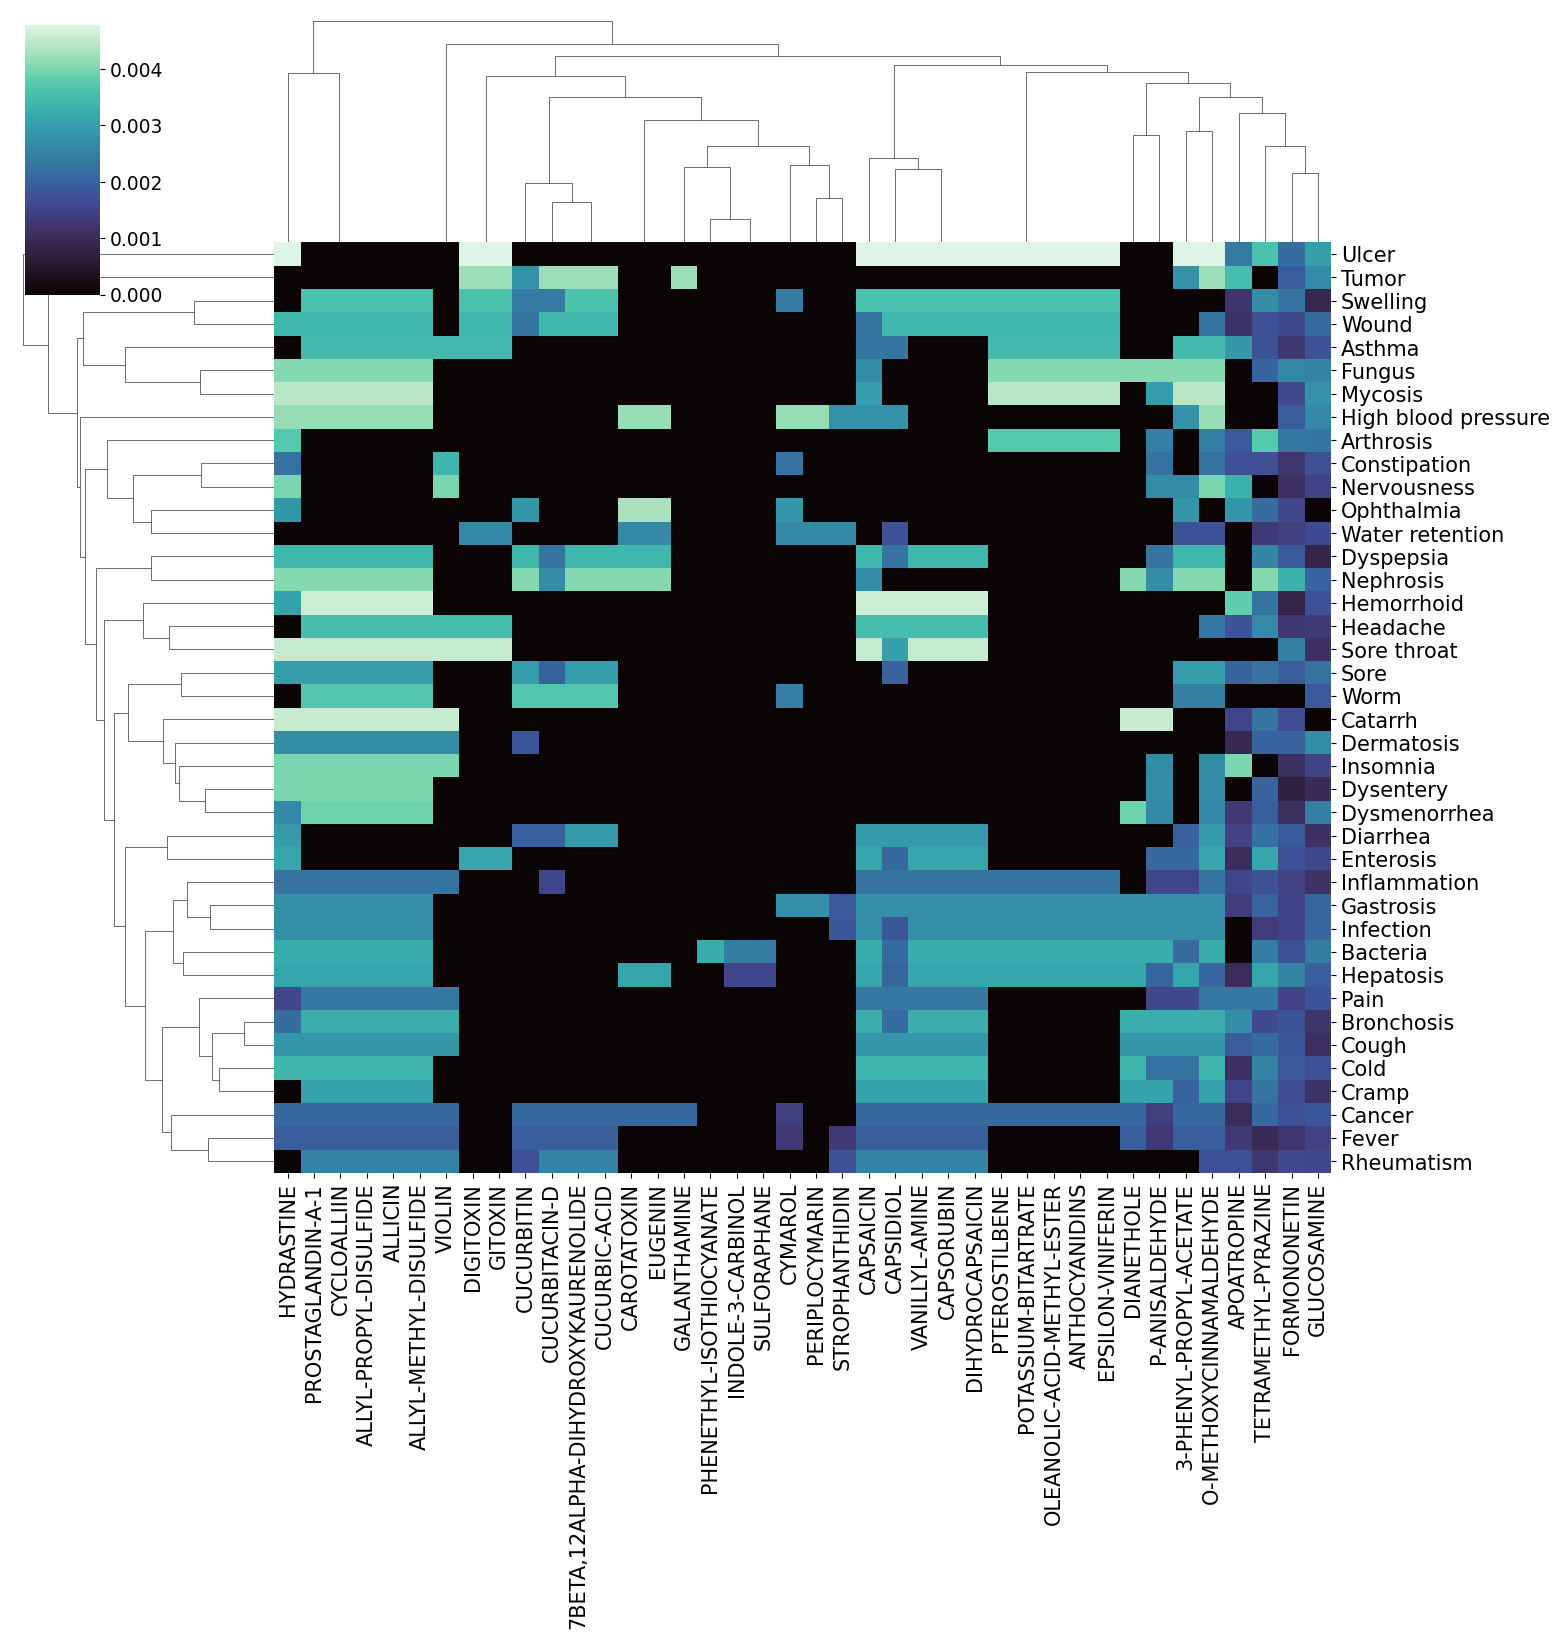

In [26]:
import seaborn as sns

def plot_indic2phyto_heatmap(indic2phyto2spec, indic_select, phyto_select):
    indicphyto2score = {}
    for indic in indic_select:
        for phyto in phyto_select:
            try:
                indicphyto2score[(indic, phyto)] = indic2phyto2spec[indic][phyto]
            except:
                indicphyto2score[(indic, phyto)] = 0.0000
    ser = pd.Series(list(indicphyto2score.values()),
                      index=pd.MultiIndex.from_tuples(indicphyto2score.keys()))
    df = ser.unstack().fillna(0) 
    print(df.shape)
    # cmap option: mako, rocket_r, 
    #df = pd.DataFrame(indic2phyto2spec).loc[[phyto_select], [indic_select]].fillna(0)
    if df.shape >= (2,2):
        g = sns.clustermap(df, cmap = 'mako', yticklabels=True, figsize=(15,15), xticklabels=True)
        g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 15)
        g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 15)
#plot_indic2phyto_heatmap(indic2phyto2score_all_normalized, indic_select, phyto_select)
        cbar = g.ax_heatmap.collections[0].colorbar
        cbar.ax.tick_params(labelsize=13.5)
plot_indic2phyto_heatmap(indic2phyto2specificity_pairwise_filtered, indic_select, phyto_select)
#plt.tight_layout()
plt.savefig(result_folder + 'heatmap_plots/pairwise_filtered/phyto2indic_heatmap.png', bbox_inches = "tight")

mental_disease
22
(20, 20)
musculoskeletal_disease 
18
(18, 20)
gastrointestinal_disease
36
(20, 20)
neuronal_disease
23
(20, 20)
infectious_disease
58
(20, 20)
respiratory_disease
27
(20, 20)
General symptom
38
(20, 20)
cancer_disease
30
(20, 20)
cardiovascular_disease
18
(18, 20)
nephrological_disease
20
(20, 20)
eye_disease
10
(10, 20)
poisoning
3
(3, 11)
blood_disease
7
(7, 20)
injury
11
(11, 20)
skin_disease
26
(20, 20)
endocrine_disease
7
(7, 20)
reproductive_disease
21
(20, 20)
ear_disease
5
(5, 20)
metabolic_disease
7
(7, 20)
immune_disease
9
(9, 20)
sleep_disease
2
(2, 10)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:715: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self._figure = plt.figure(figsize=figsize)


pregnancy_disease
6
(6, 20)
general_disease
5
(5, 20)
nutritional_disease
4
(4, 20)
oral_disease
2
(2, 10)
othercauses
3
(3, 10)
smell_taste_disease
2
(2, 10)


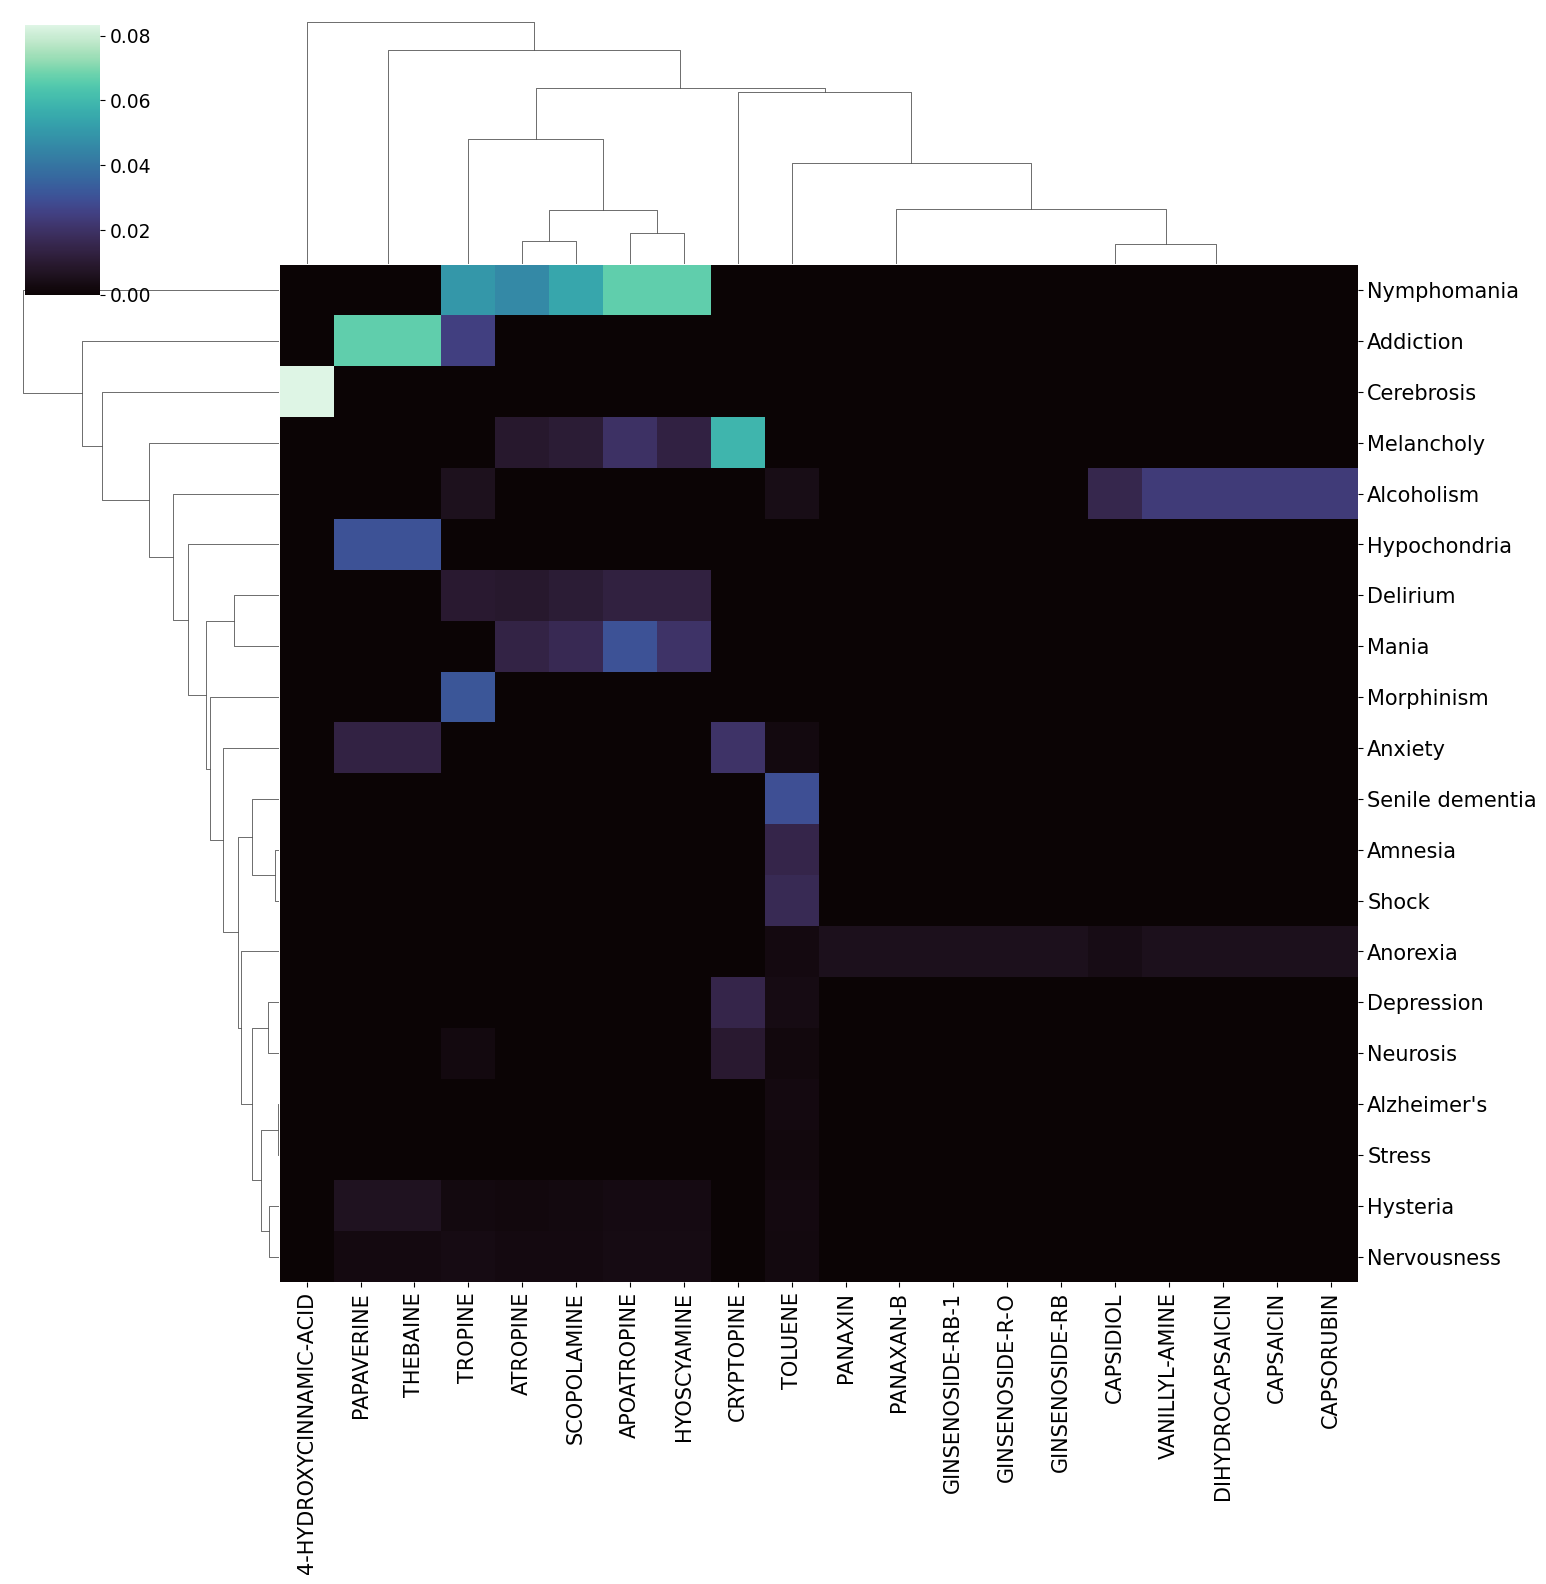

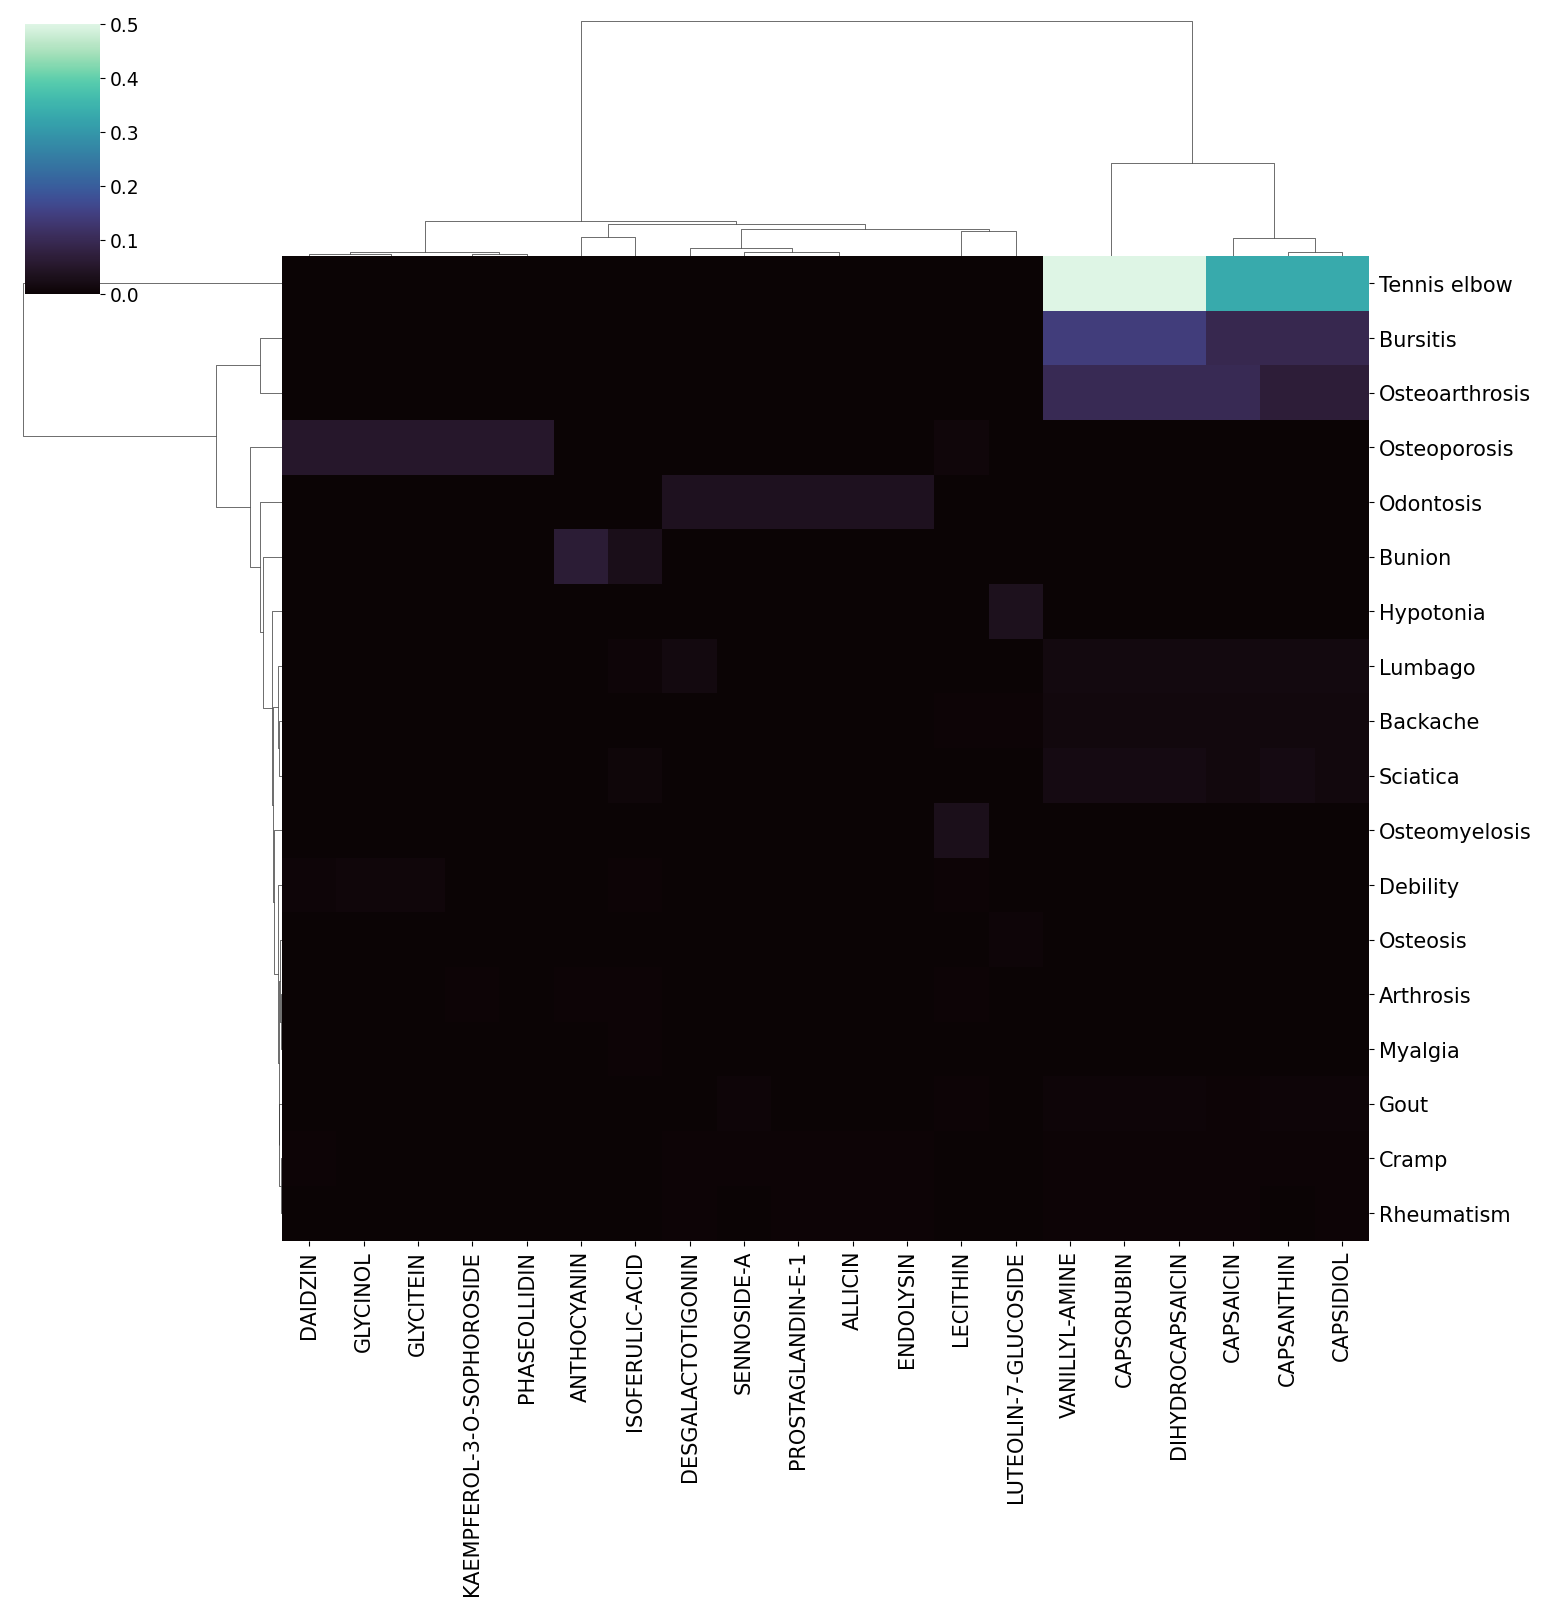

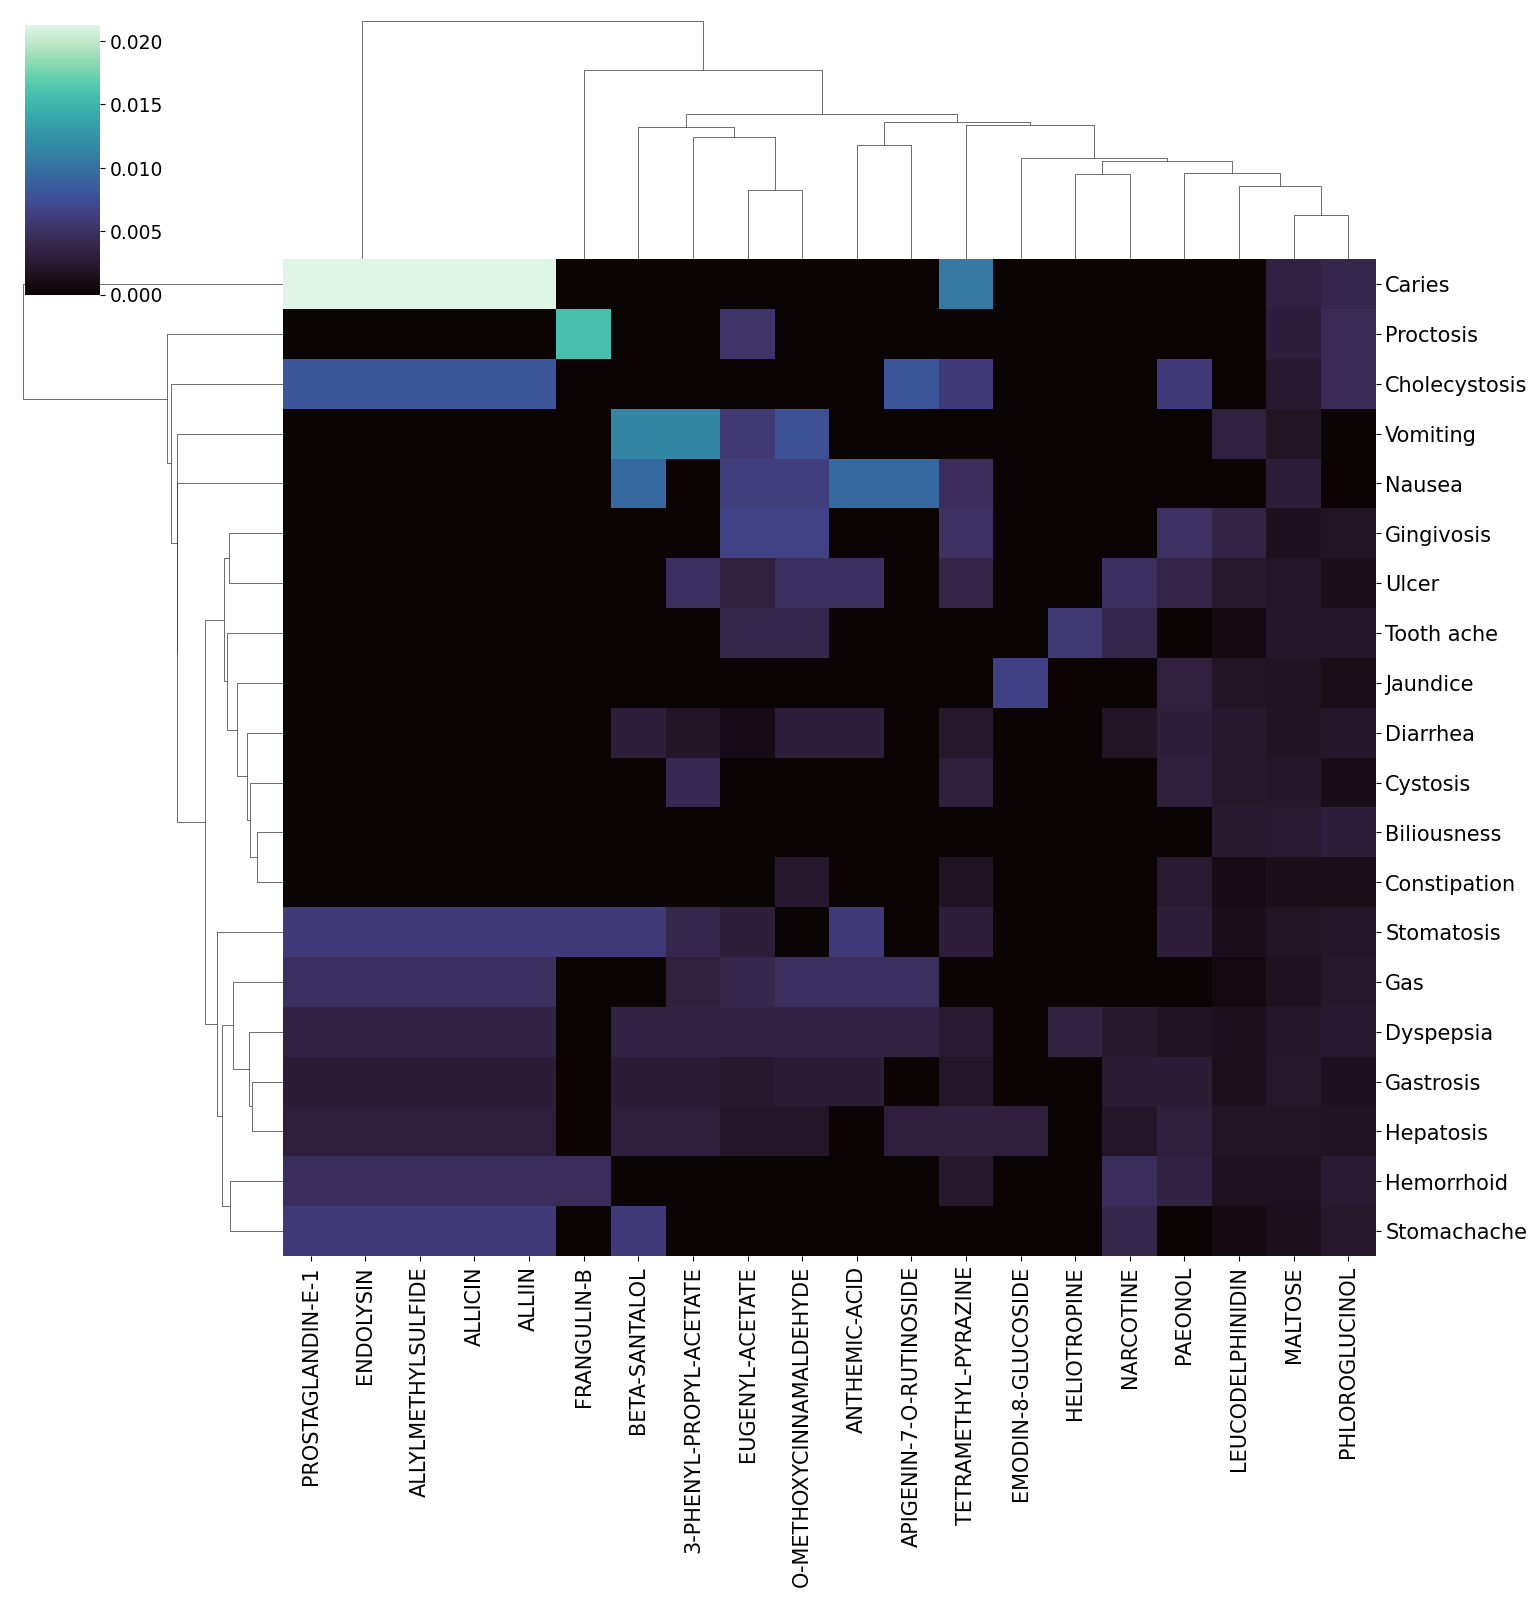

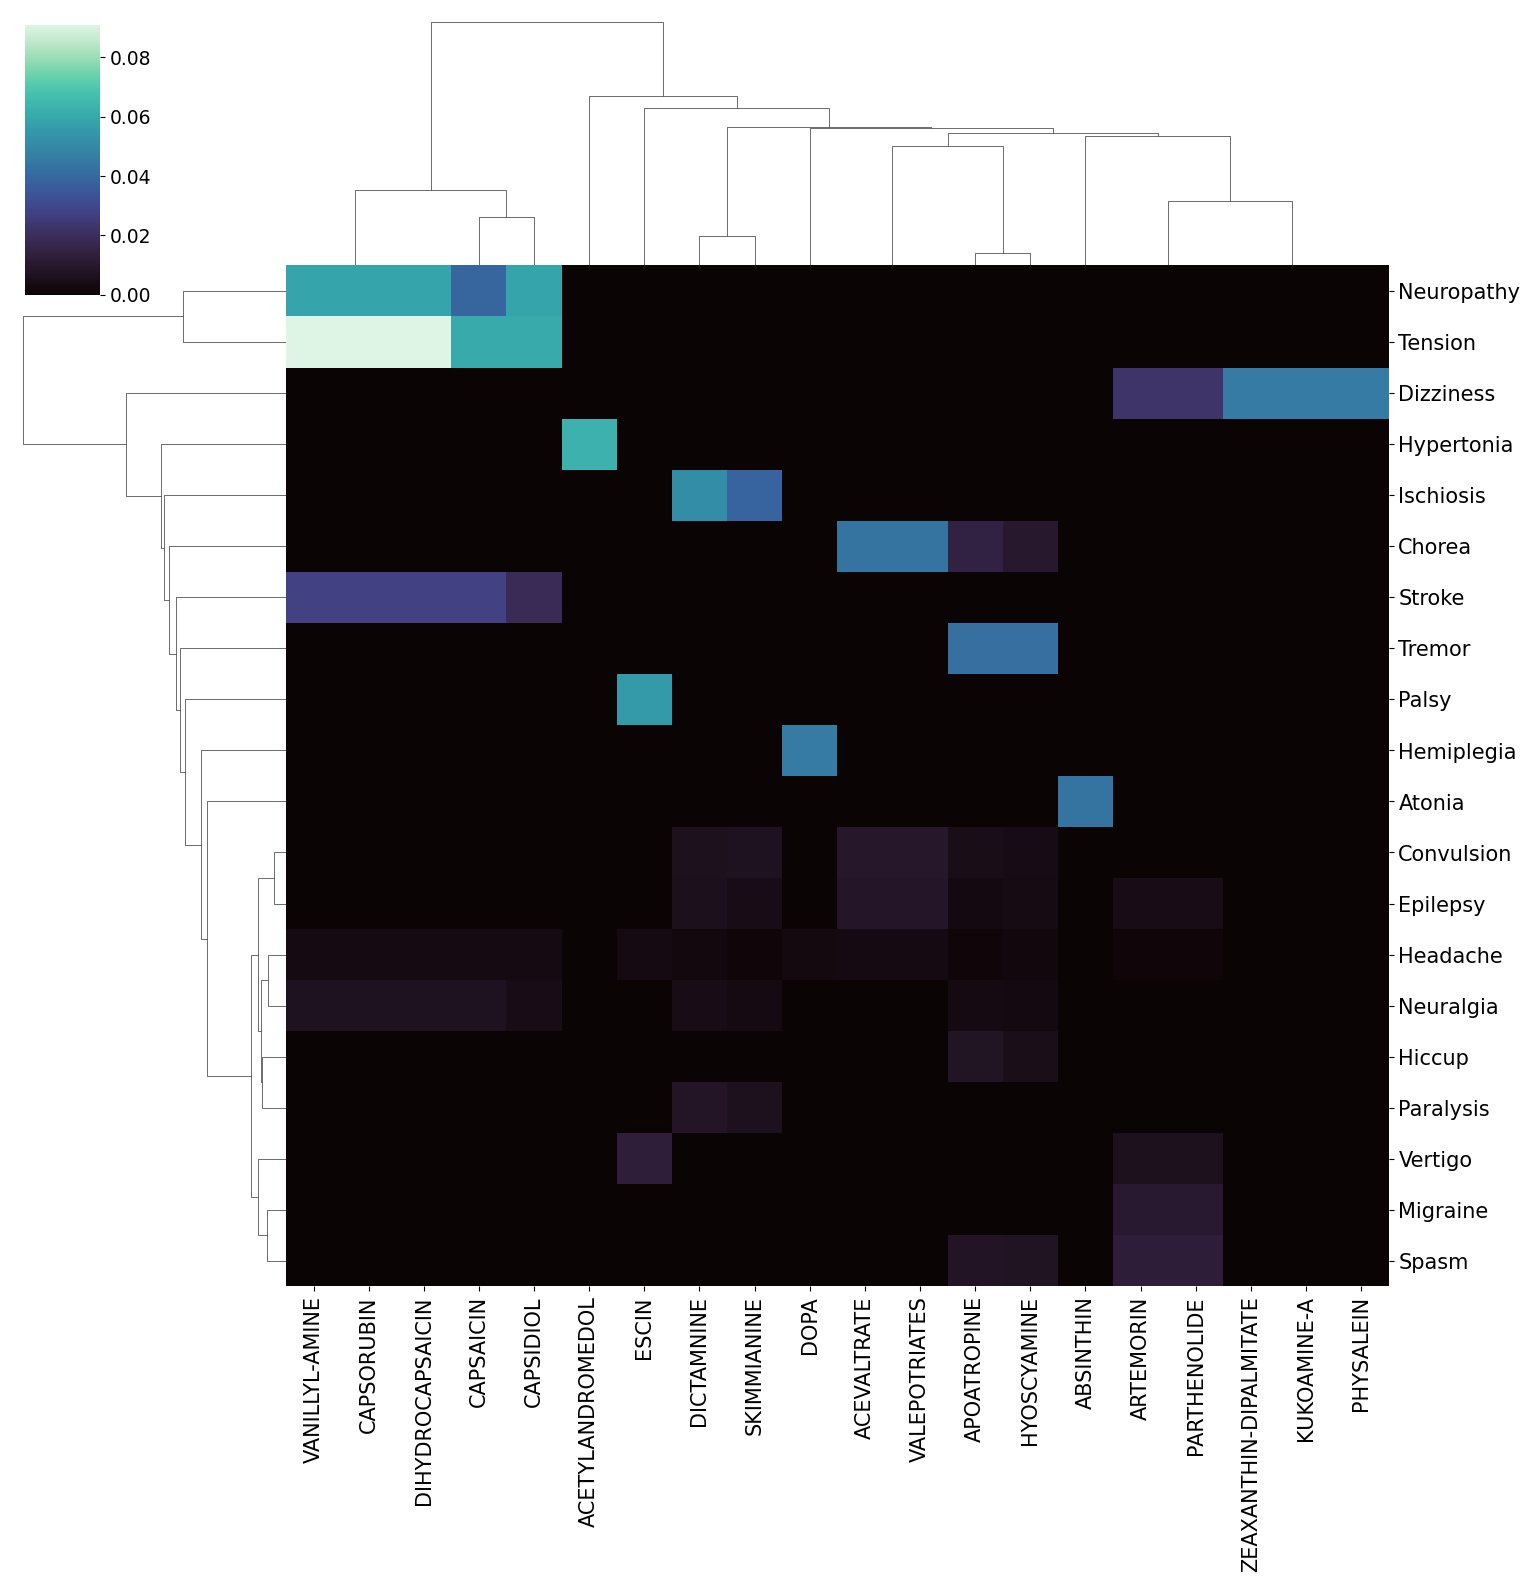

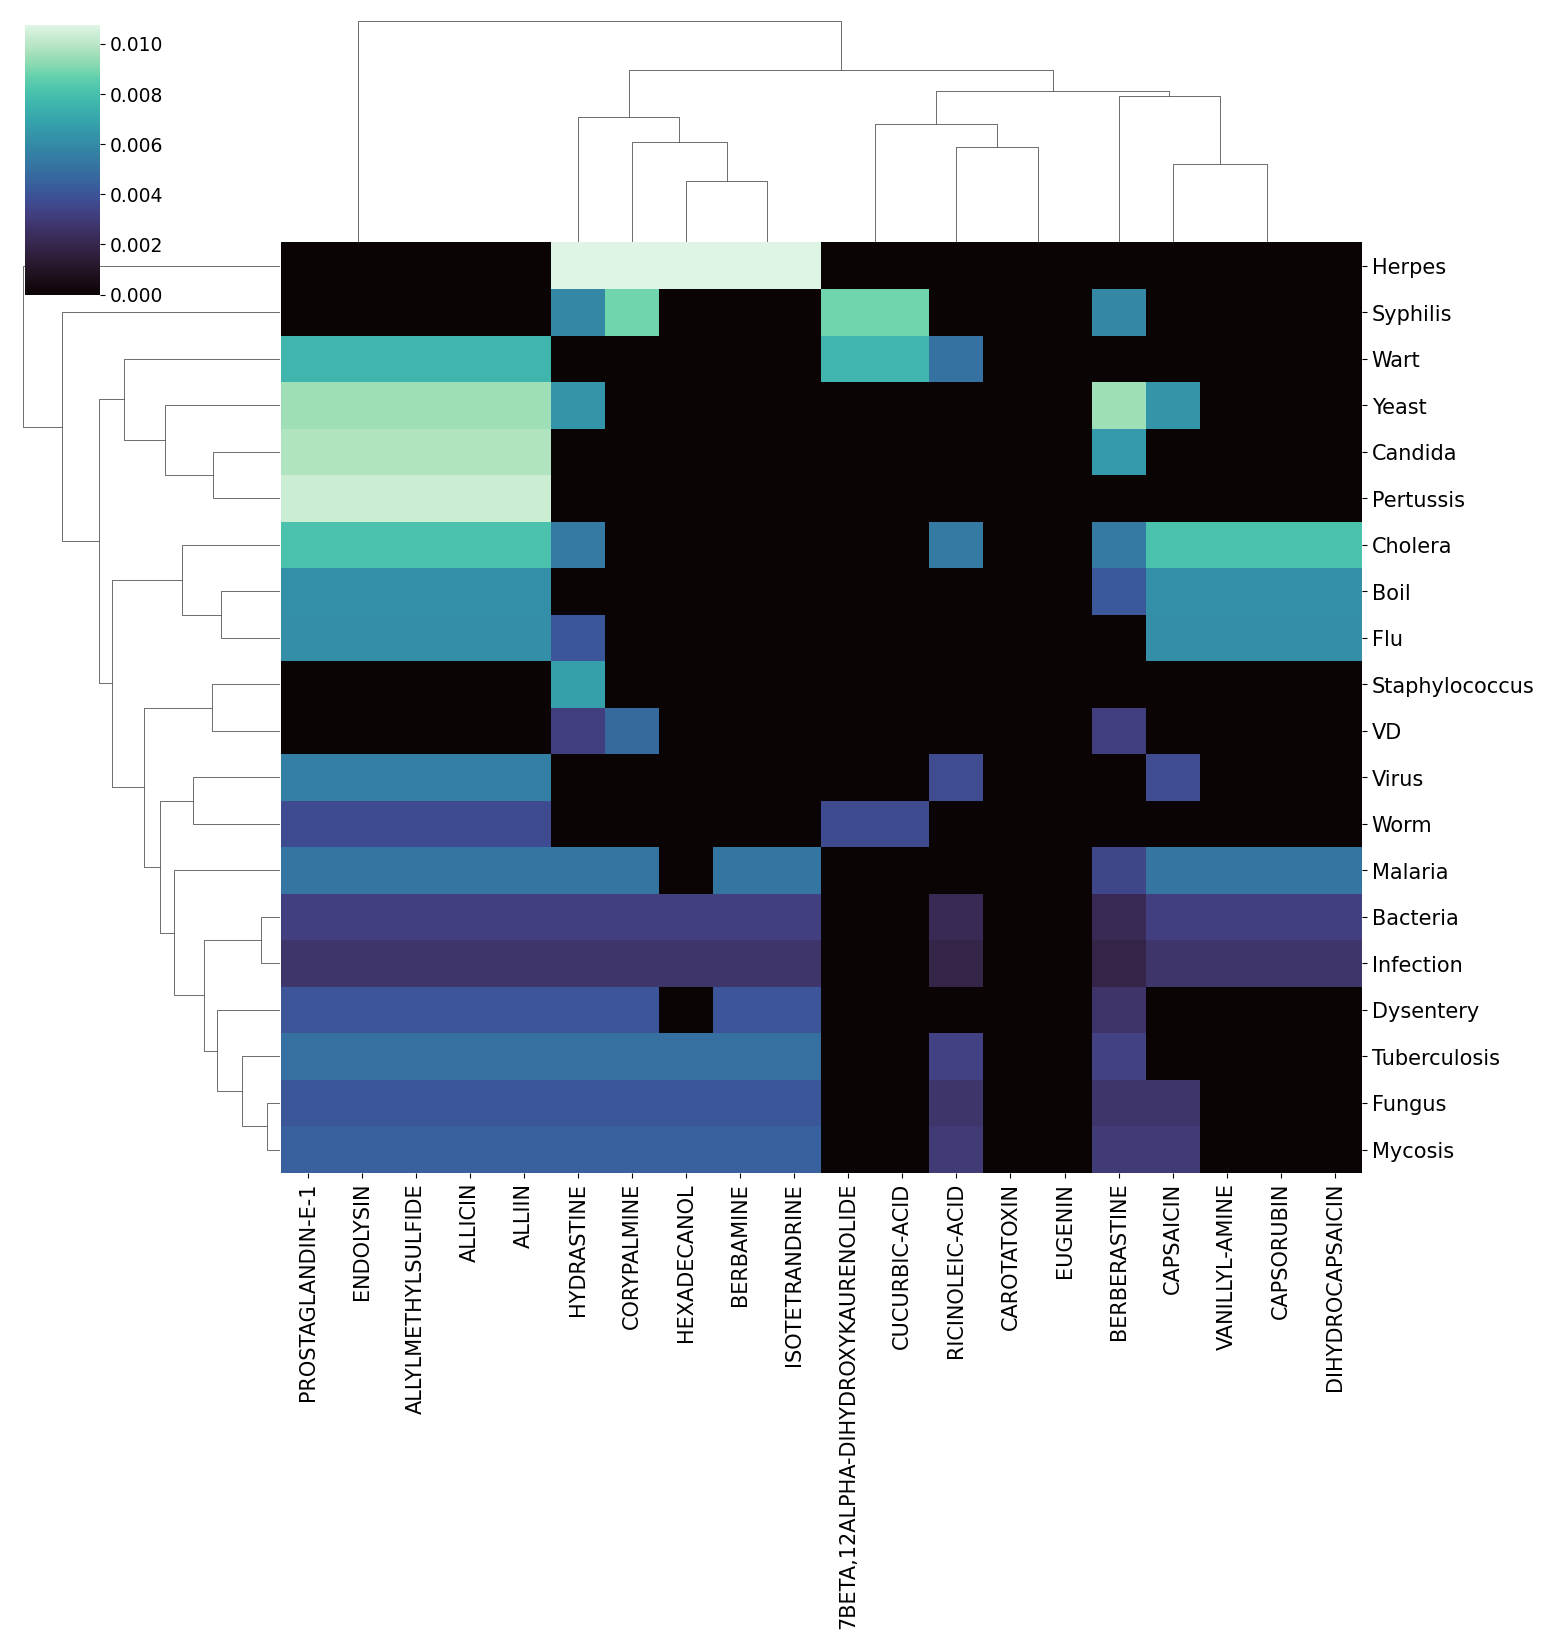

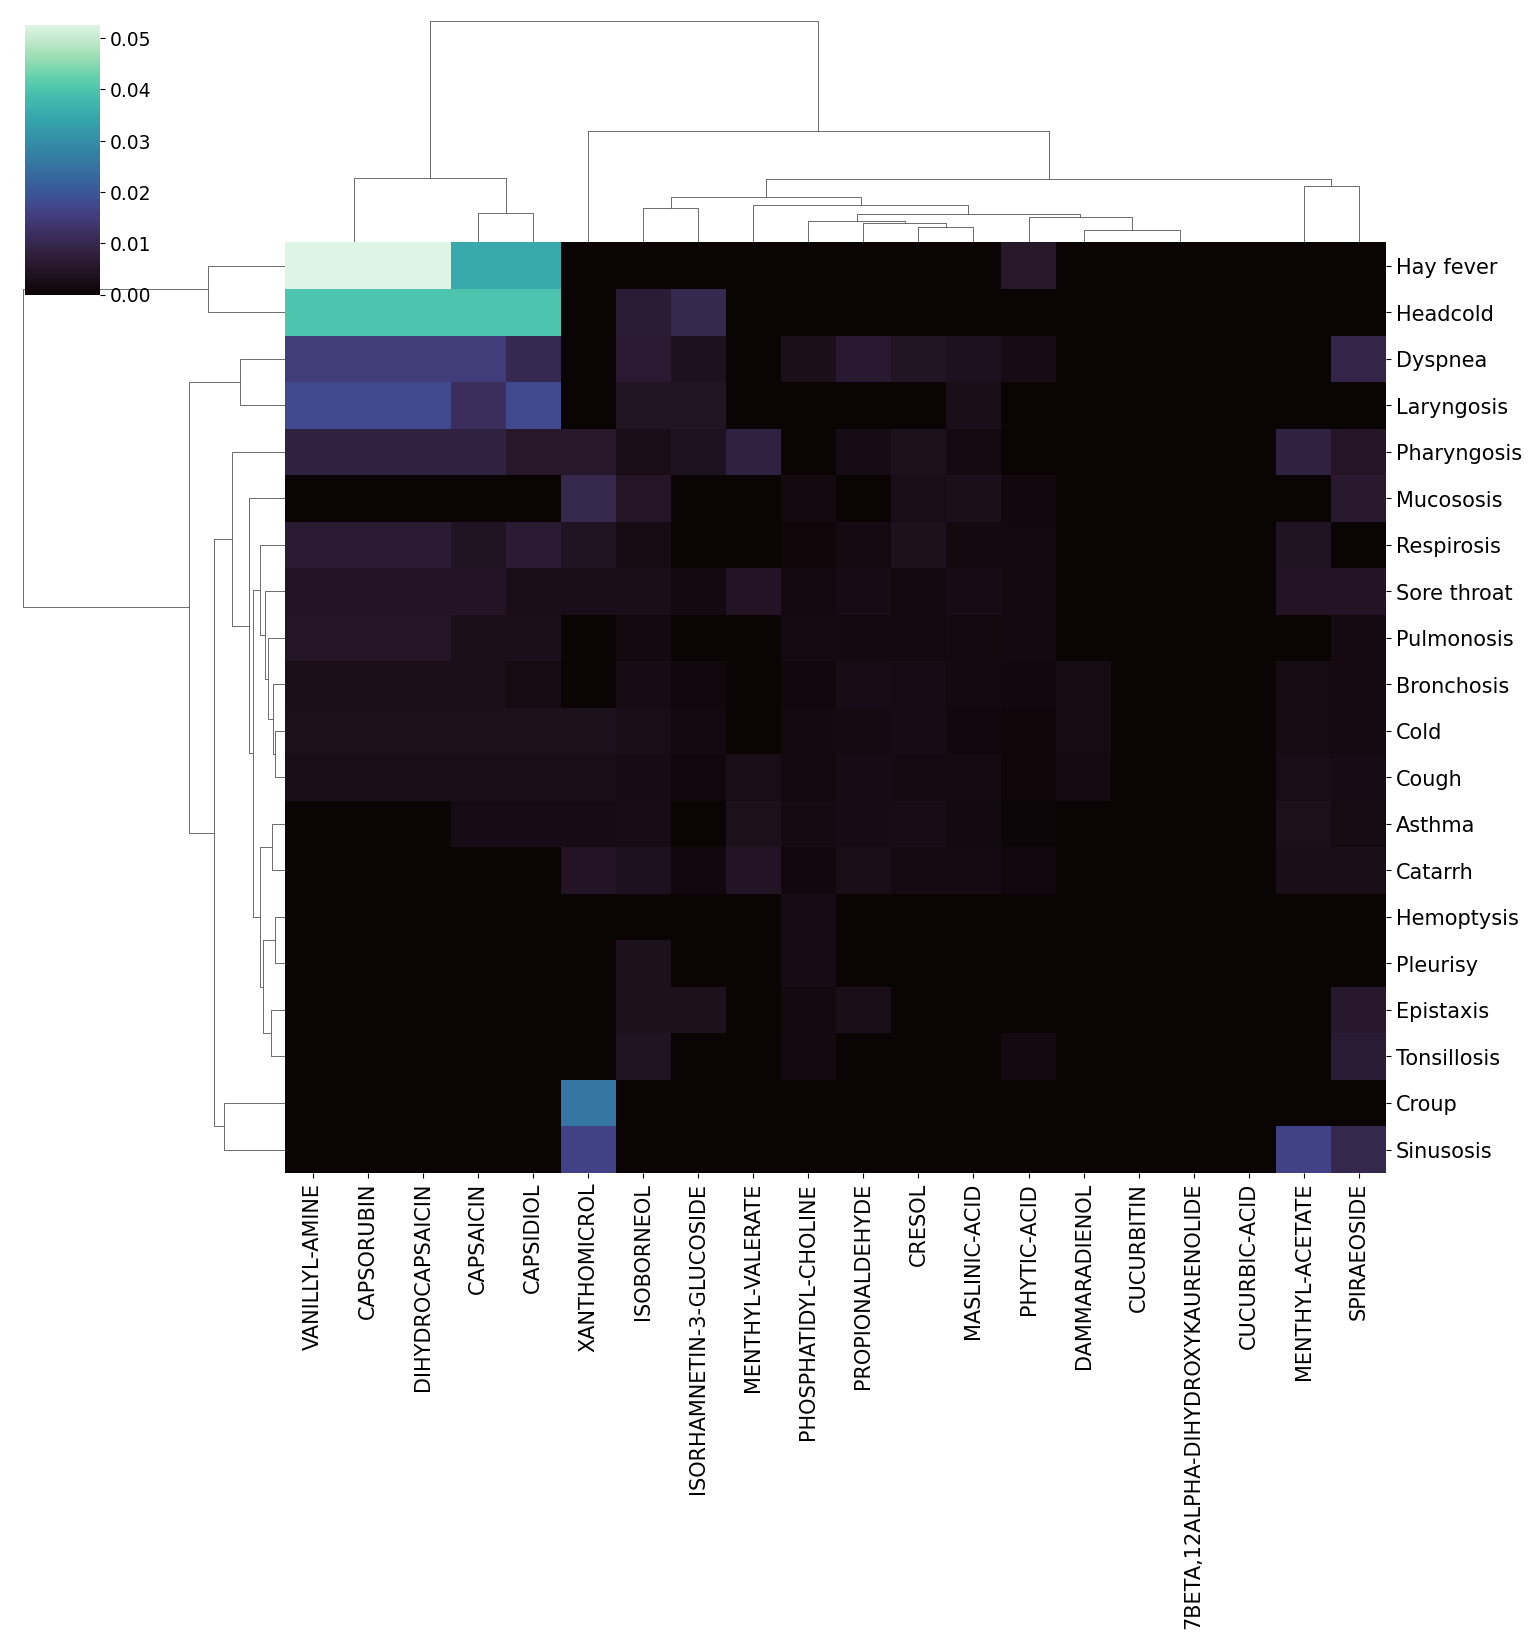

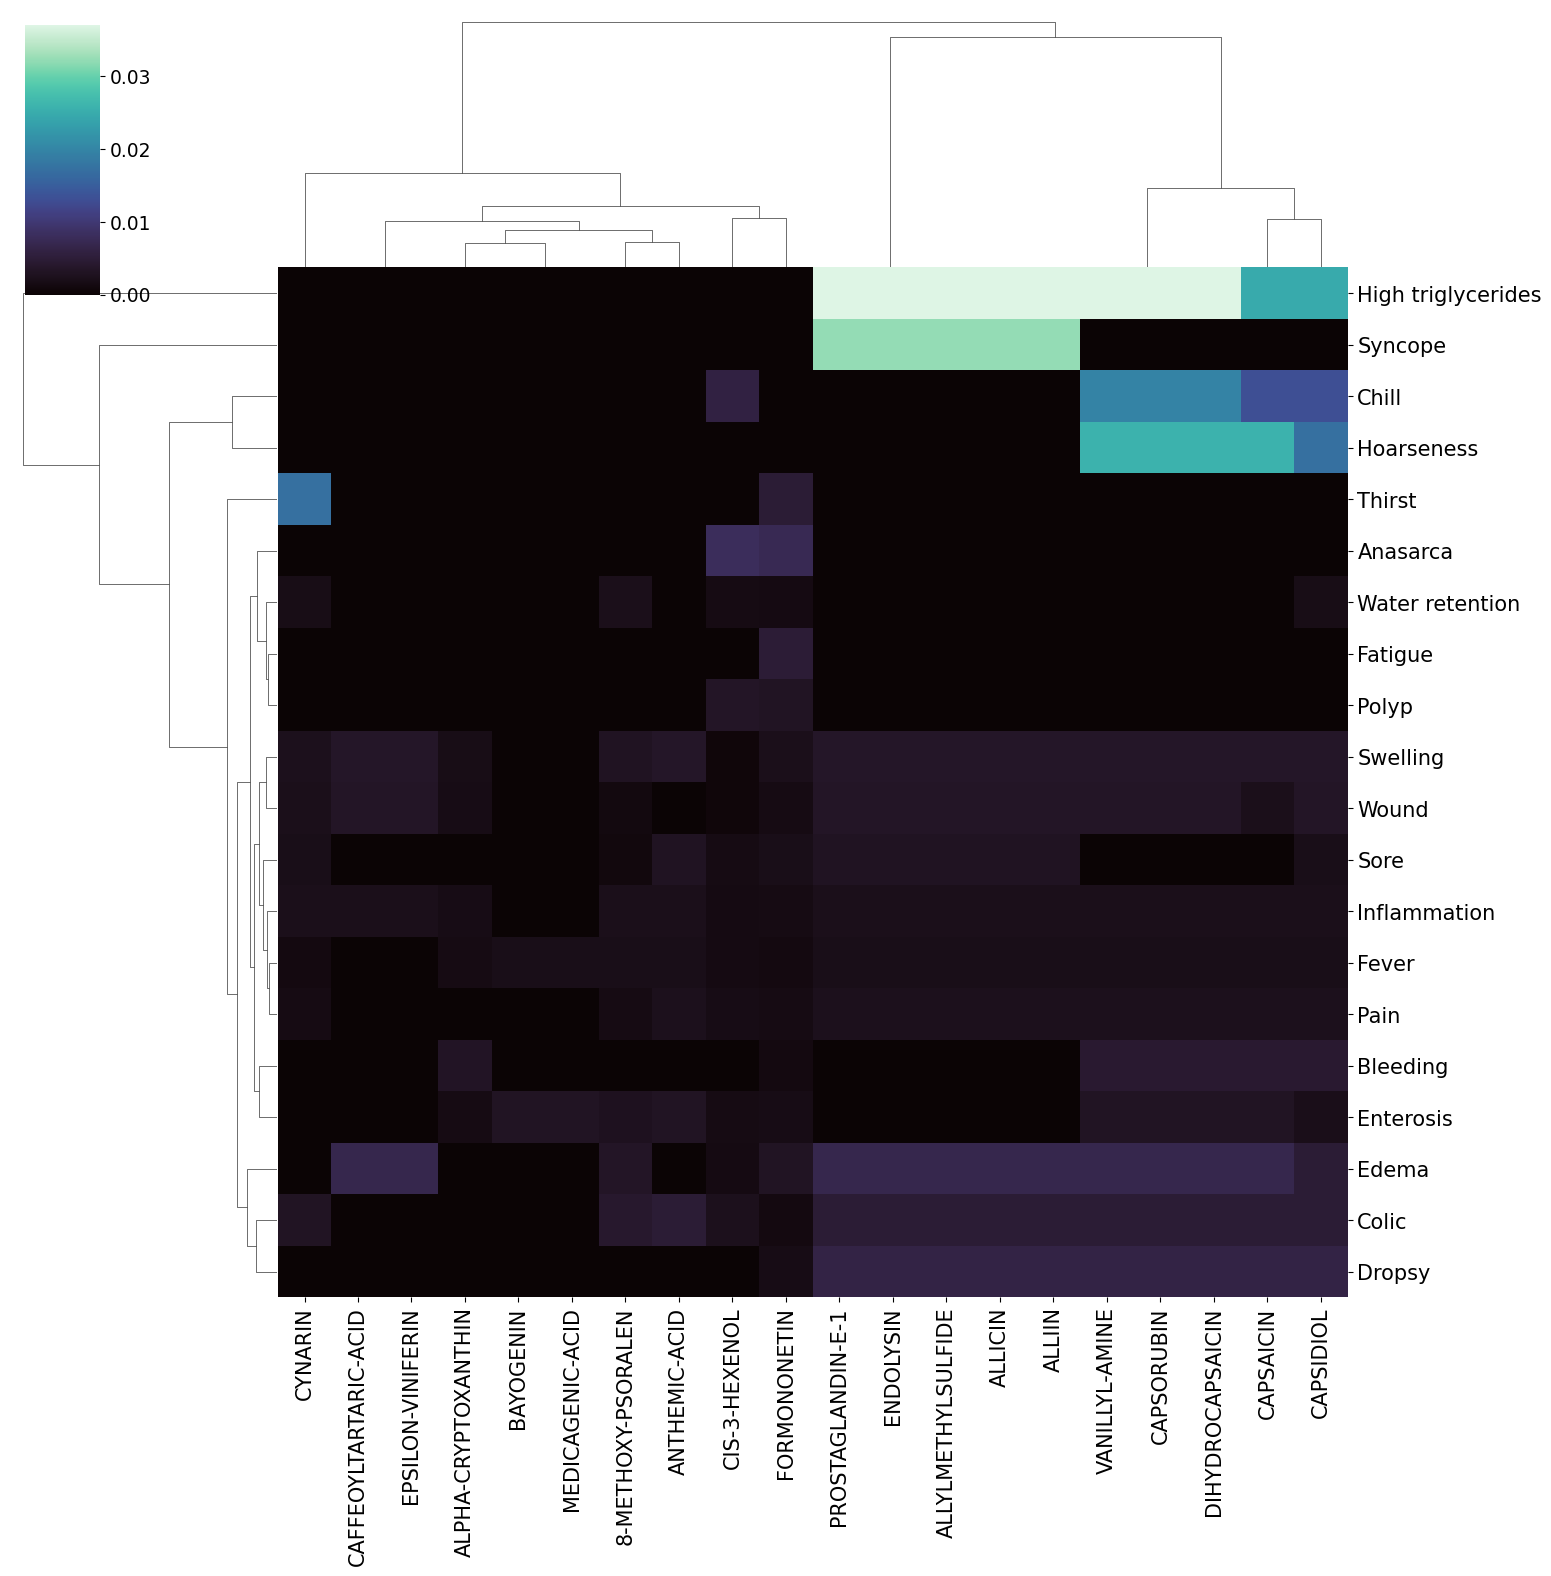

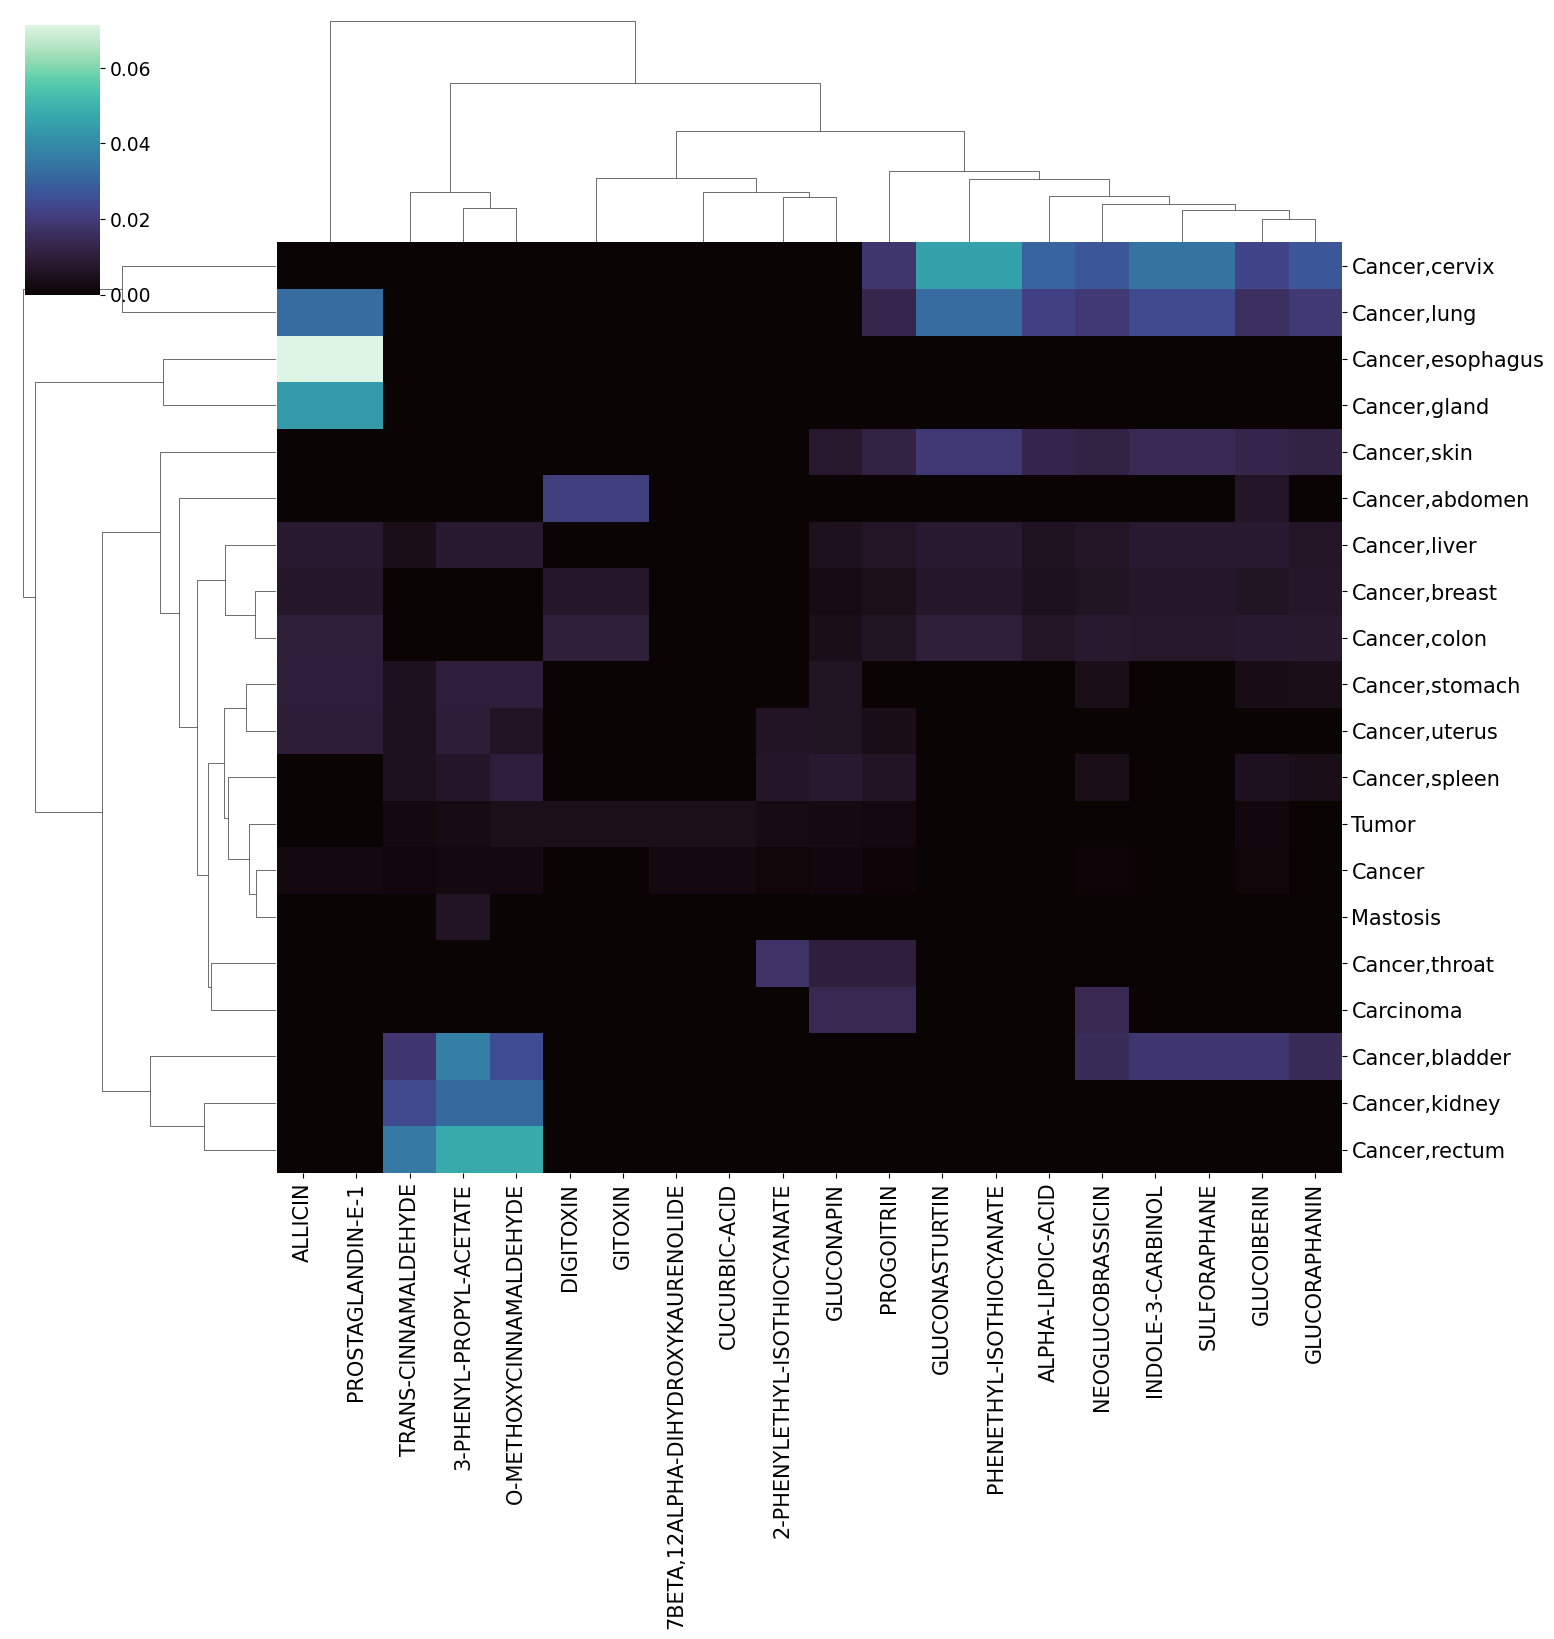

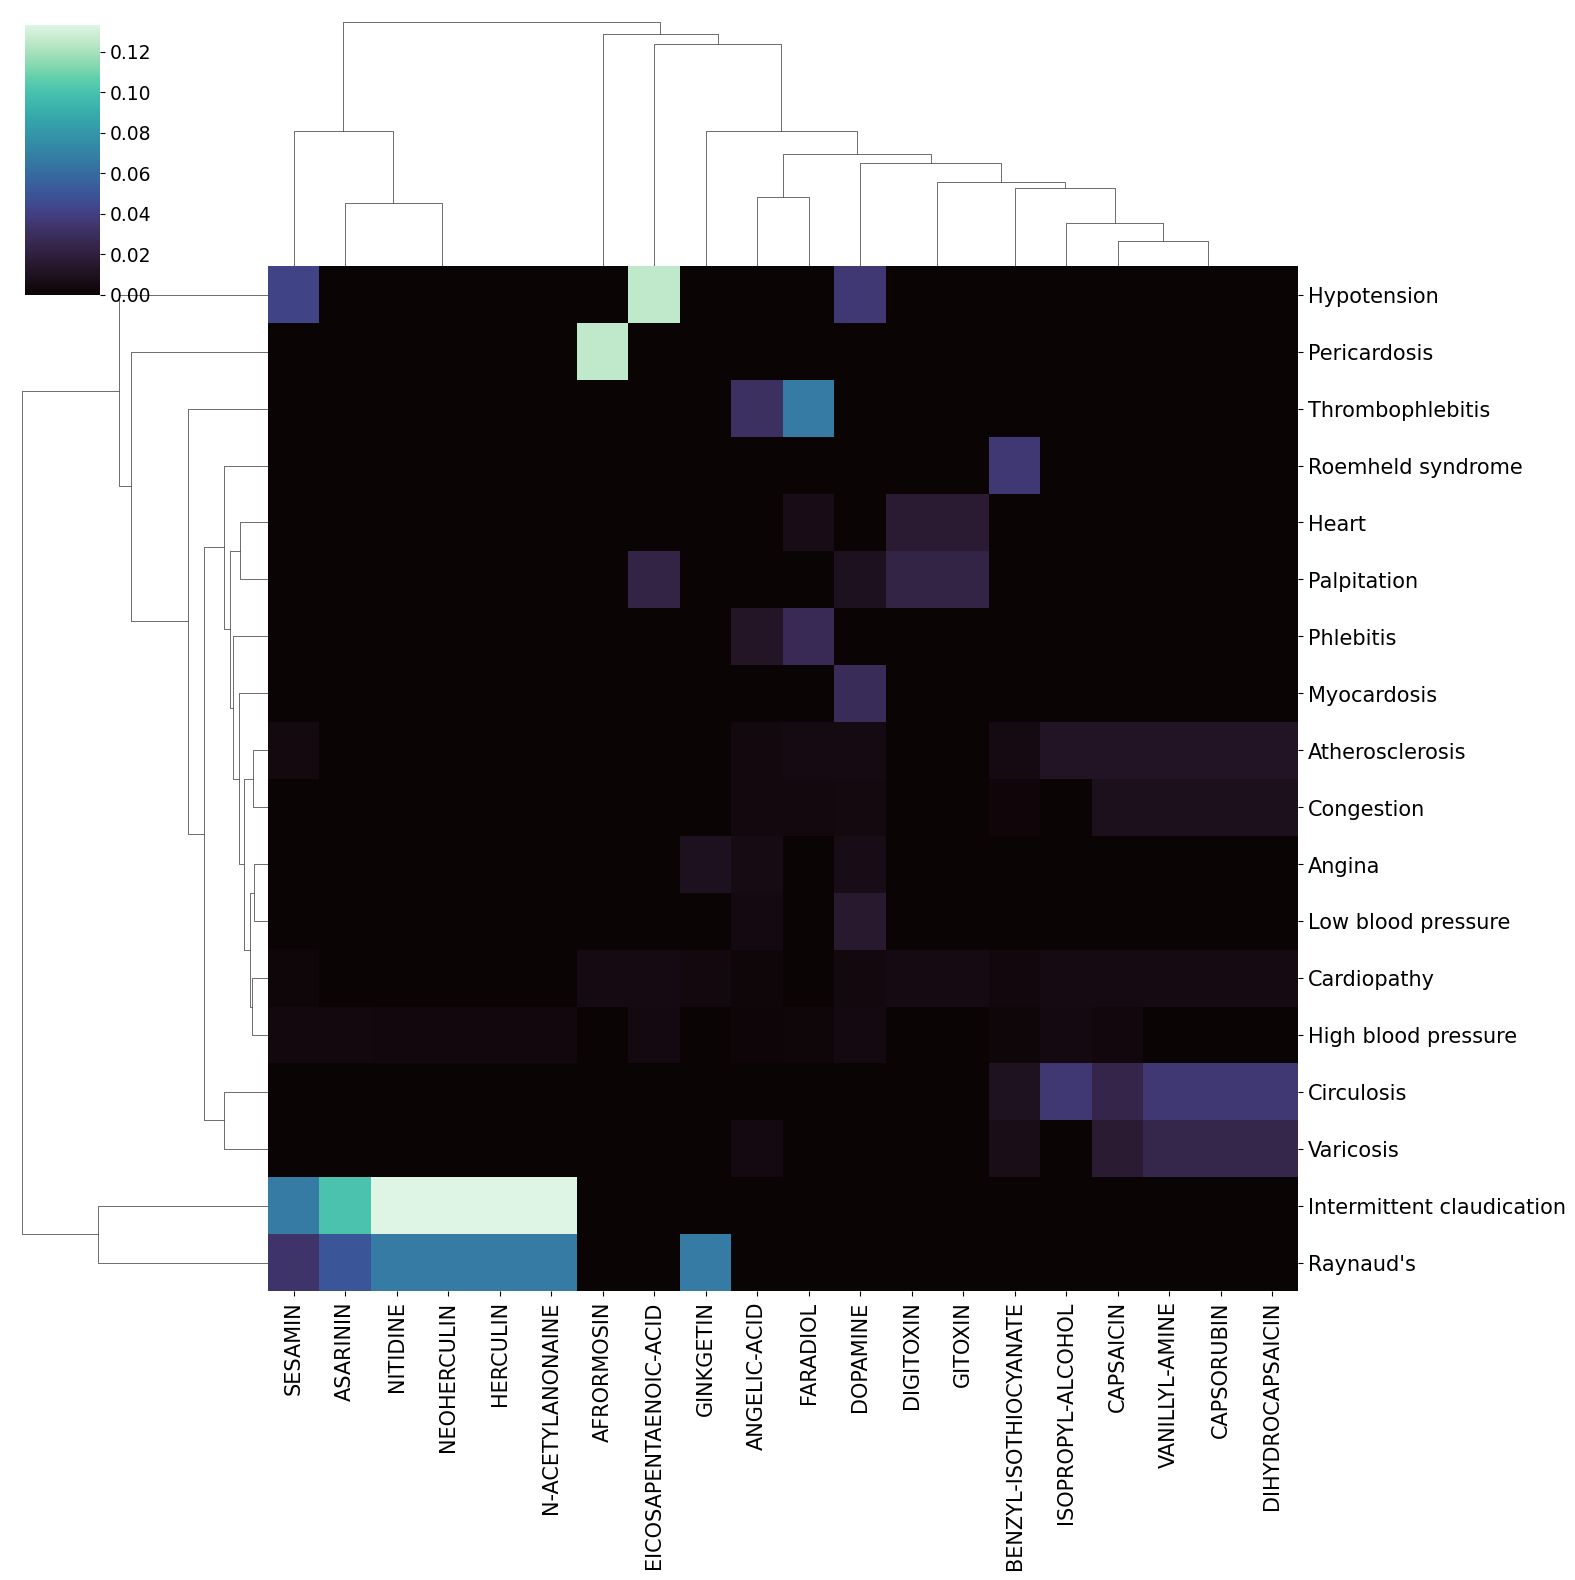

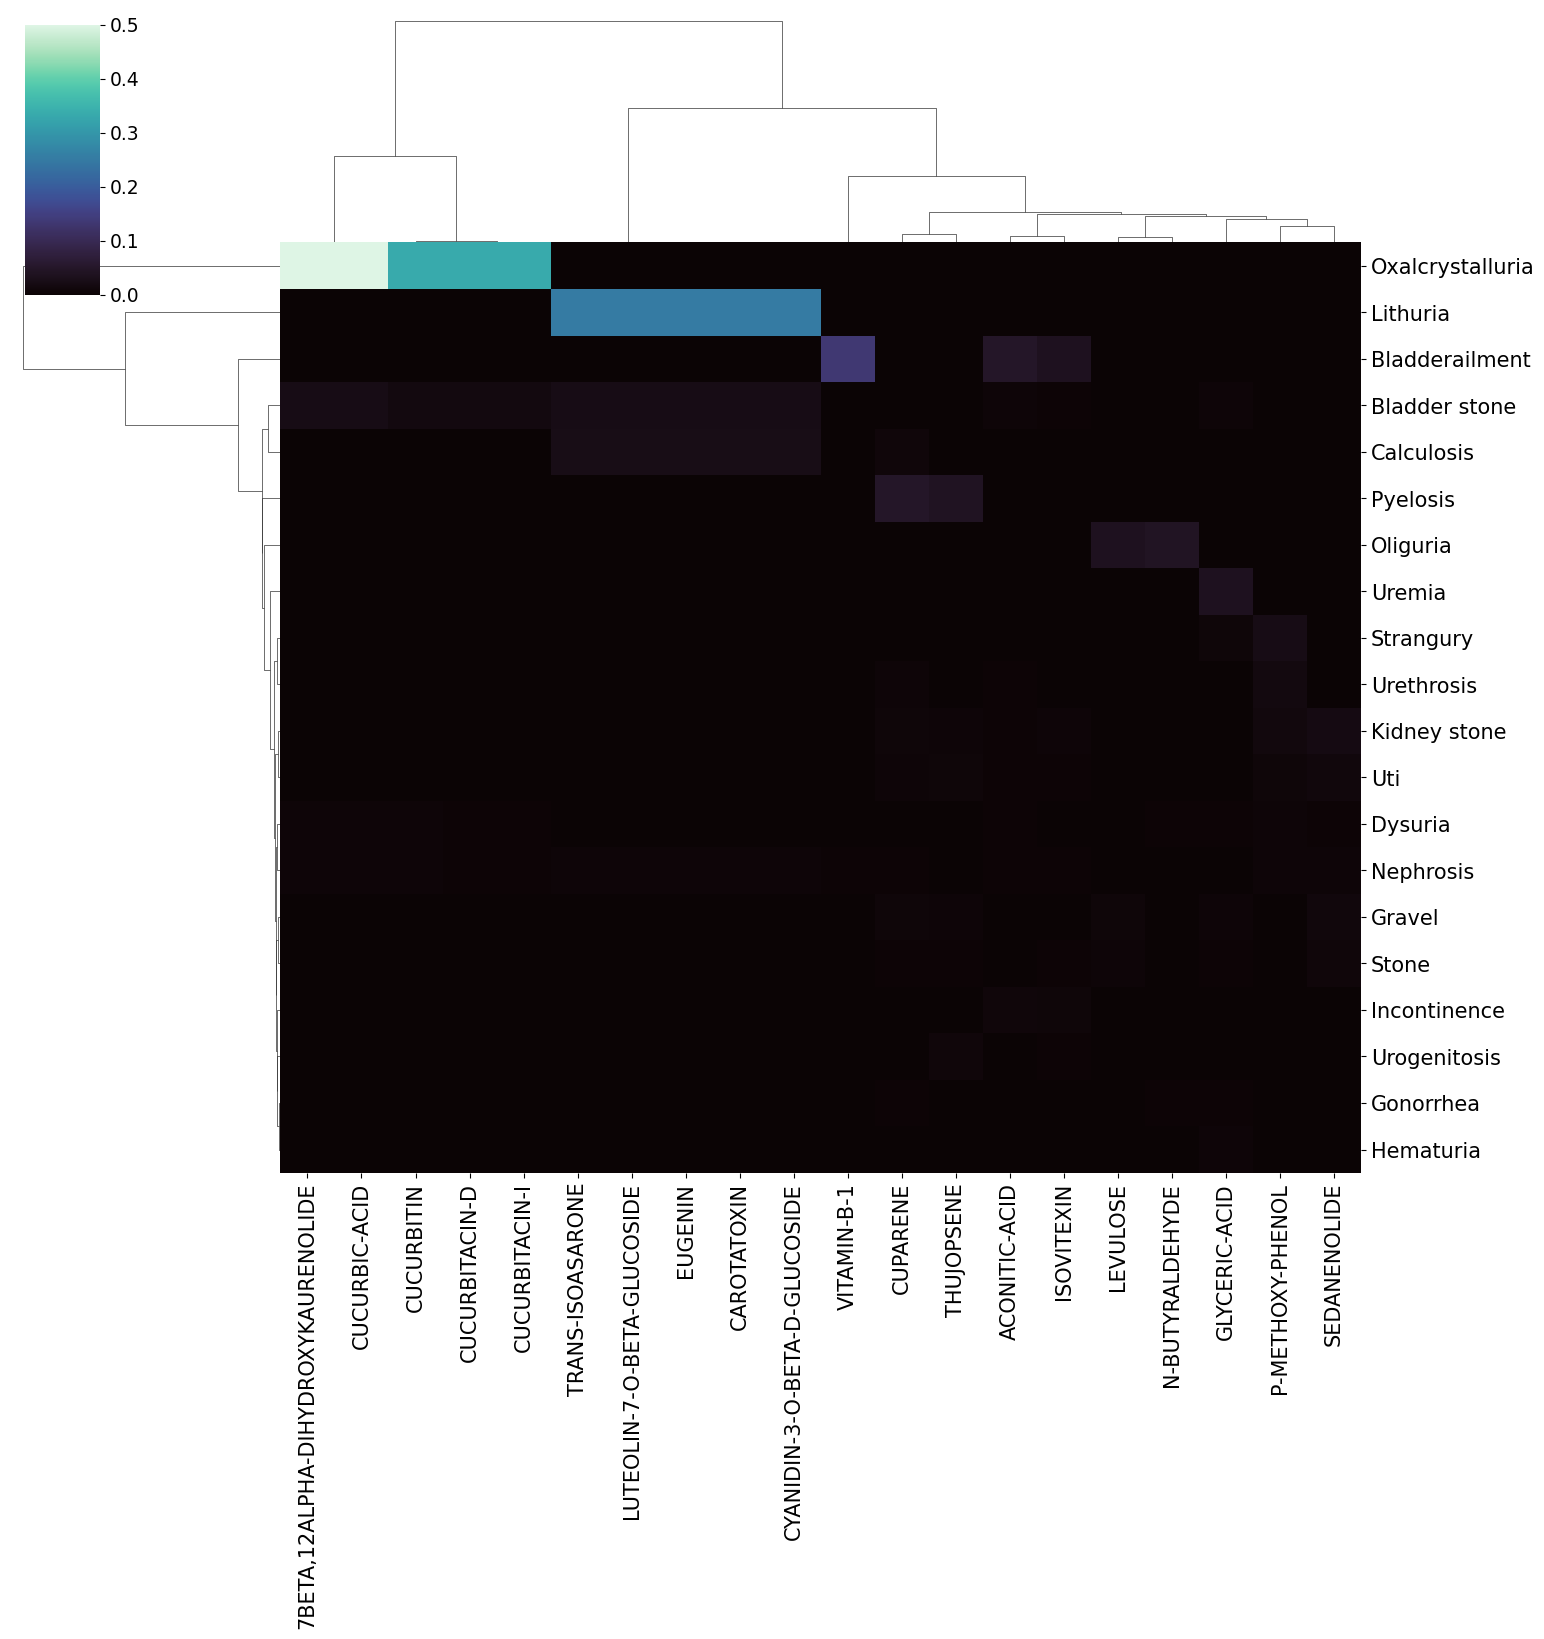

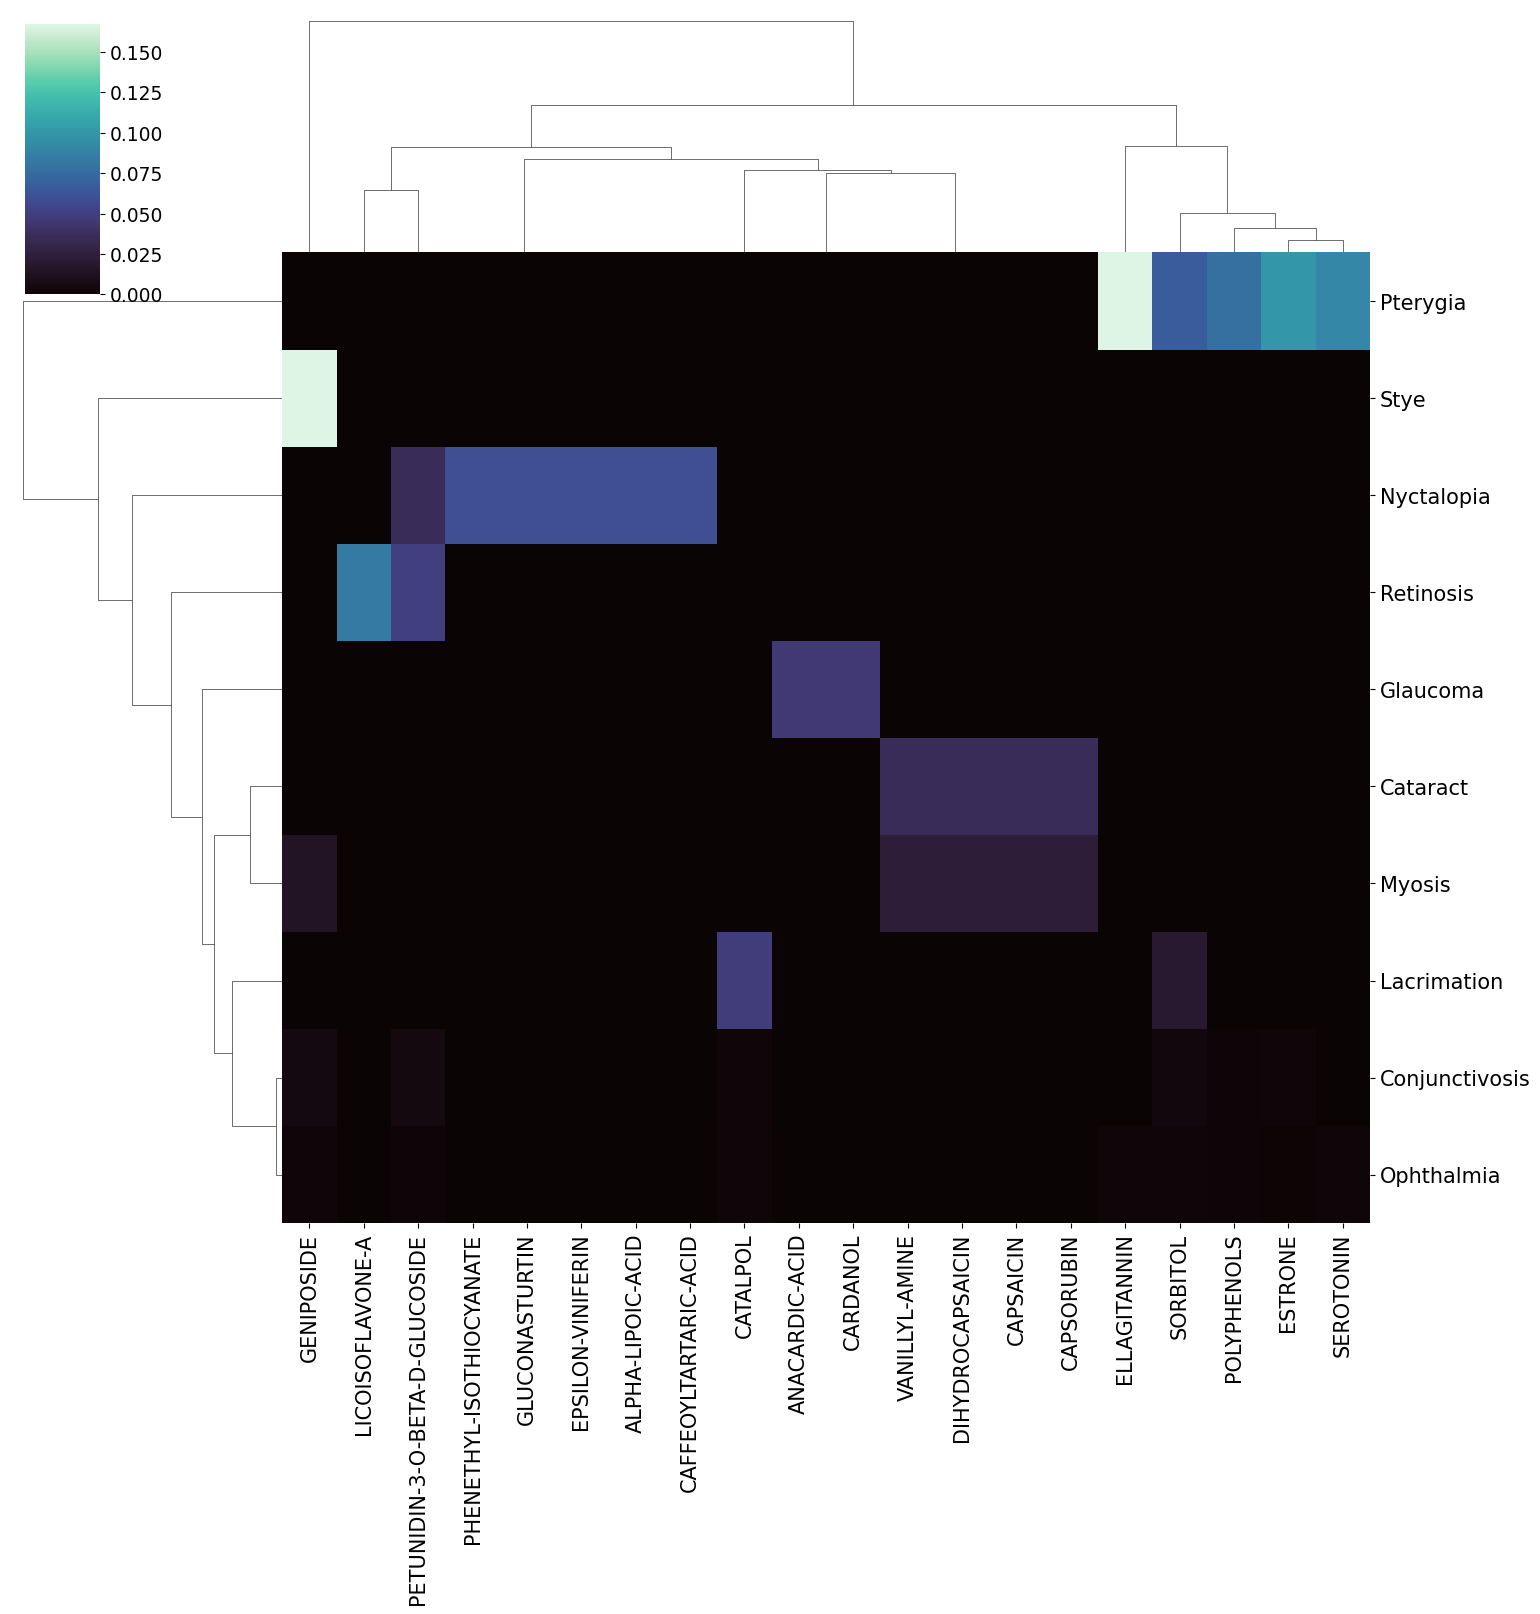

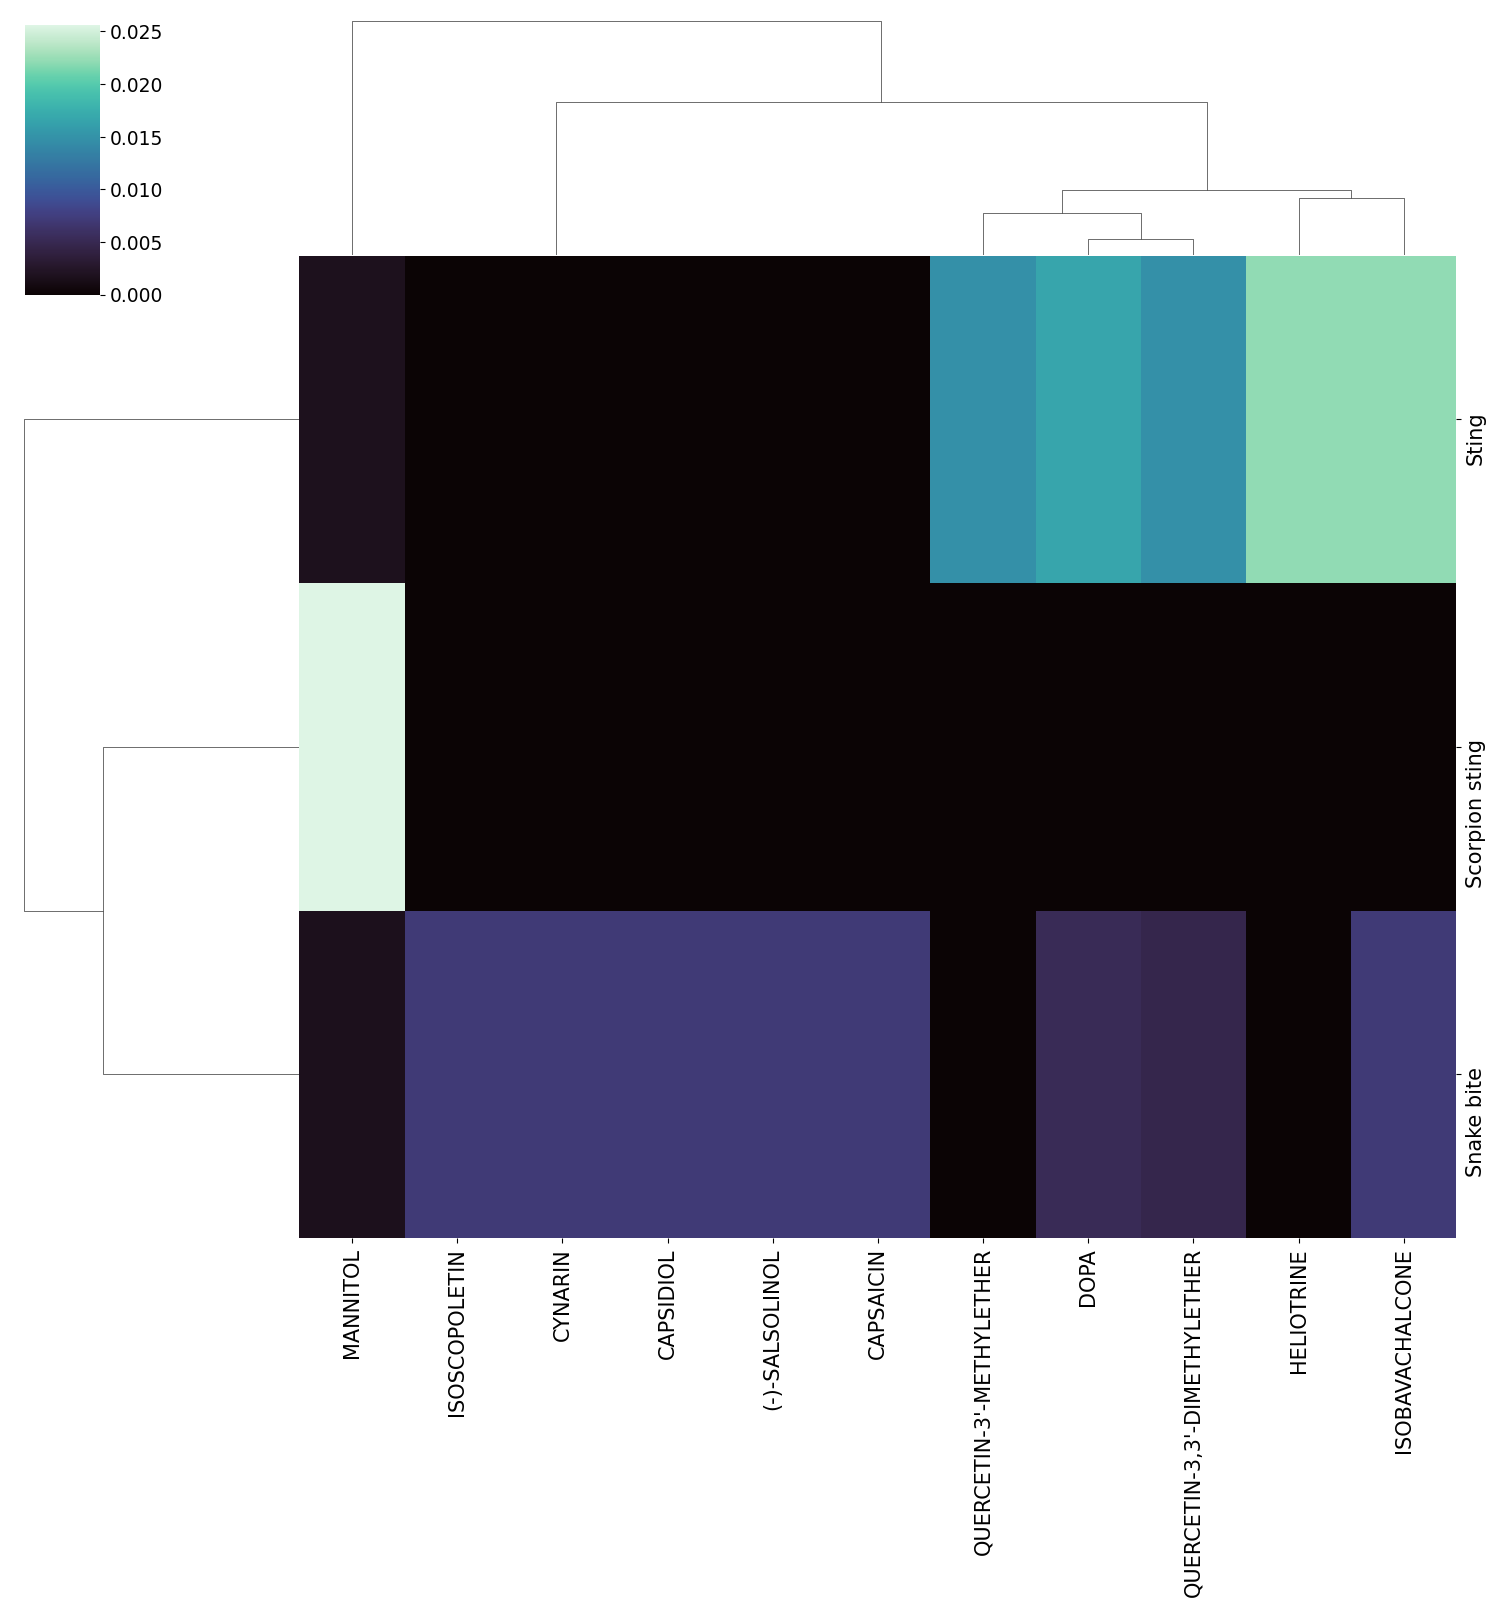

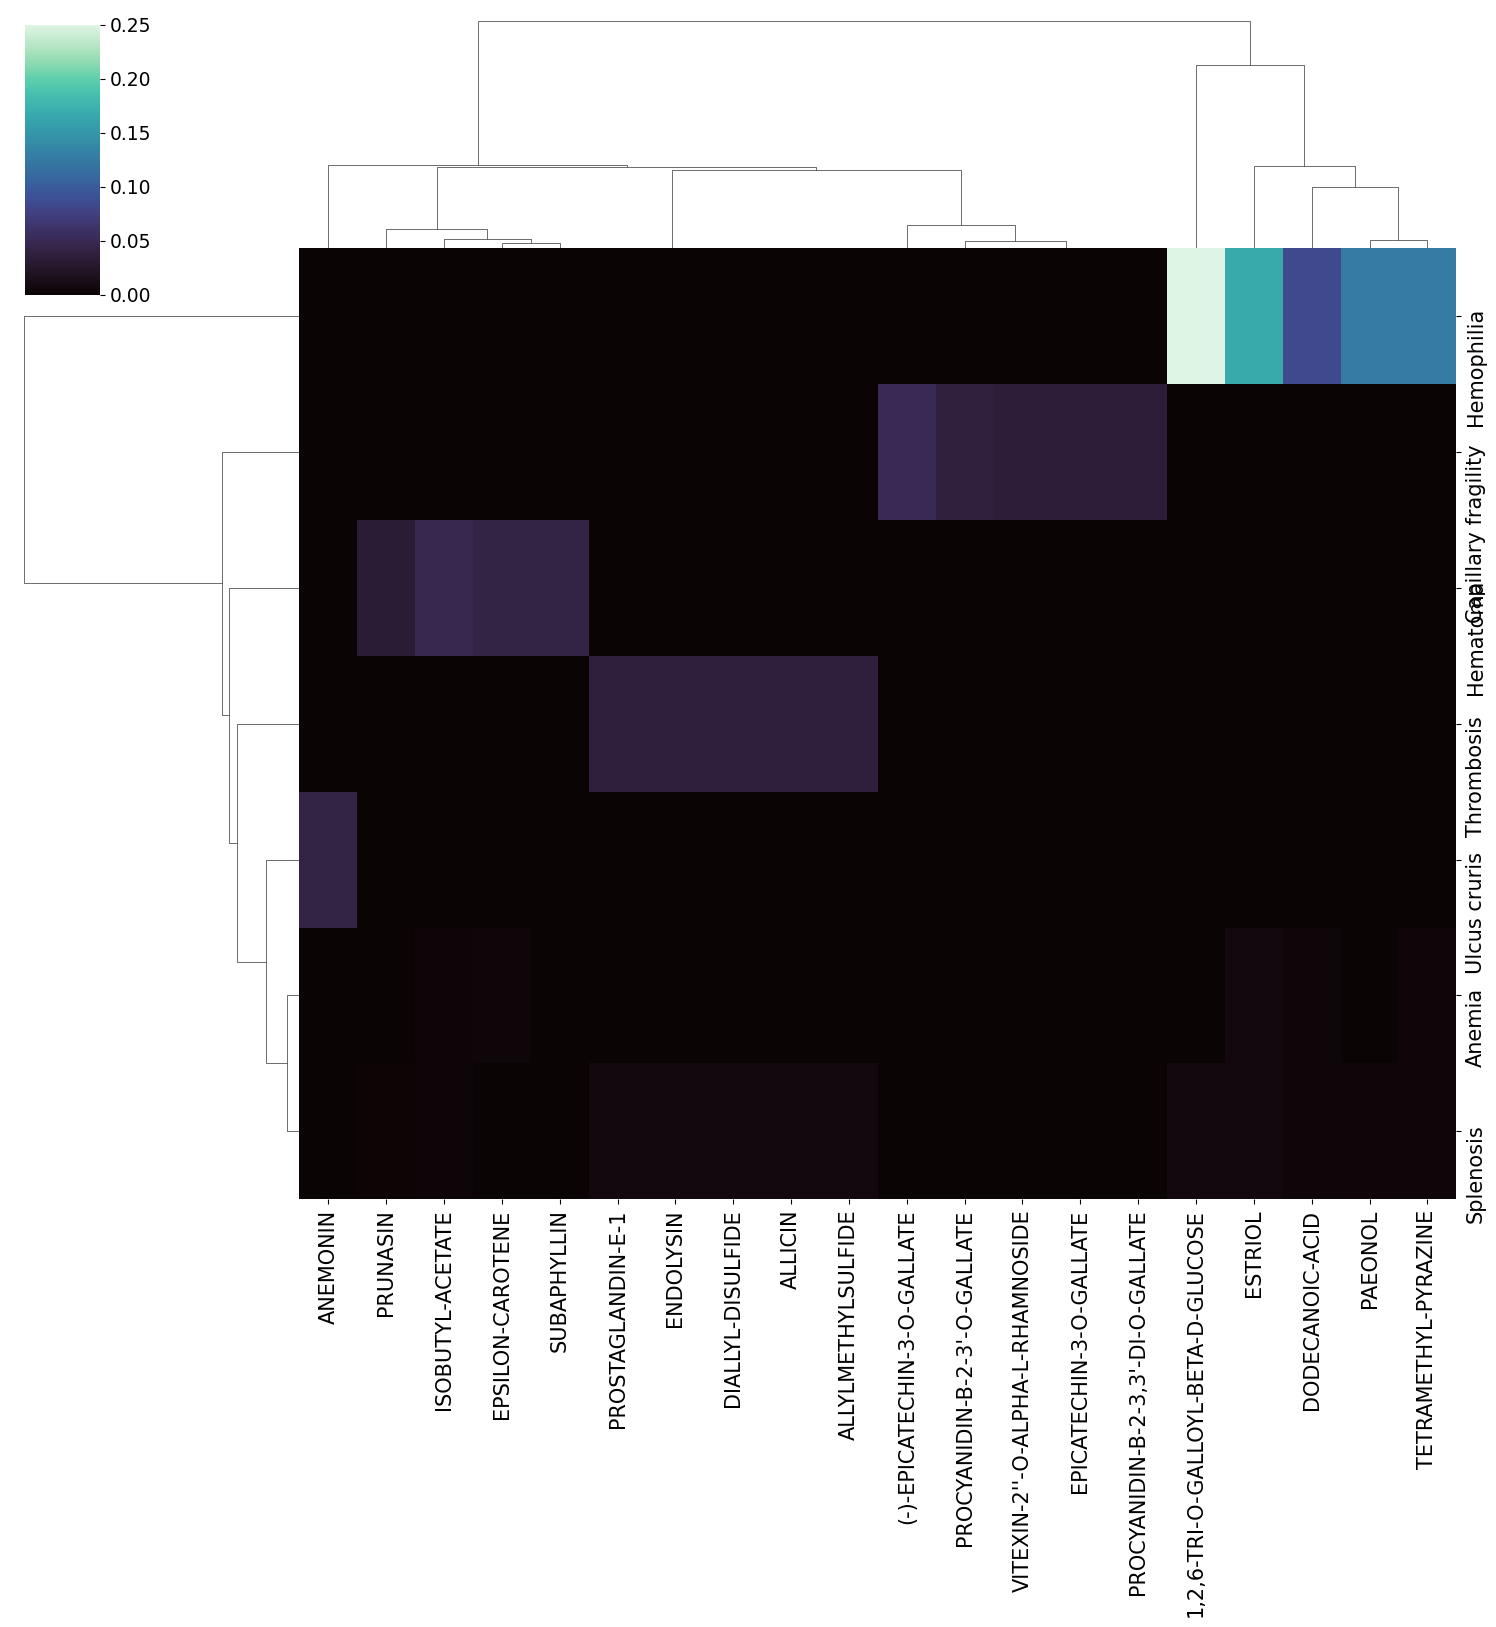

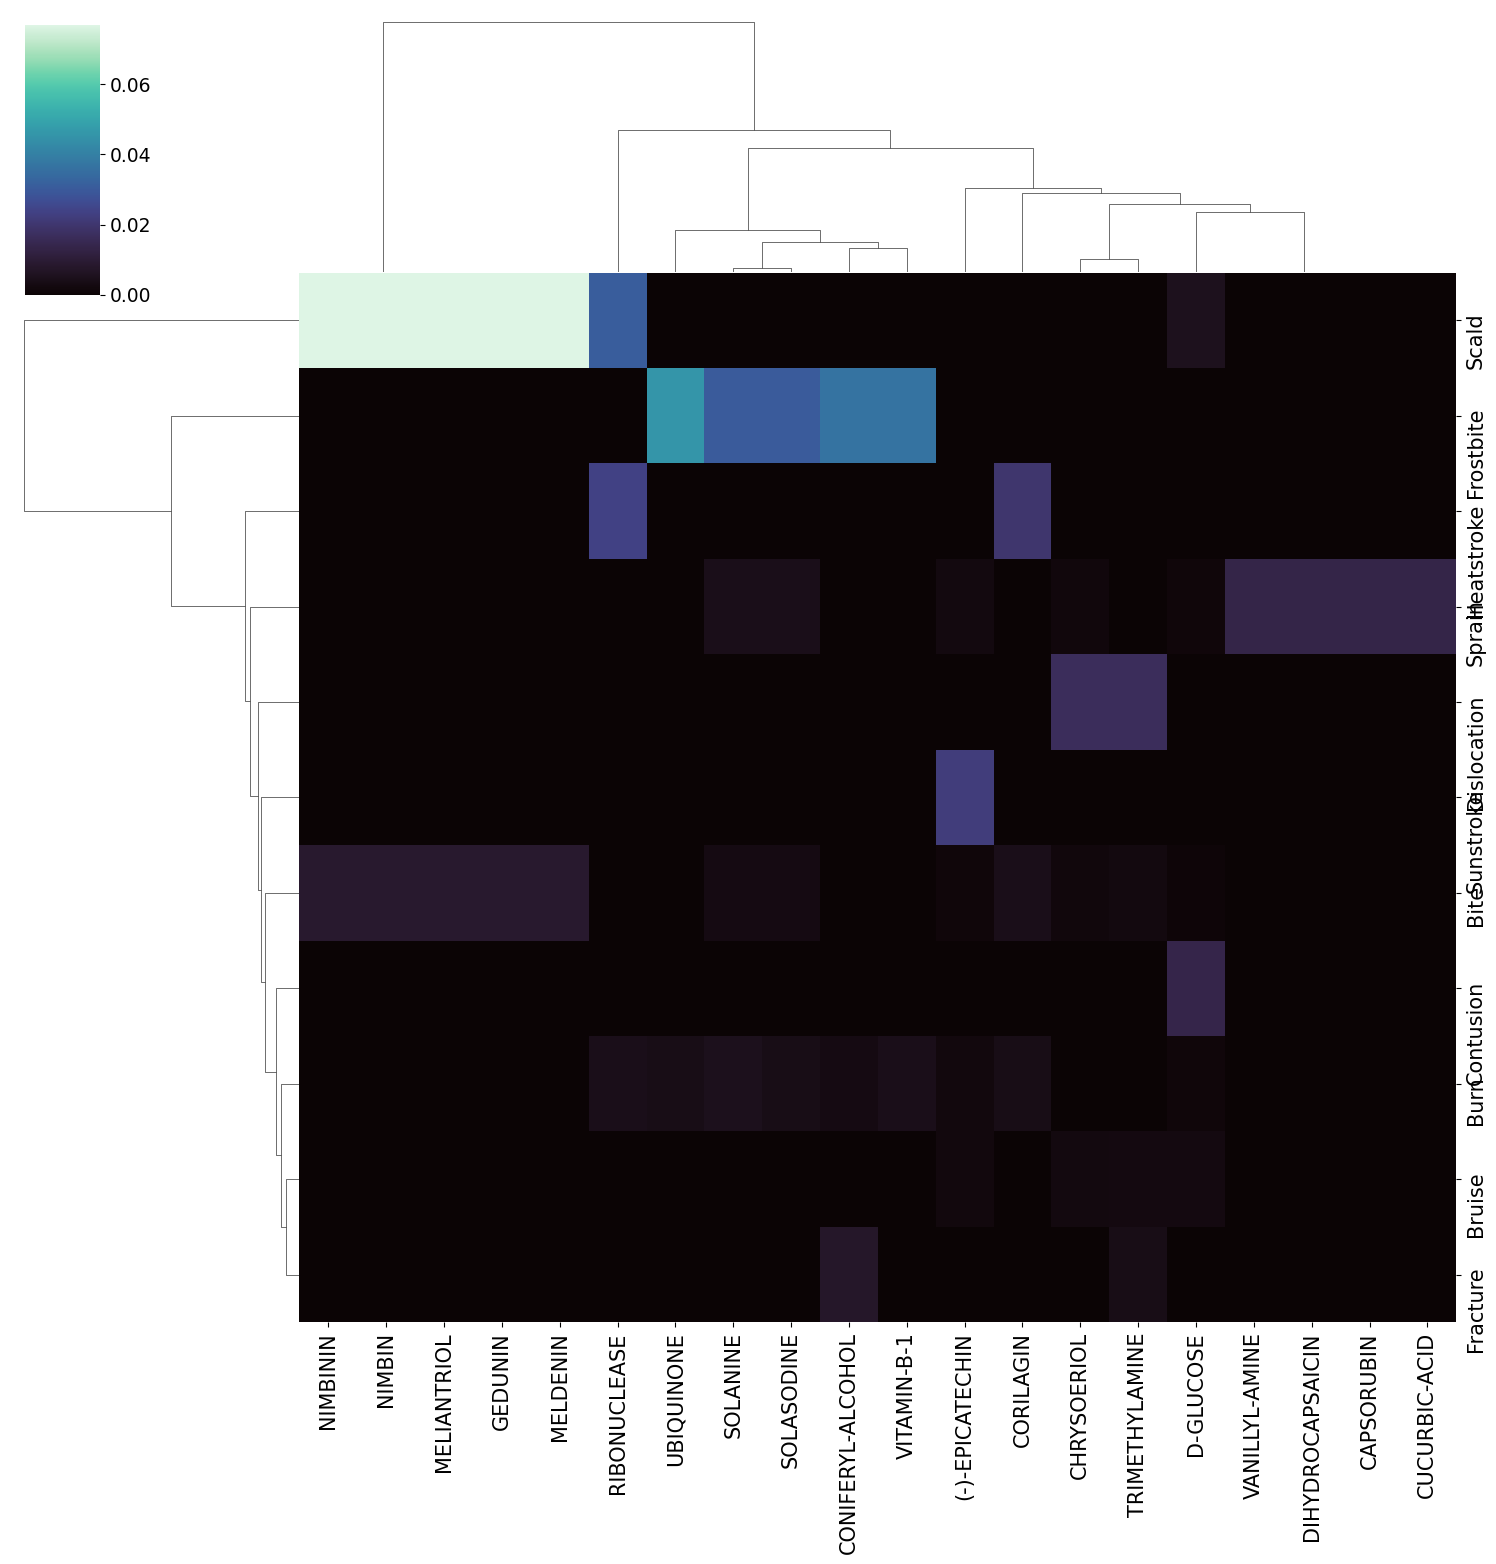

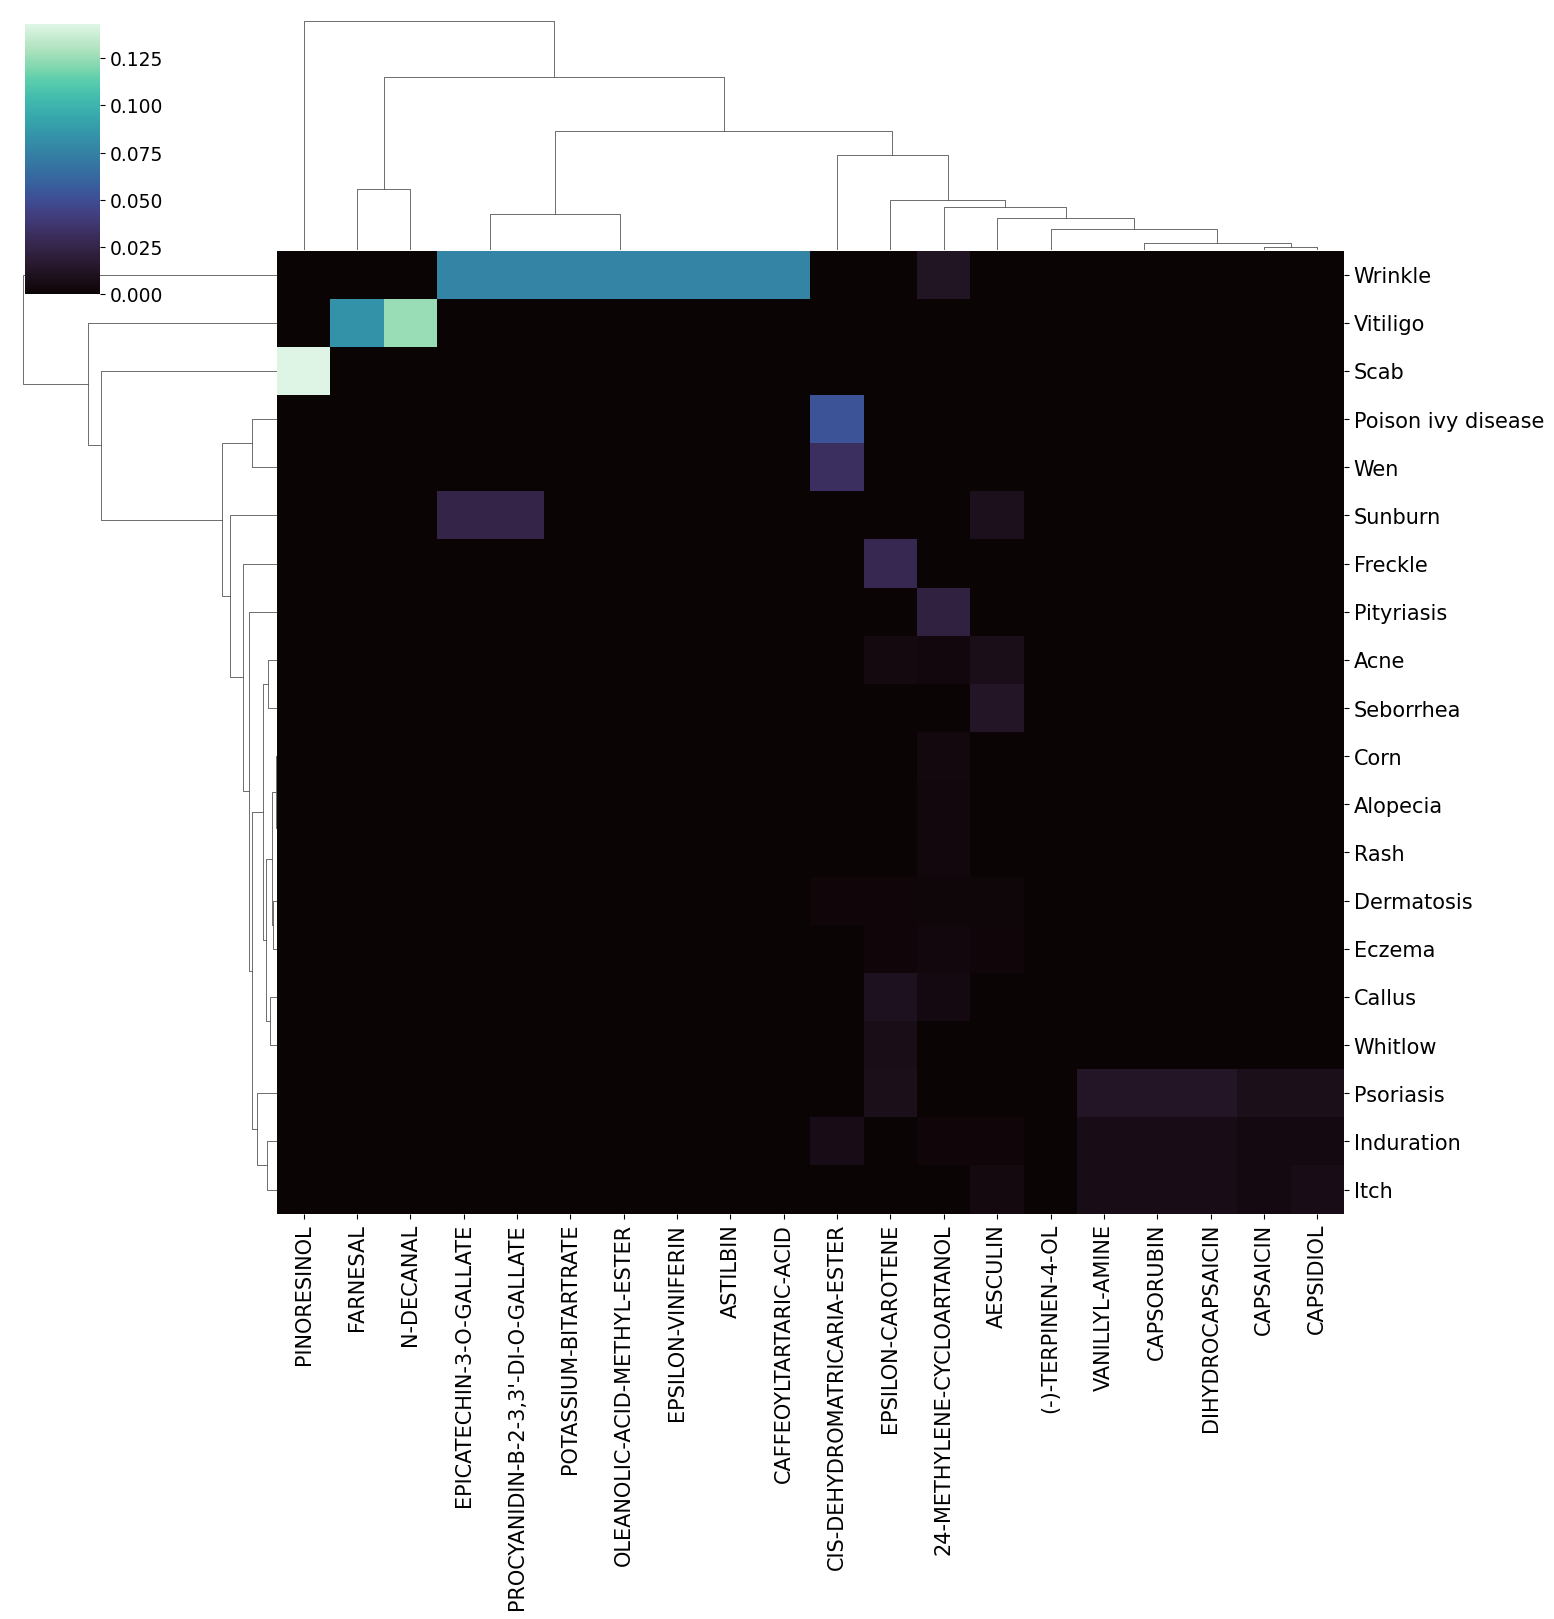

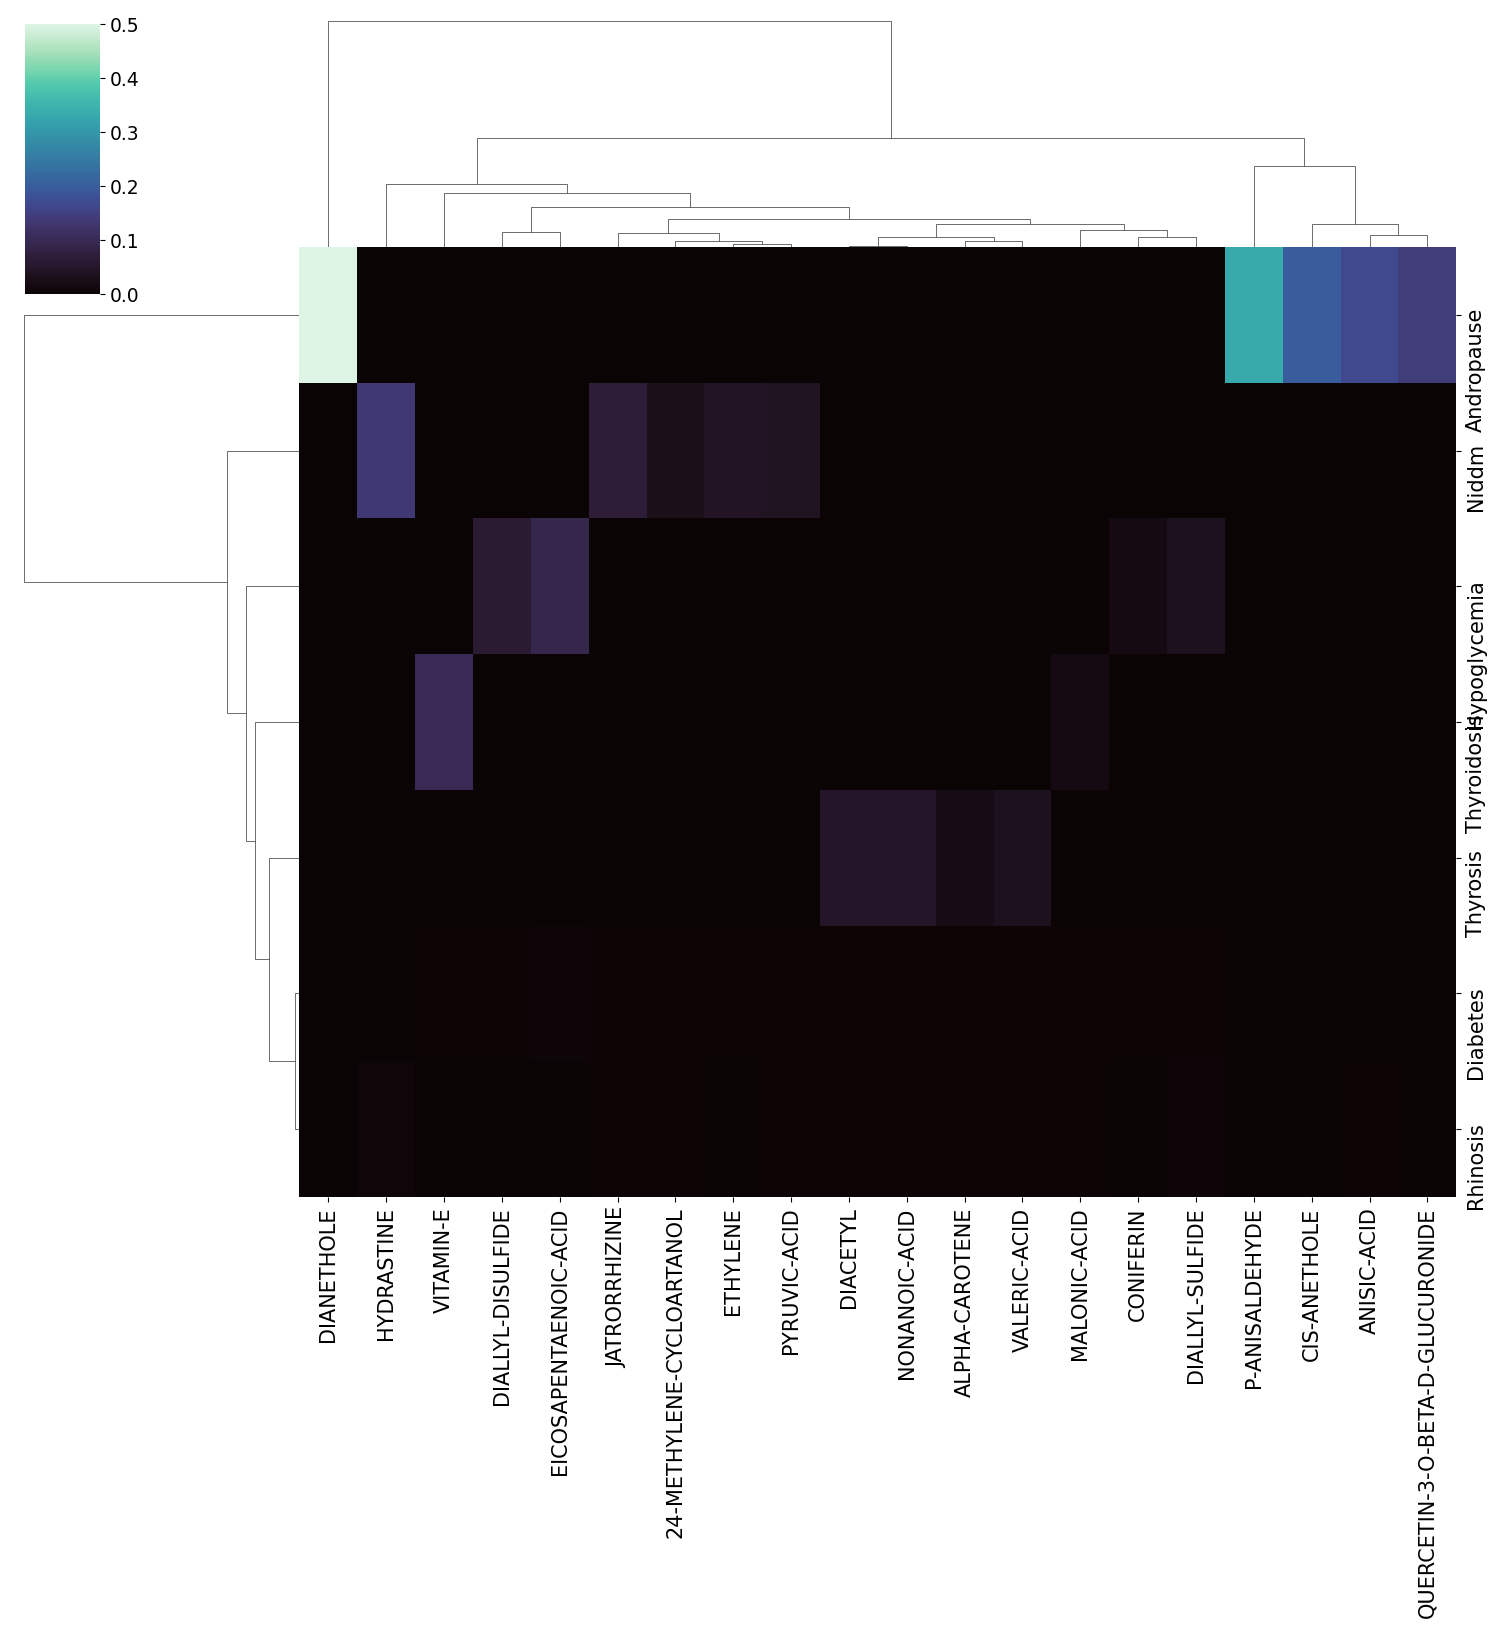

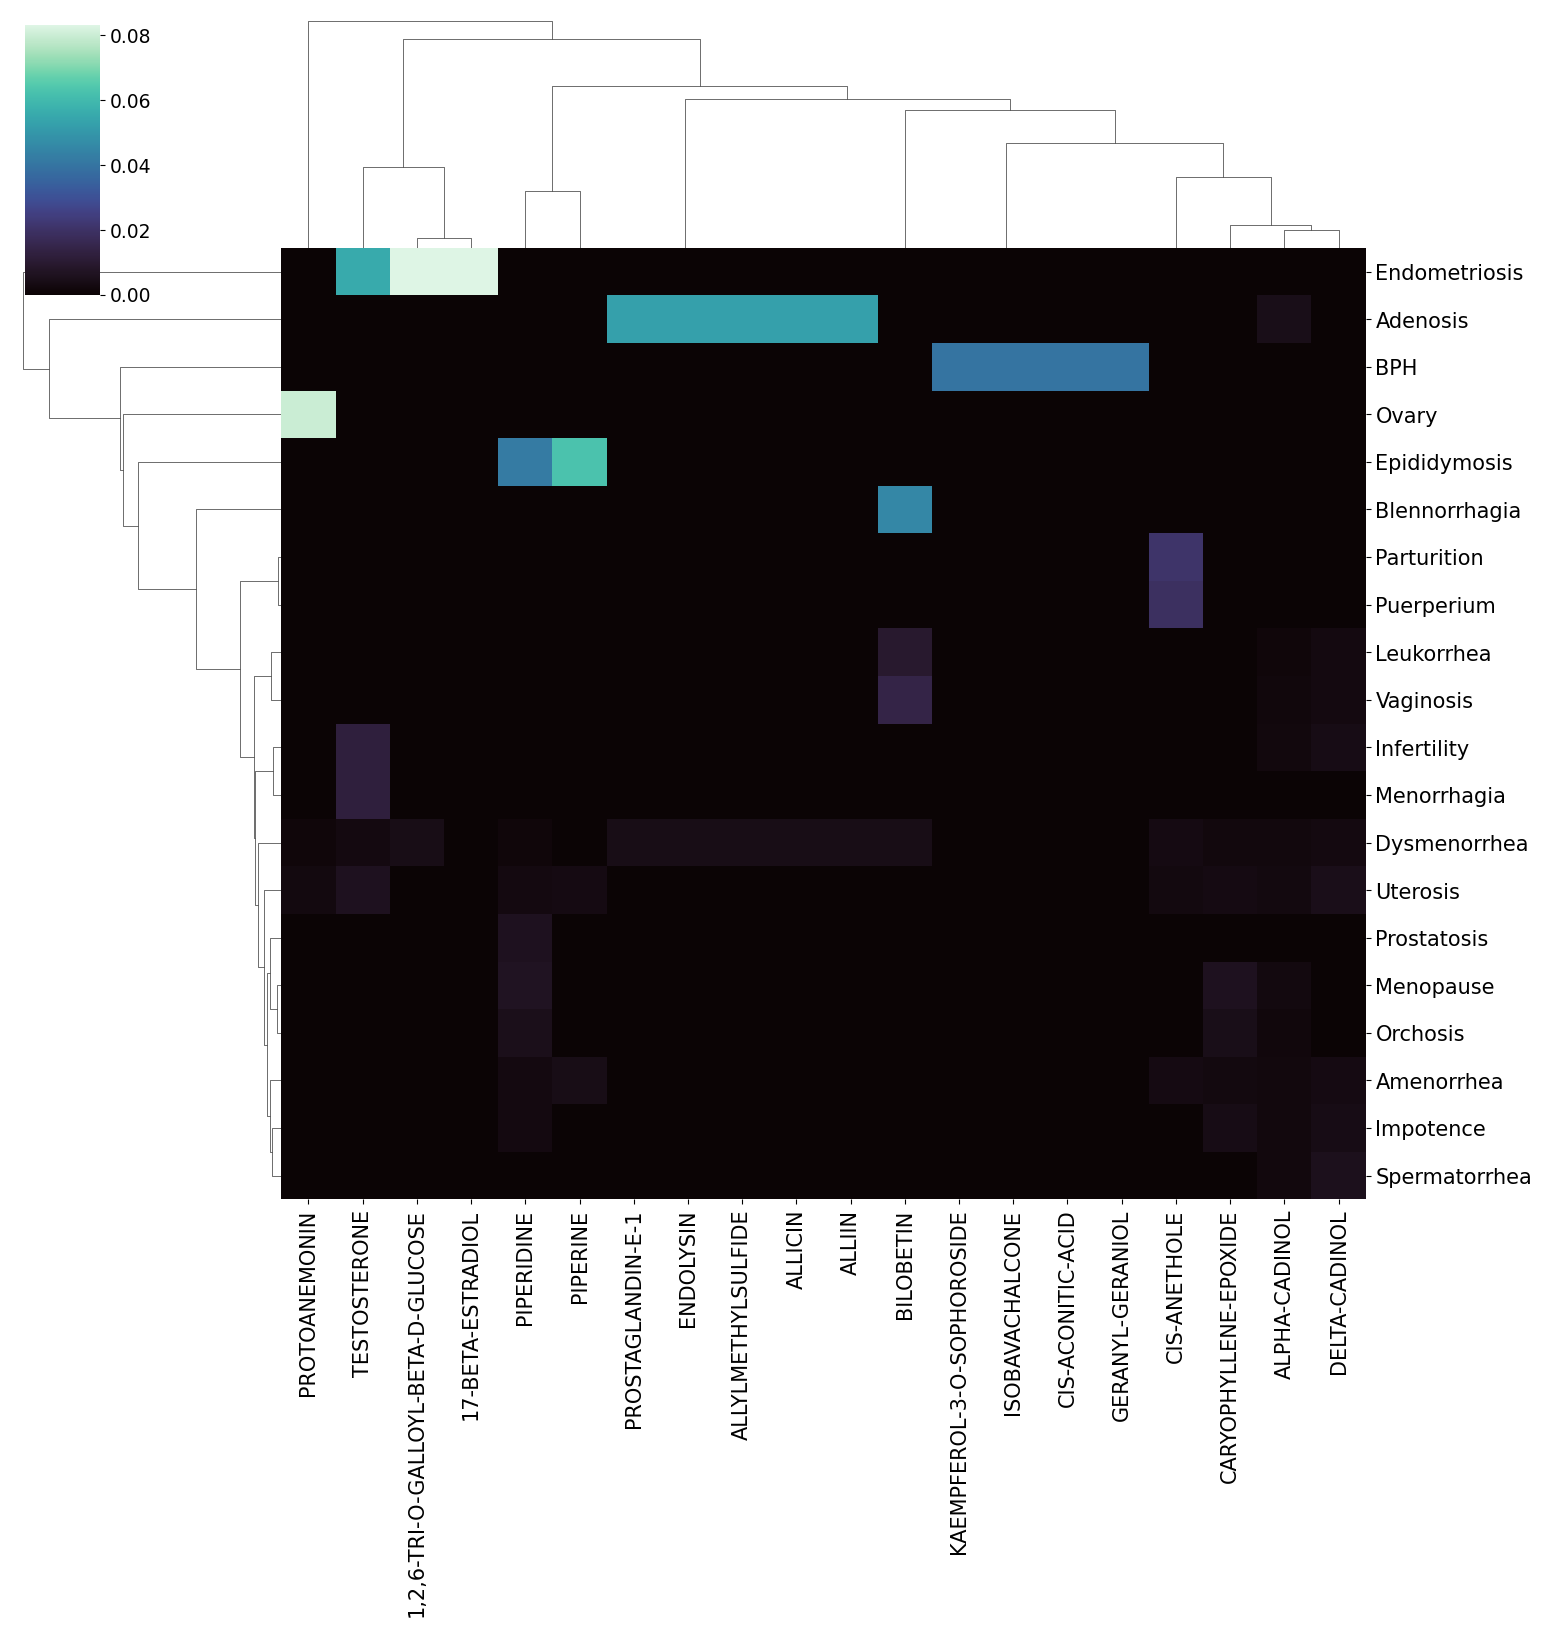

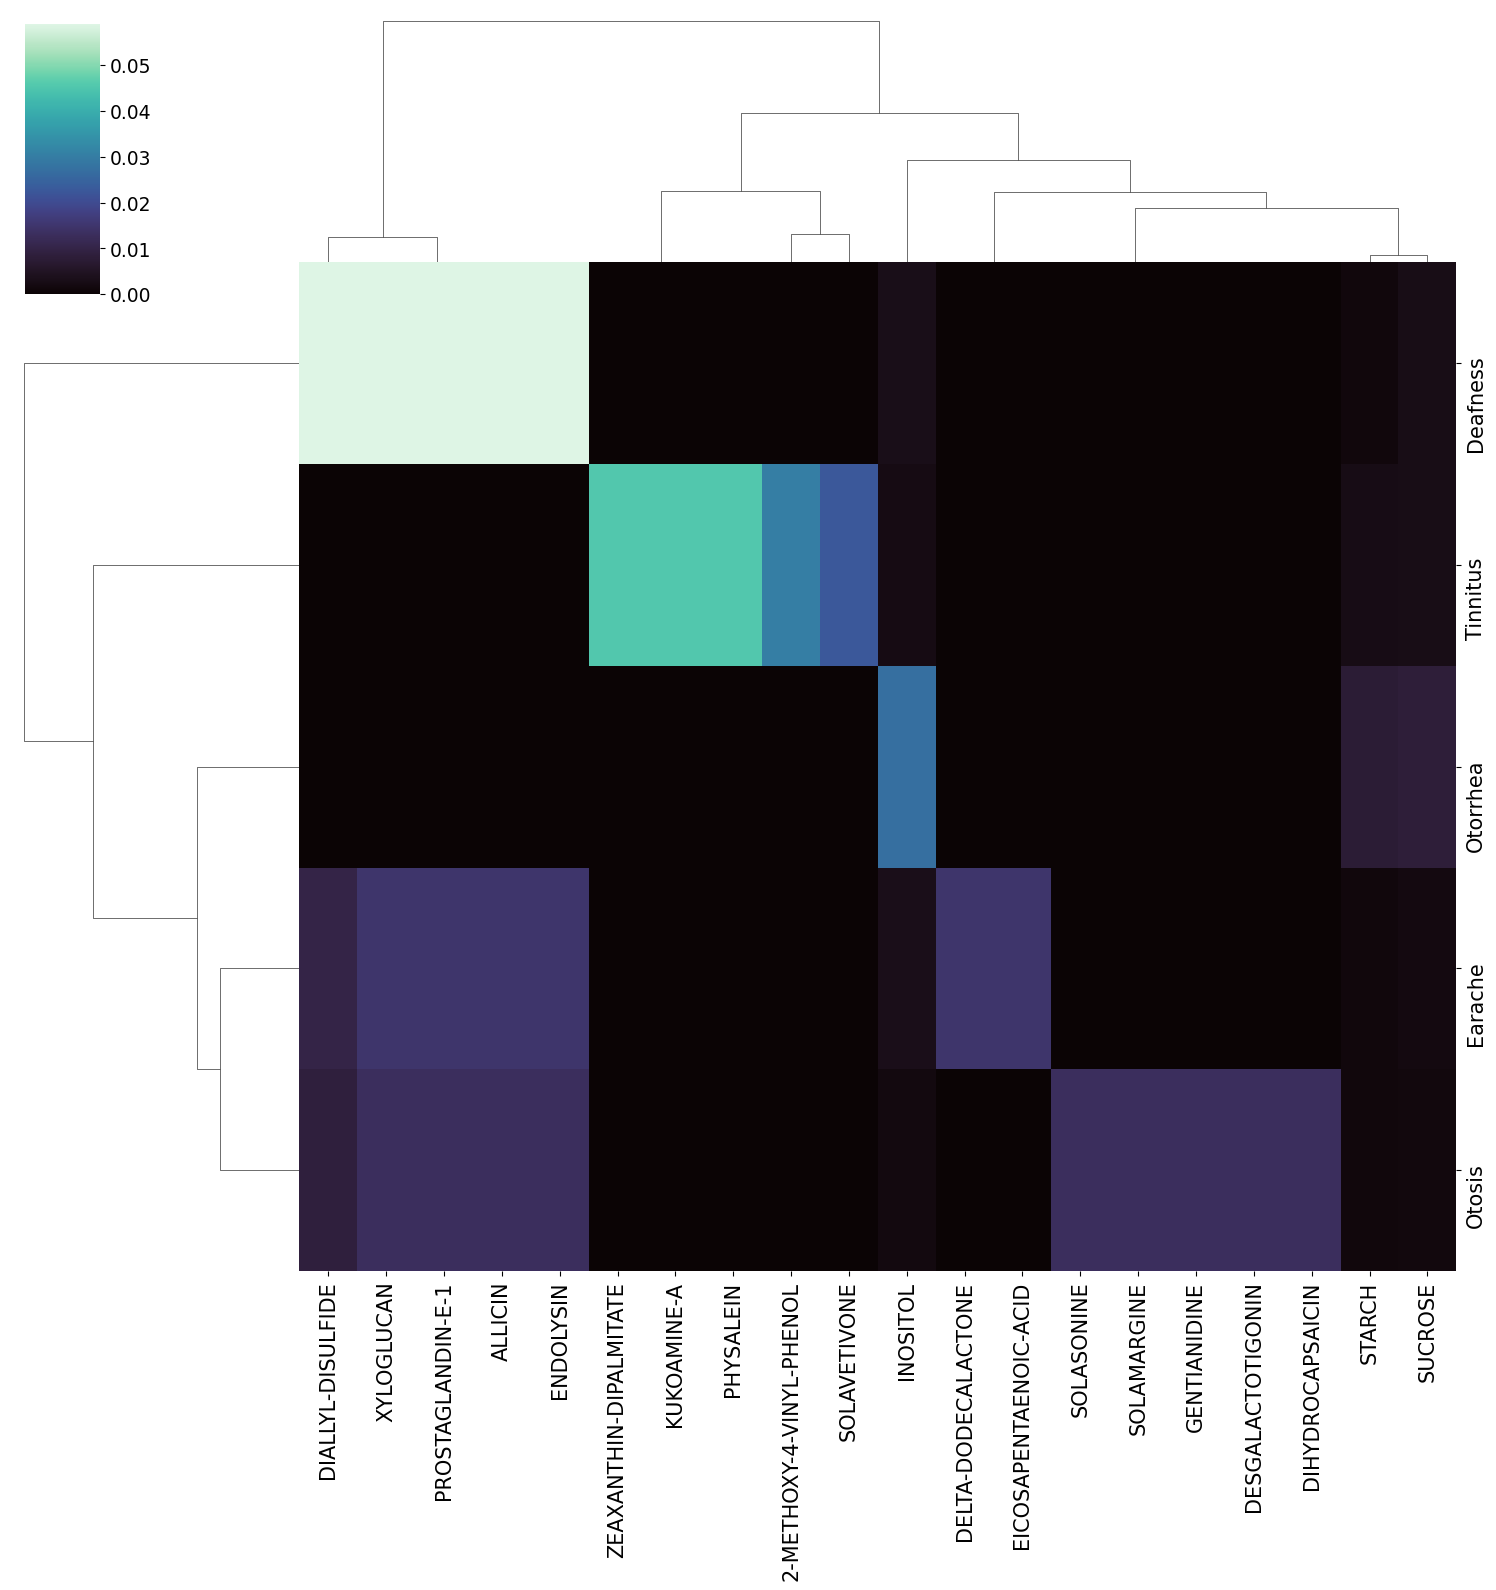

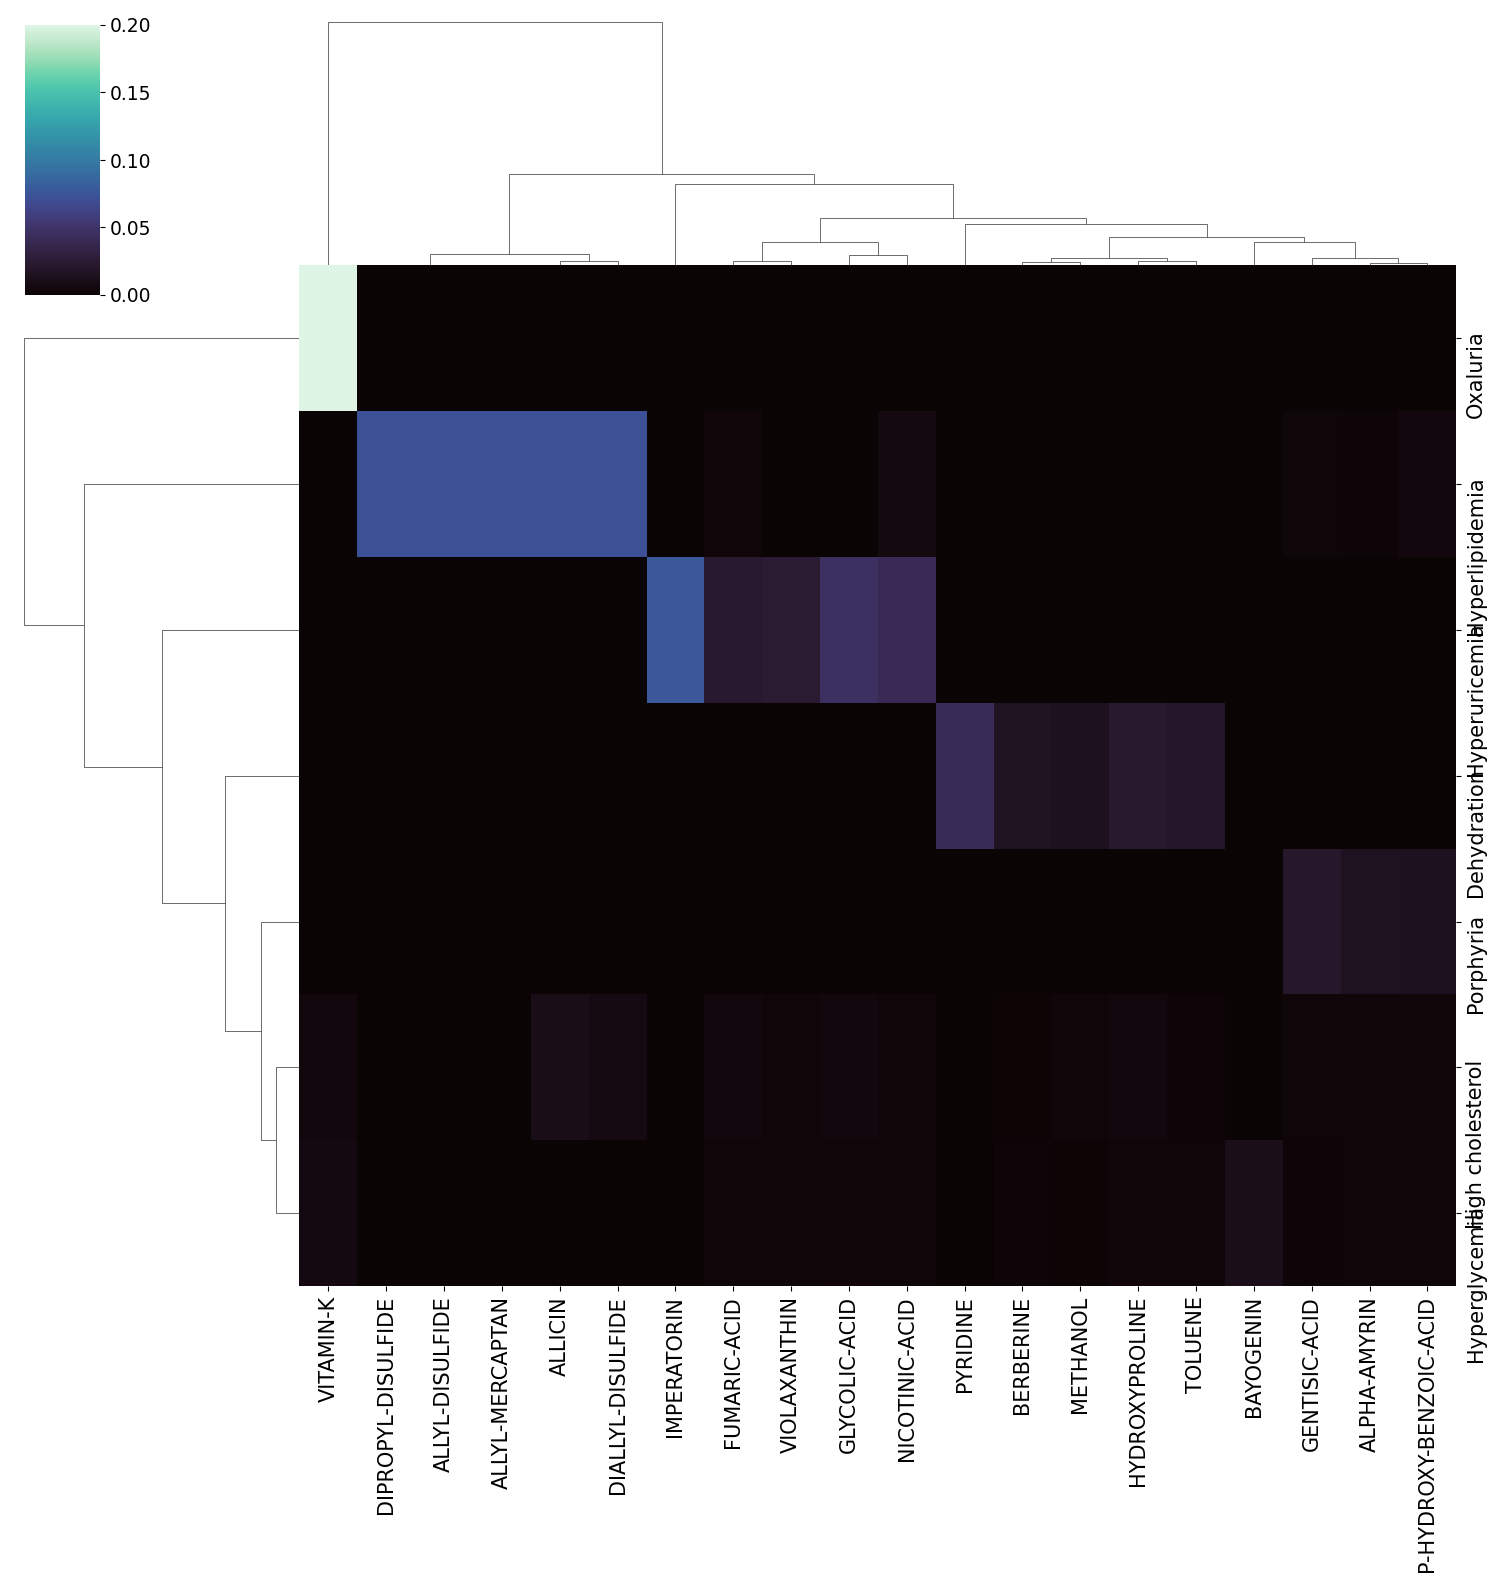

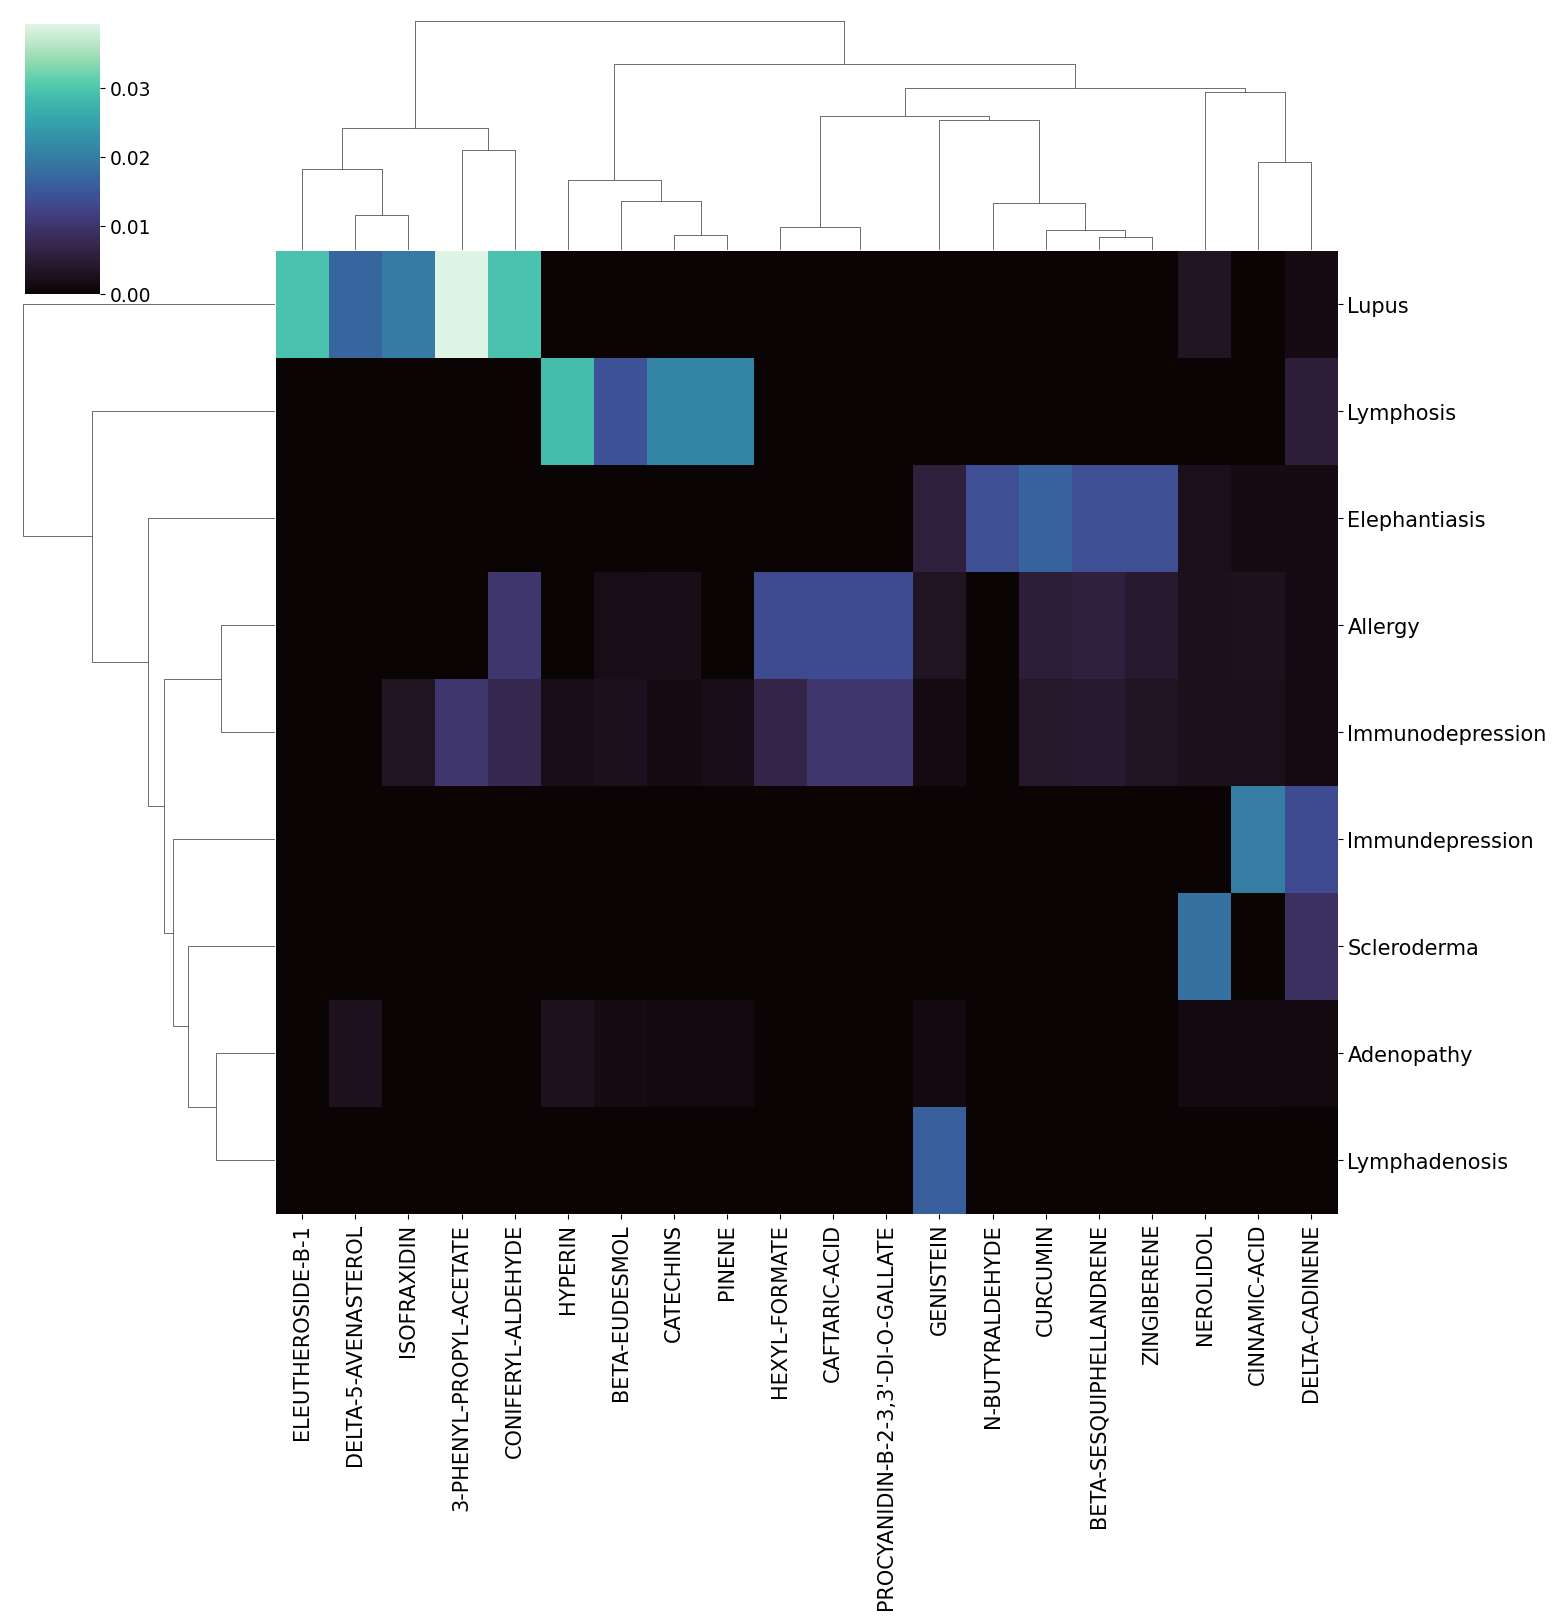

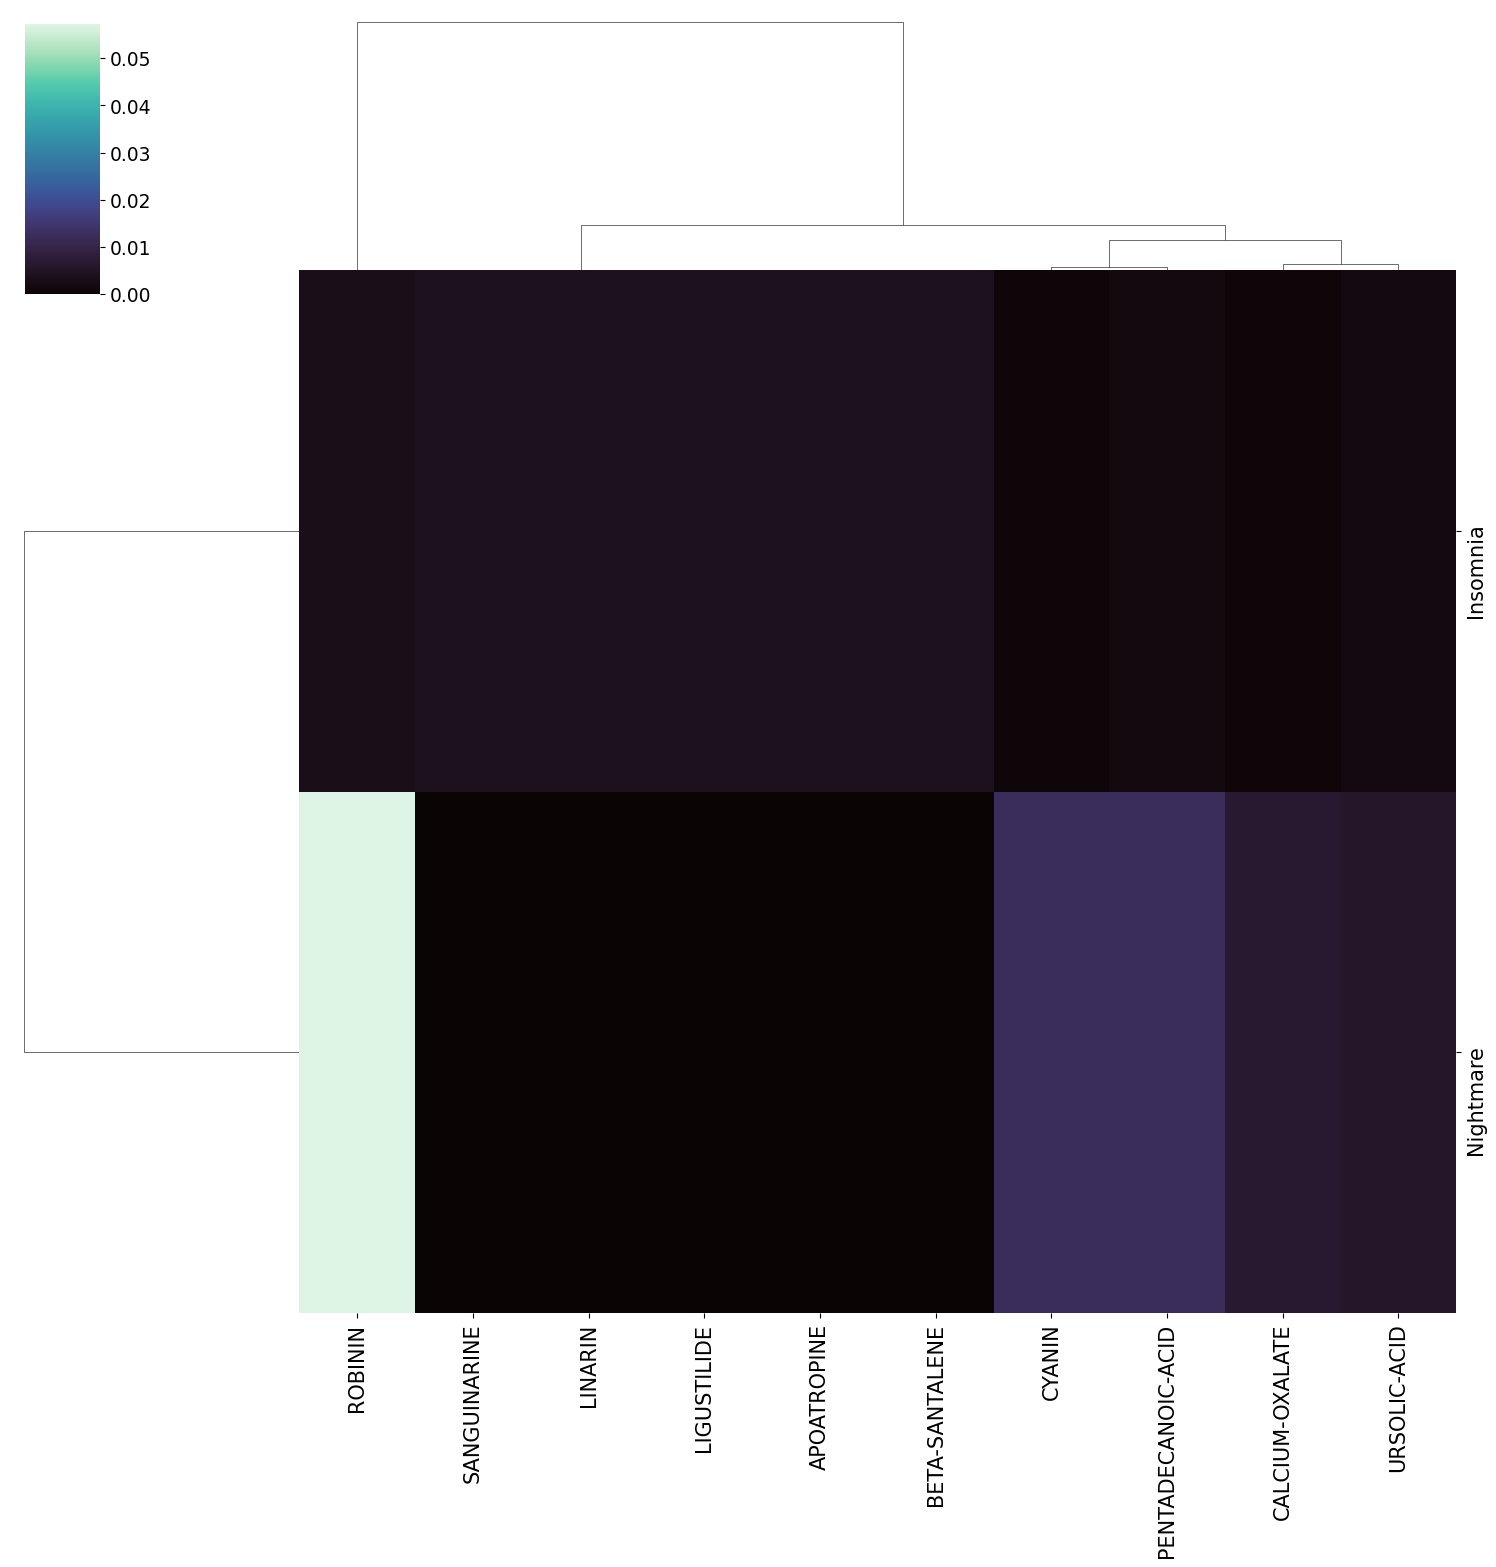

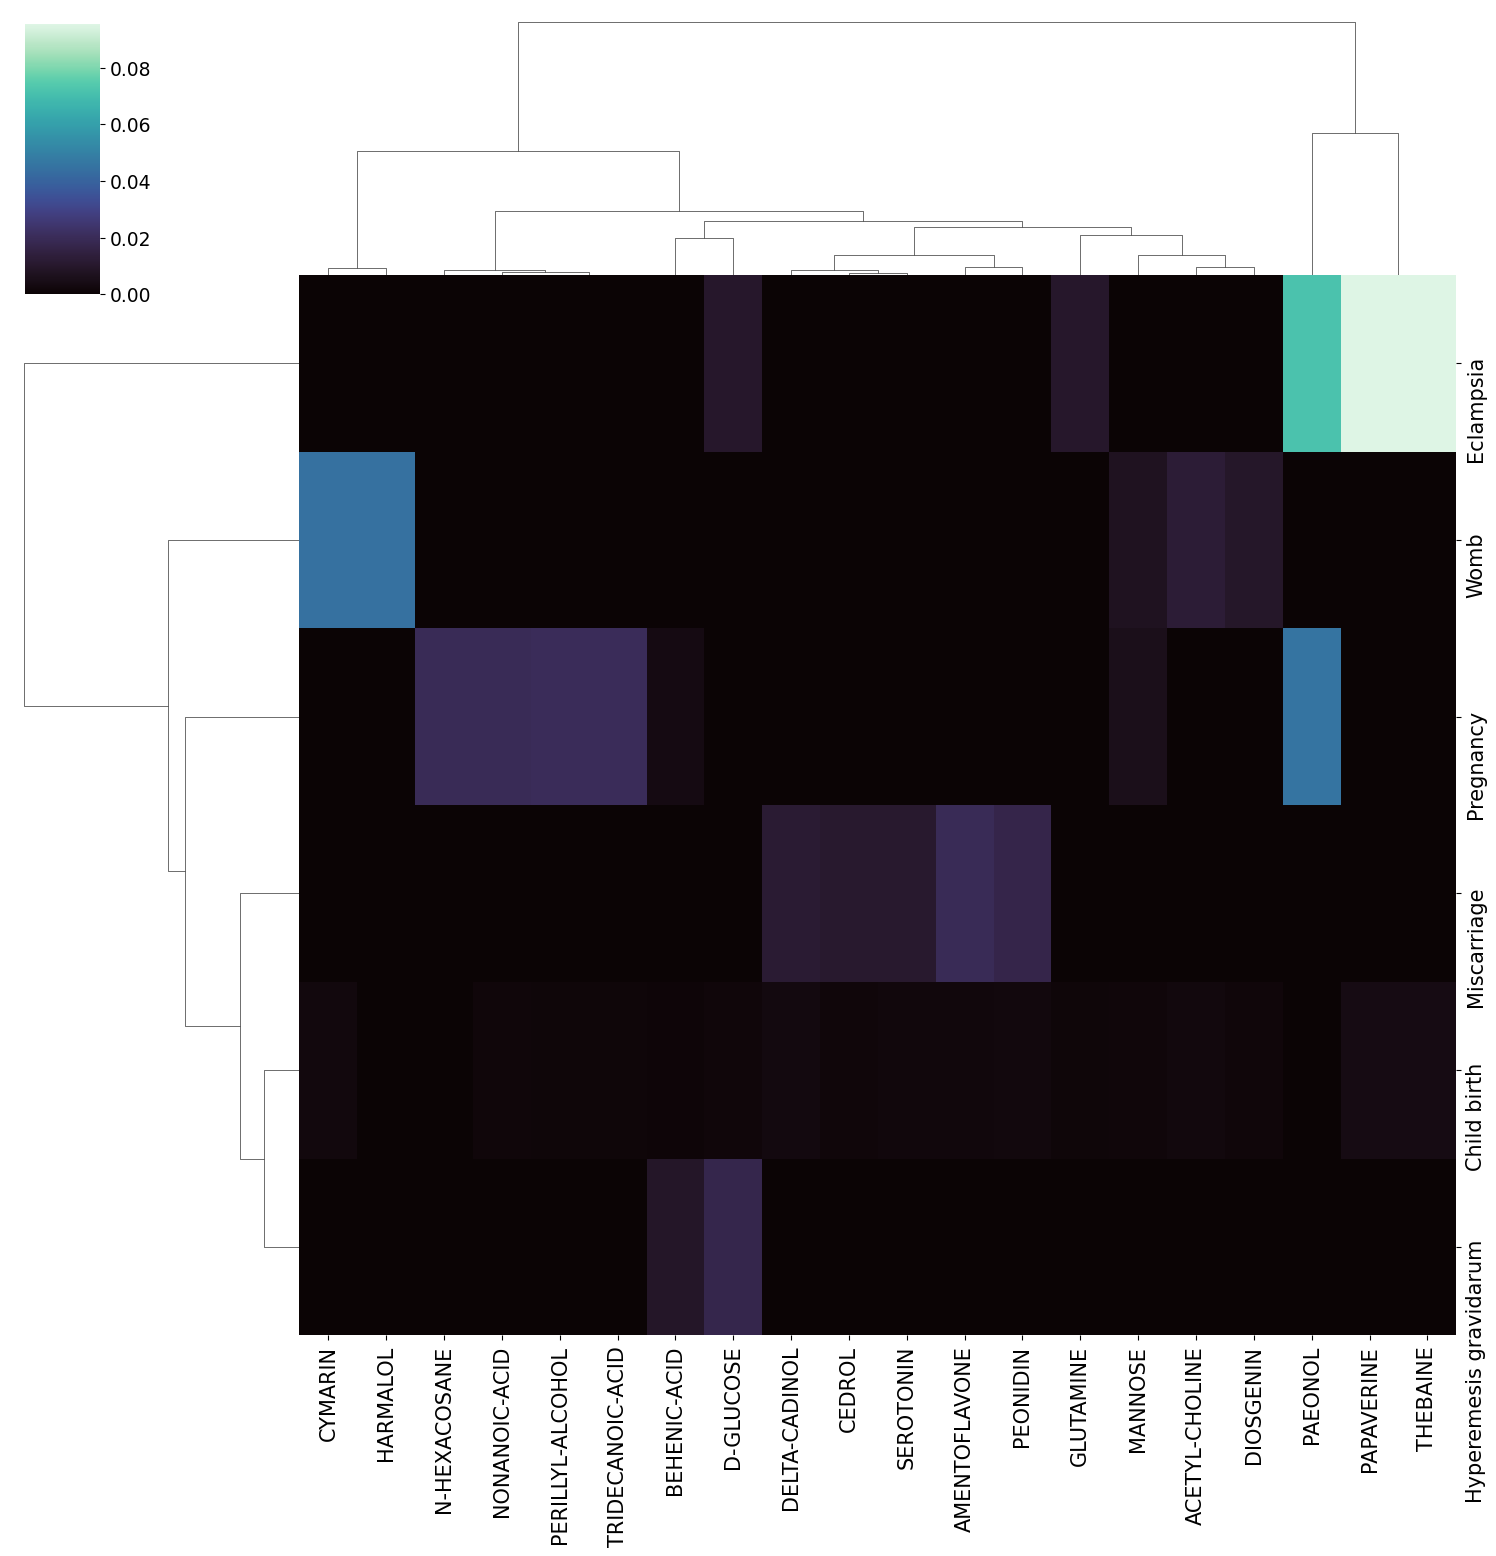

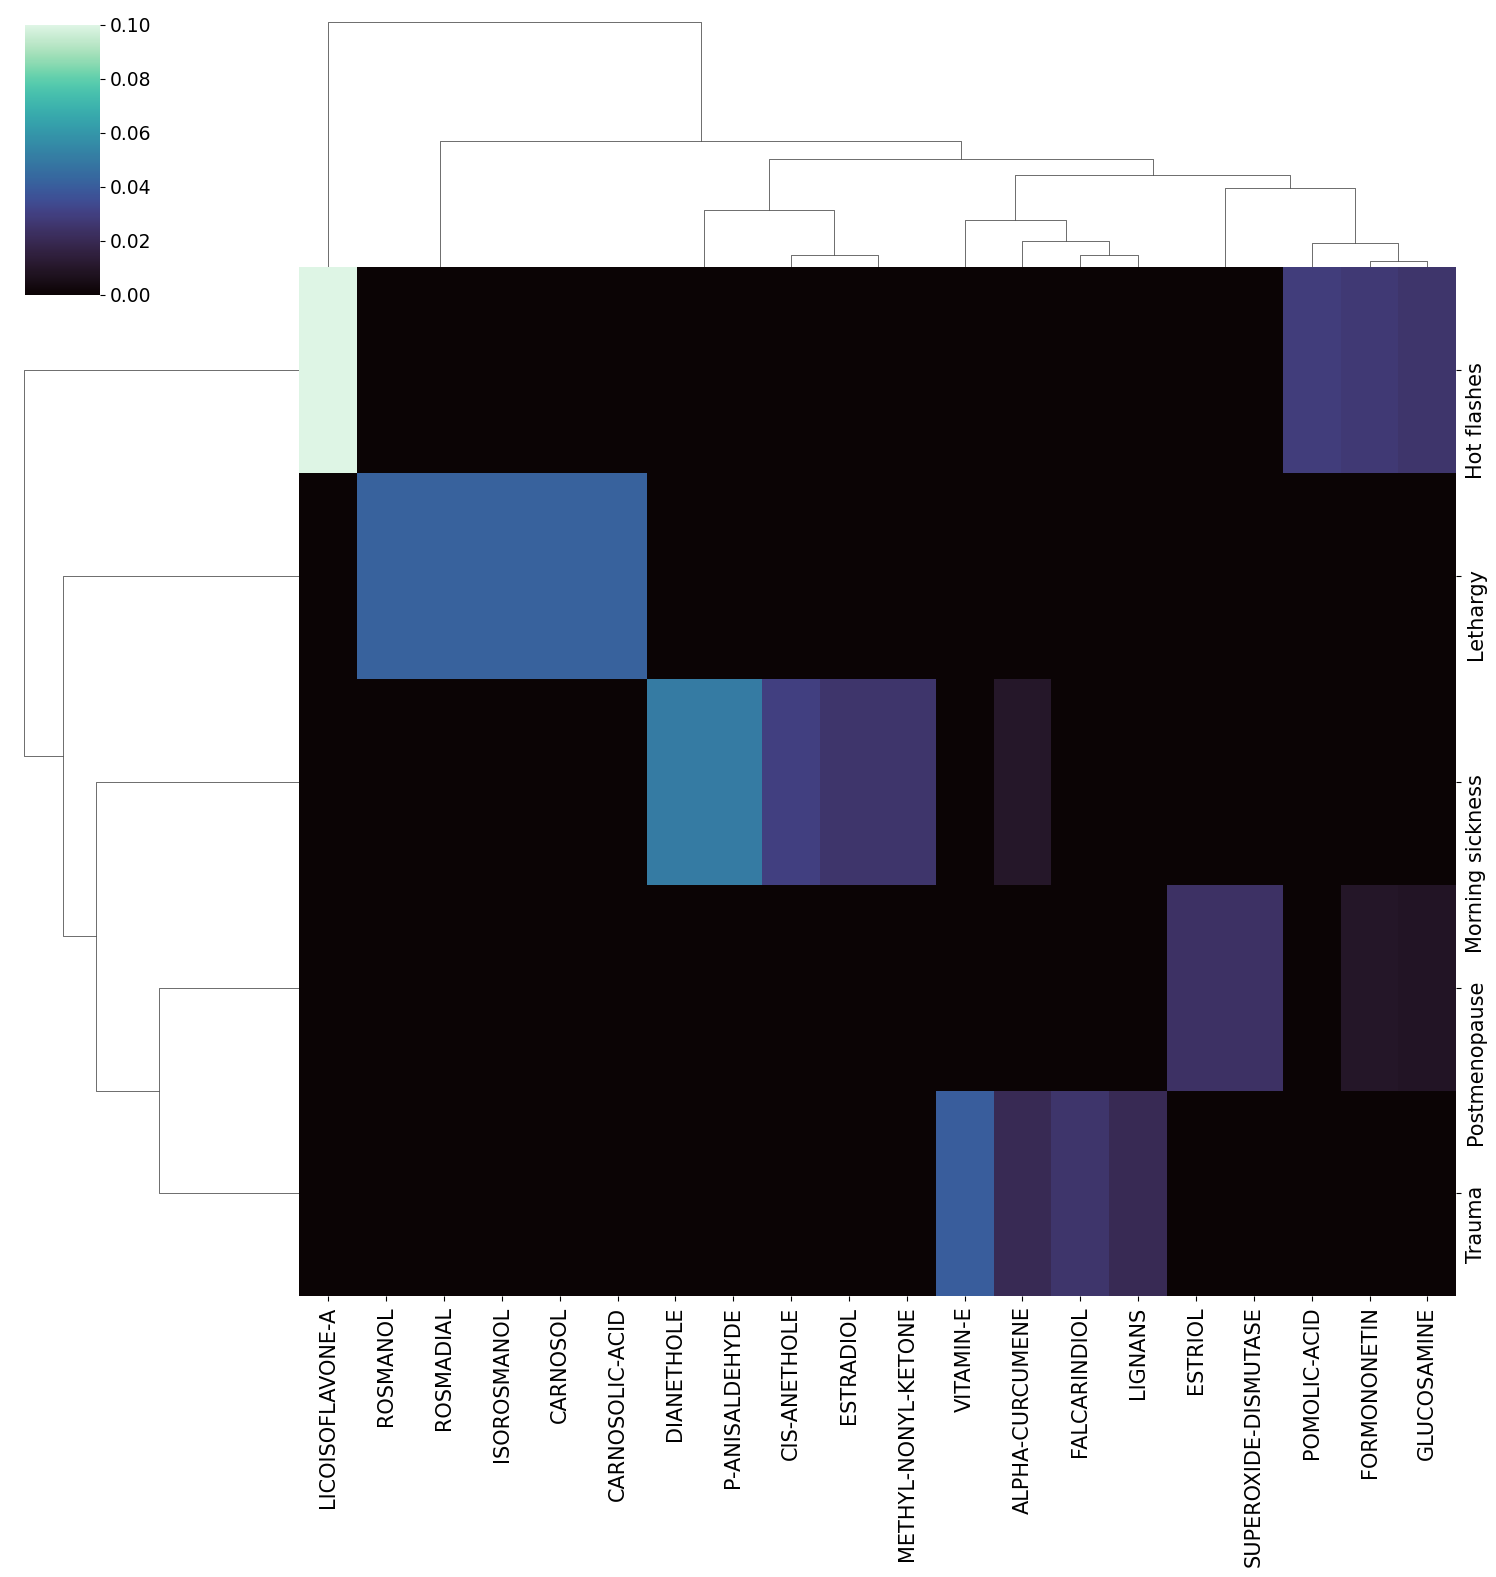

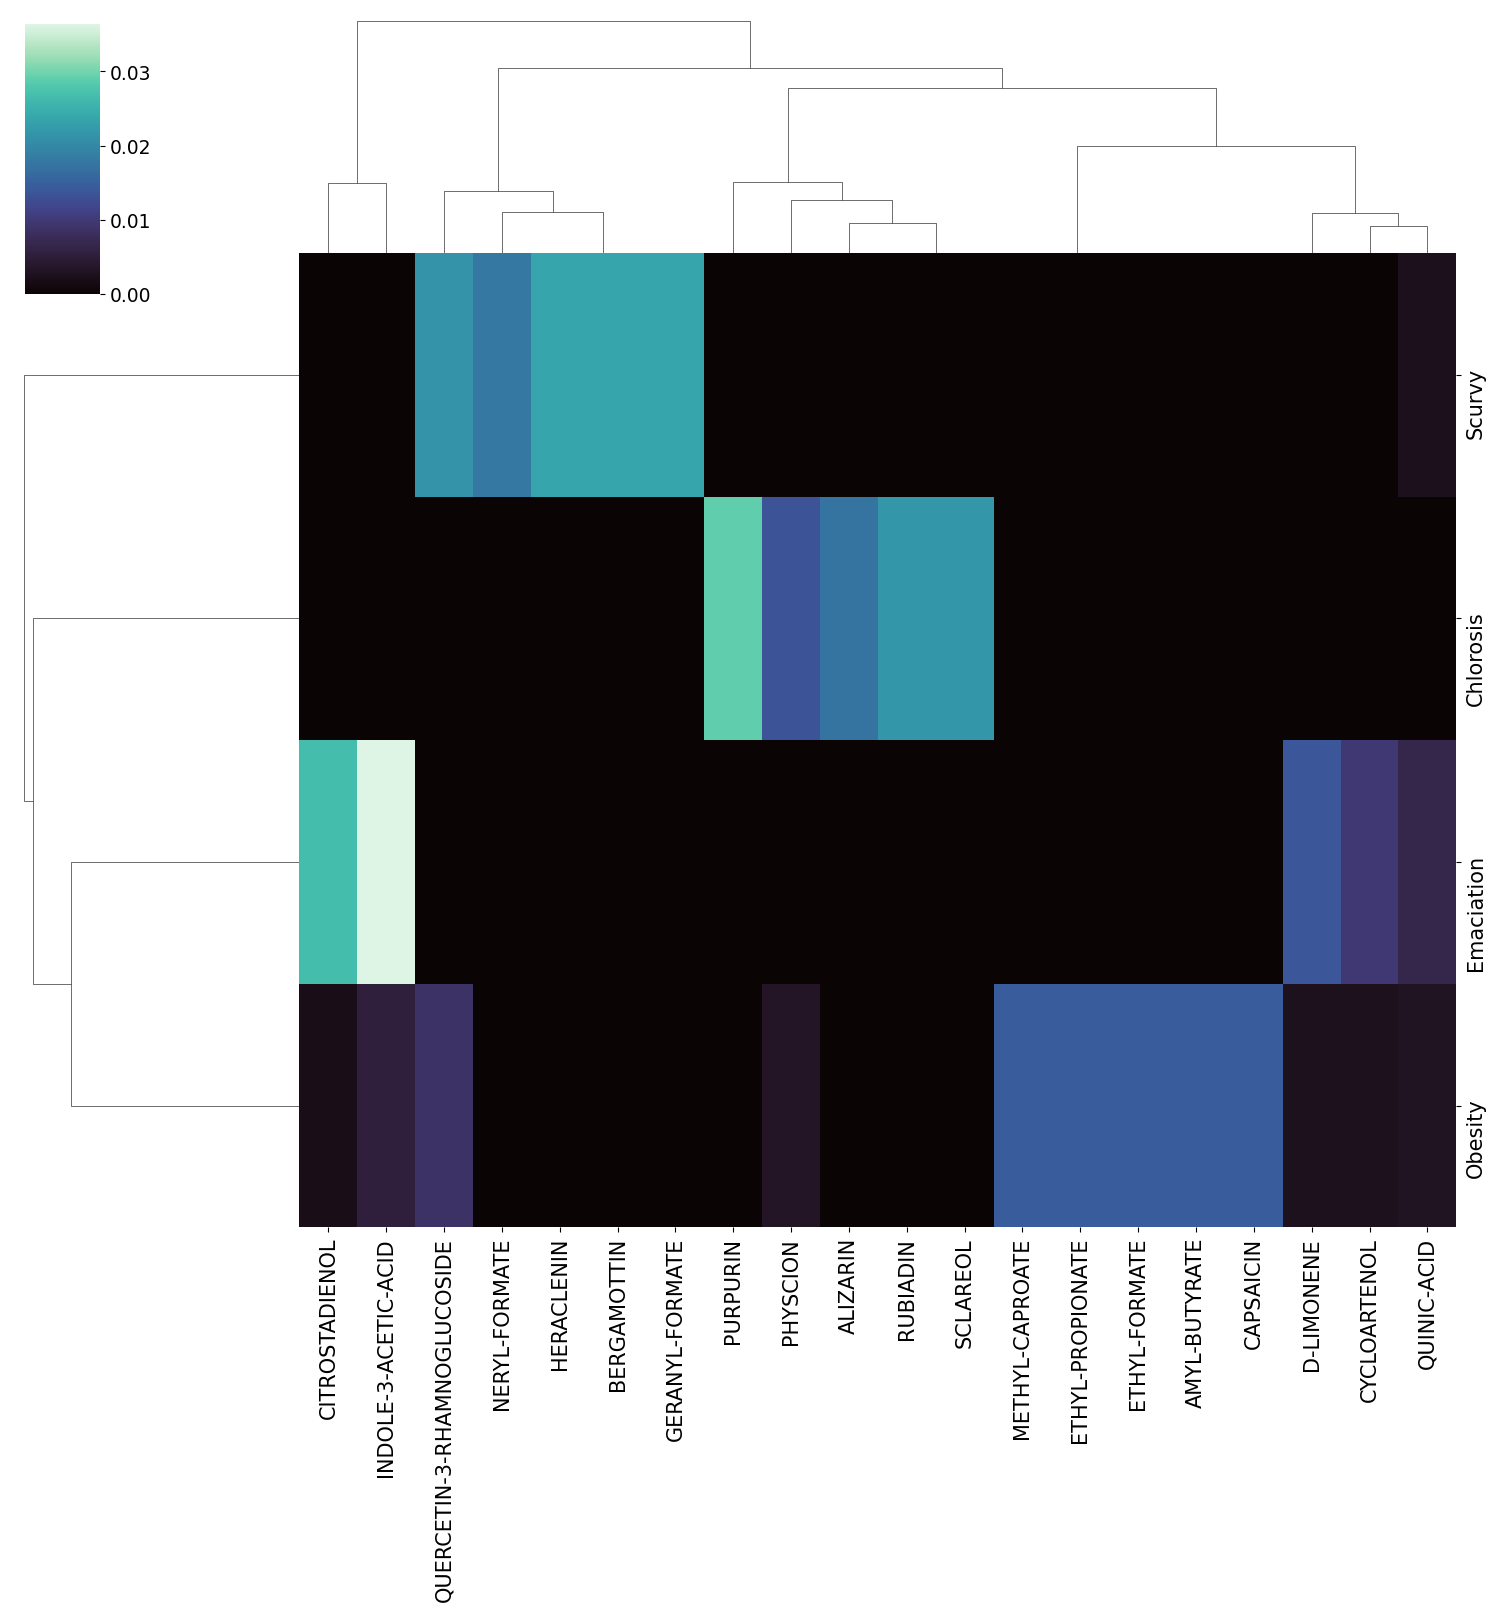

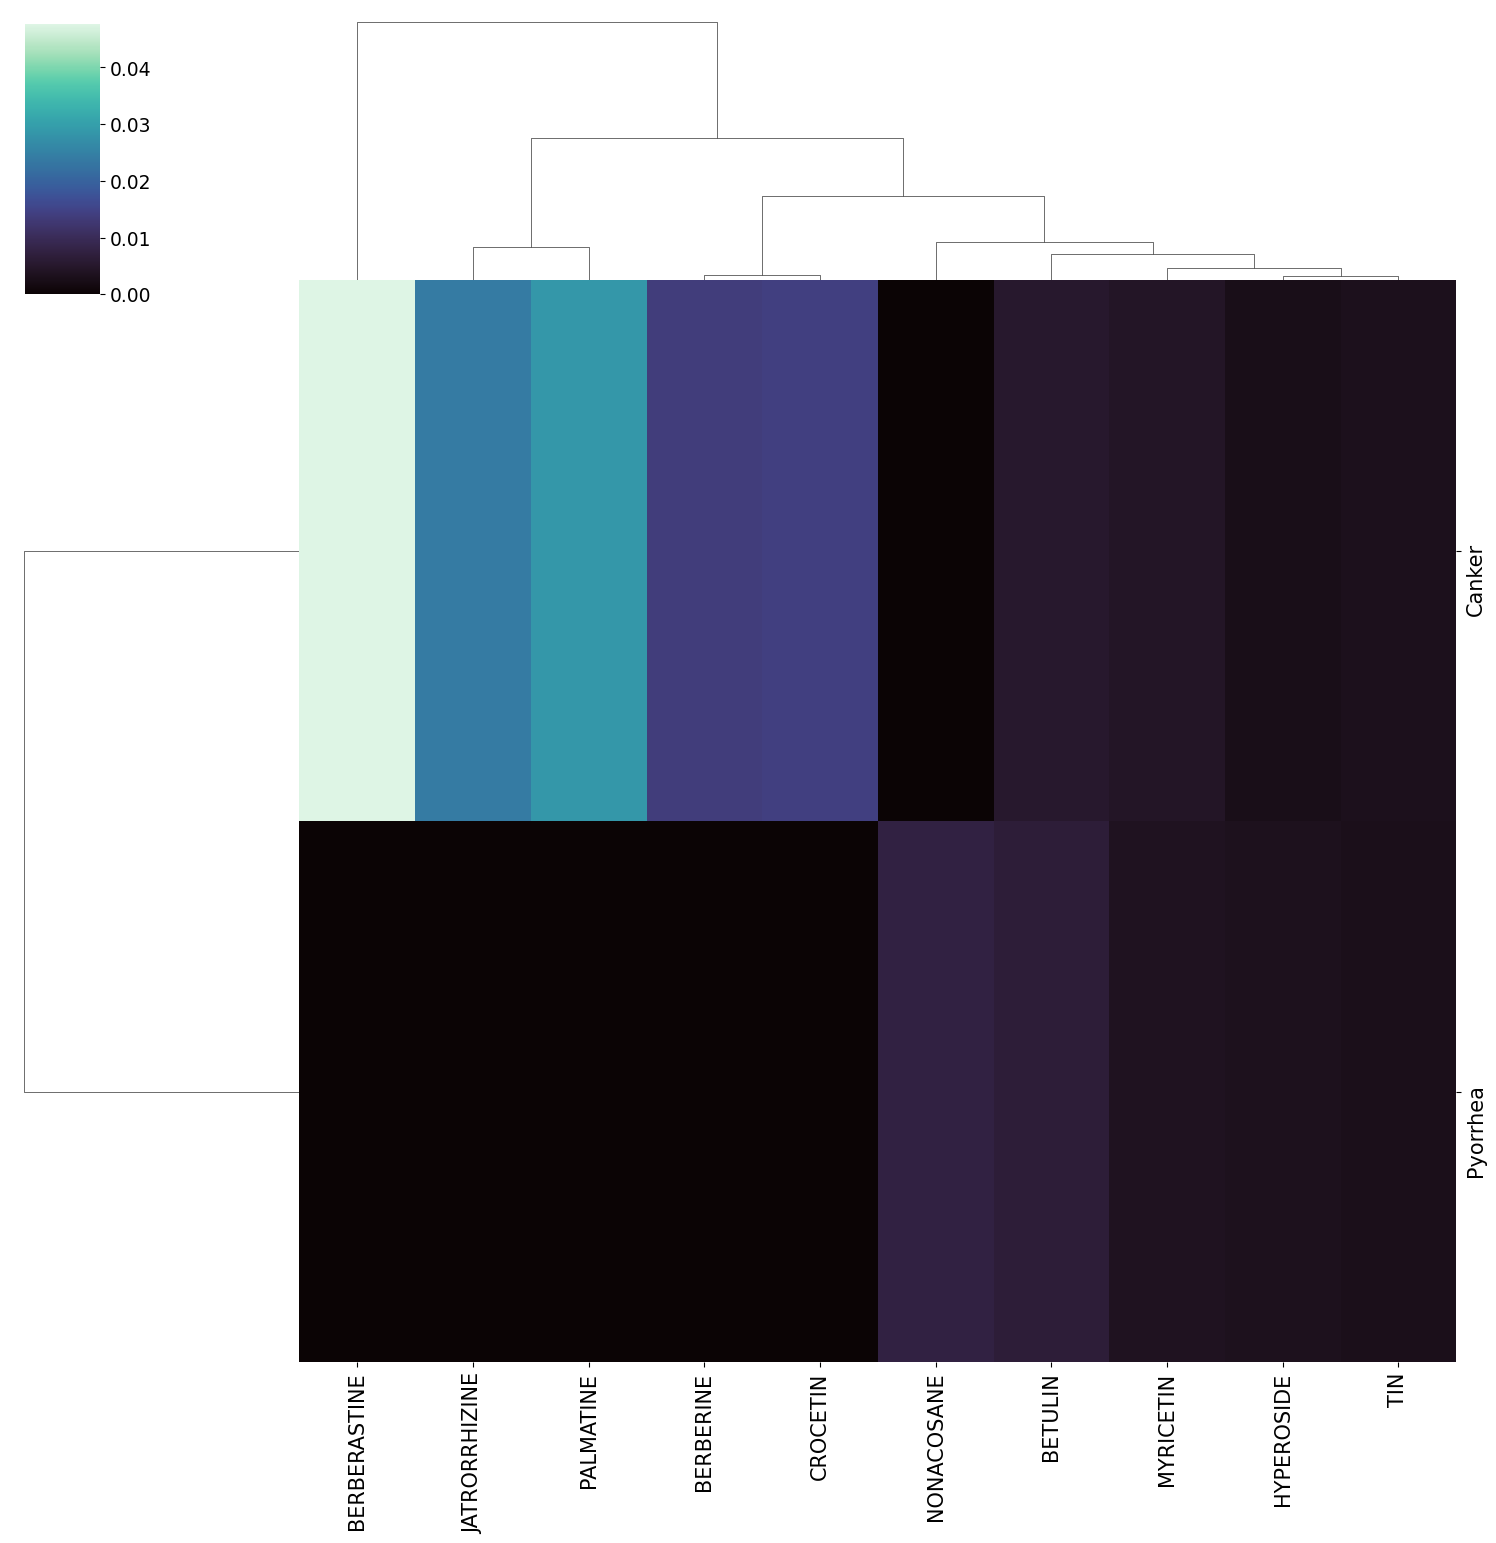

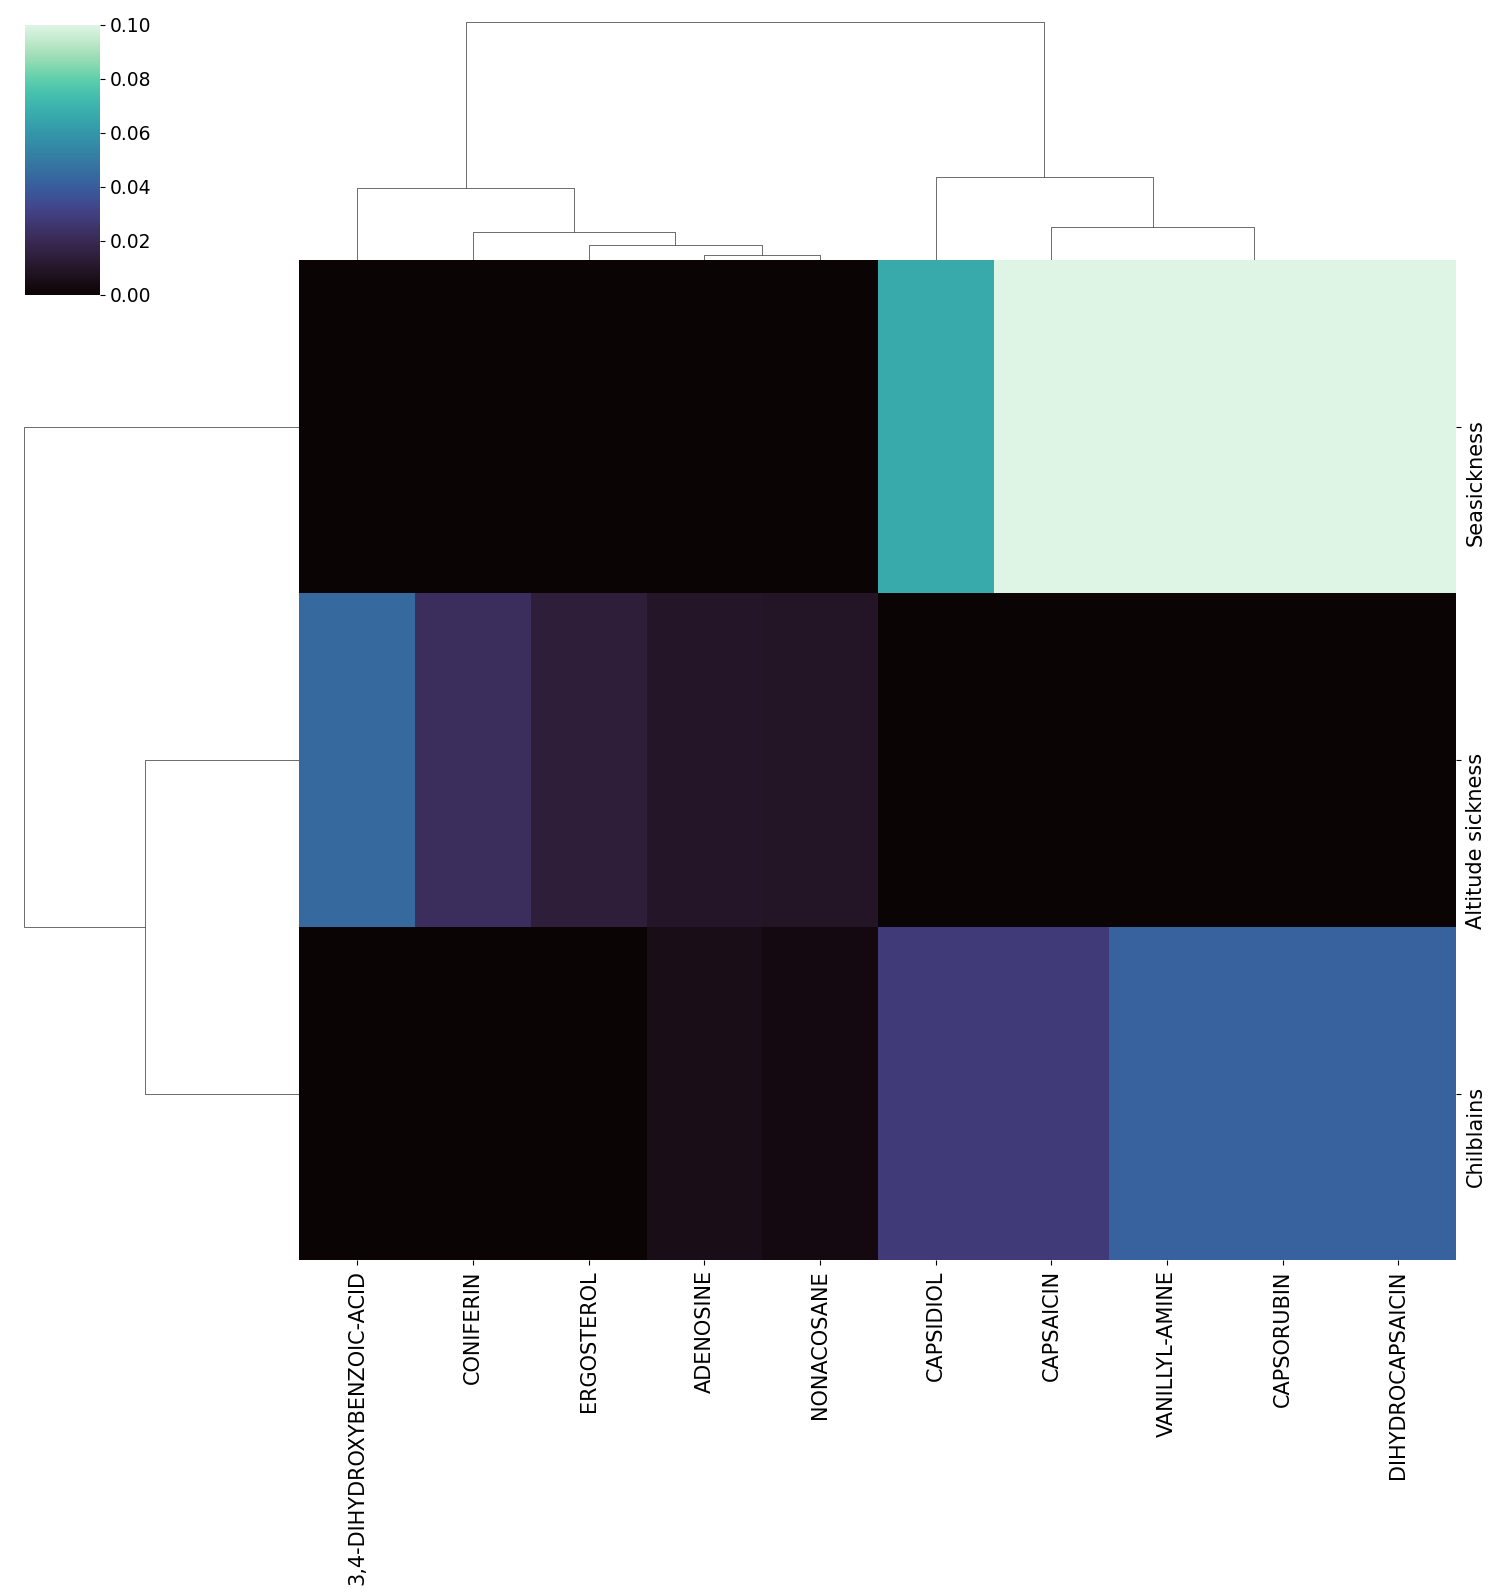

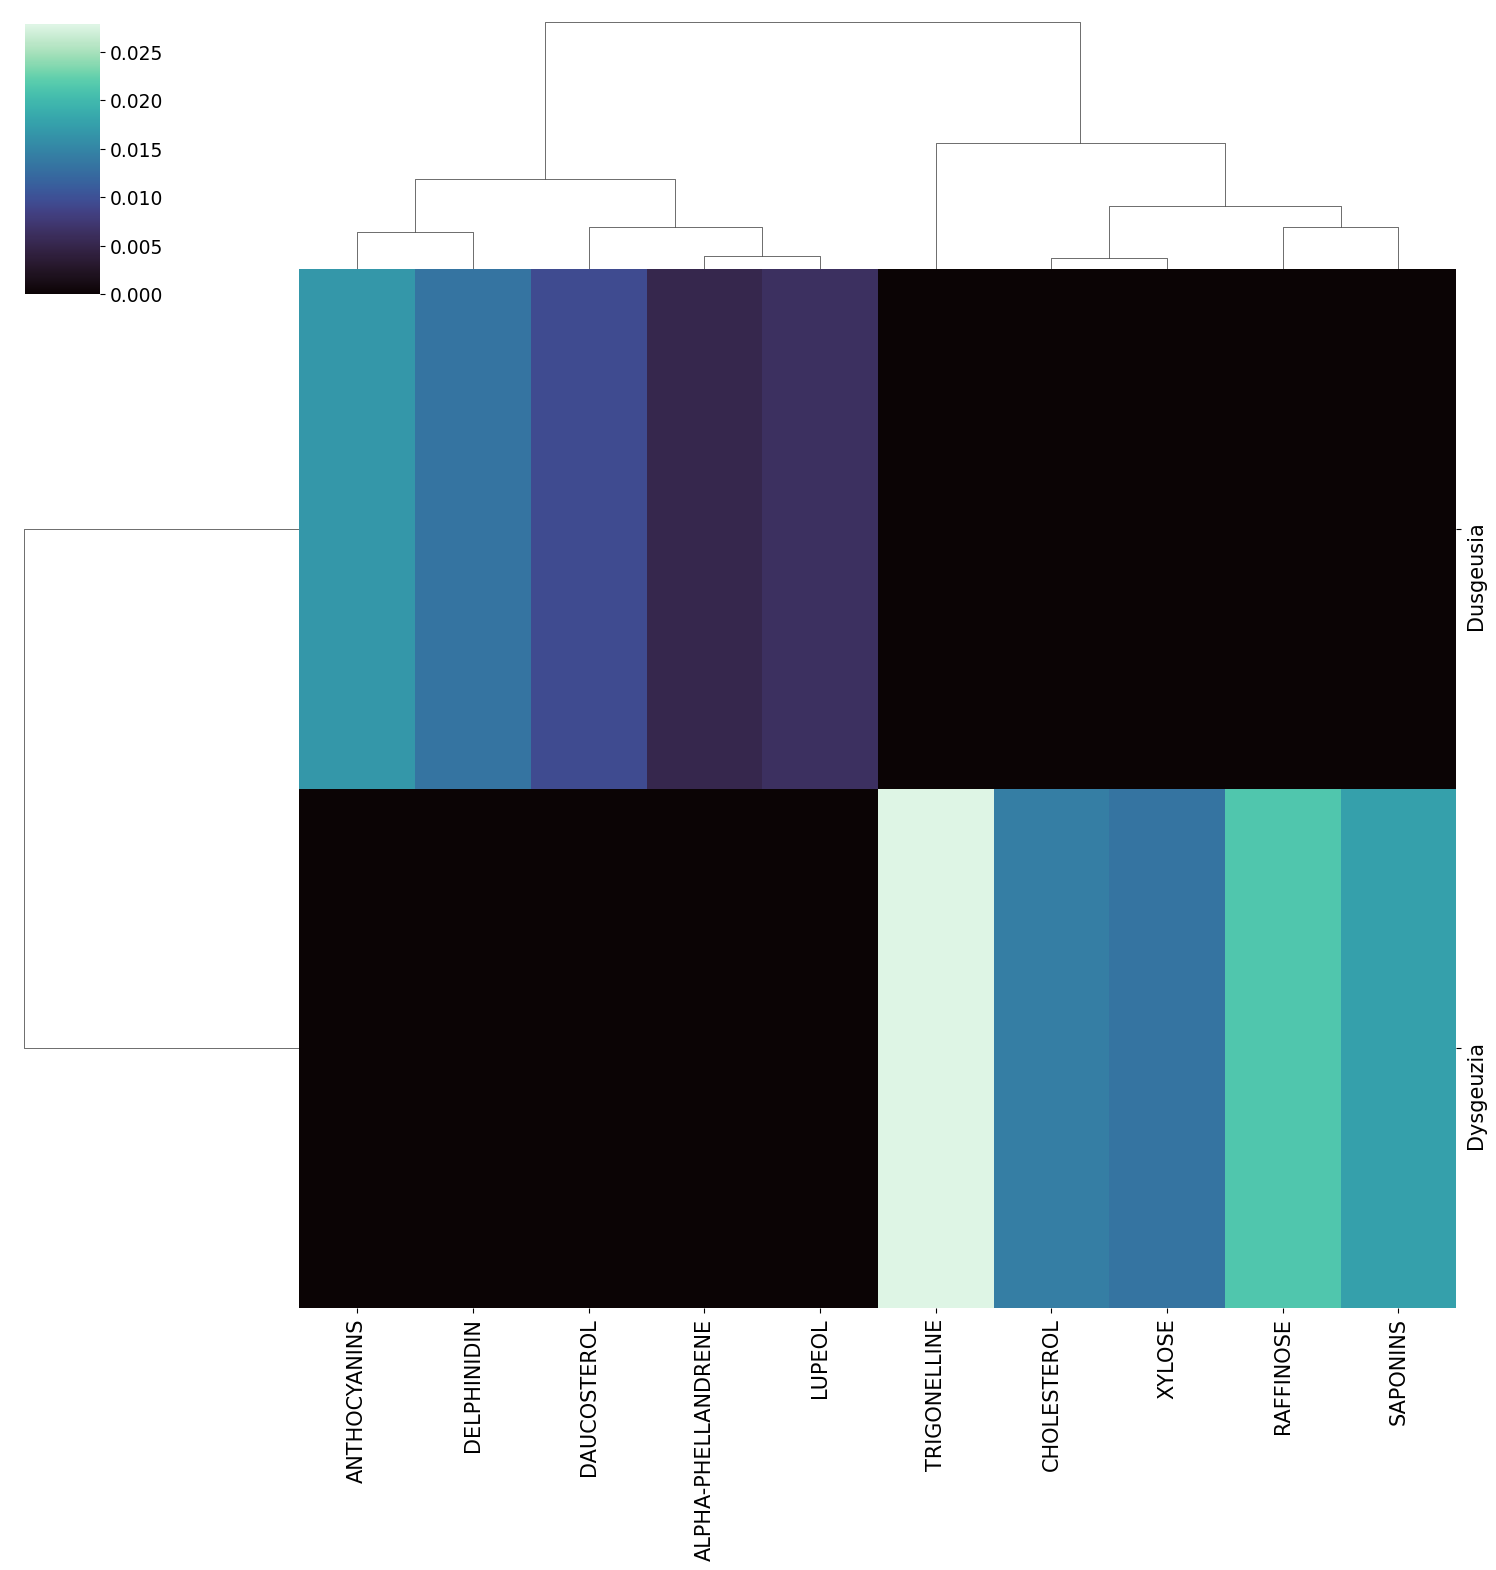

In [27]:
# heatmap by disease category
import operator
group2indic2spice = json2dict('Derived_Data/MinSetCover/group2indic2spice.json')
for group, i2s in group2indic2spice.items():
    print(group)
    indic2phyto2score_bygroup = {}
    phyto2indic2score_bygroup = {}
    df_indic2phyto2score = pd.DataFrame(indic2phyto2score_bygroup)
    indic2phyto_bygroup = {}
    for indic in i2s.keys():
        try:
            indic2phyto_bygroup[indic] = list(indic2phyto2score_all_normalized[indic].keys())
            phyto2score_bygroup = indic2phyto2score_all_normalized[indic]
            indic2phyto2score_bygroup[indic] = phyto2score_bygroup
            for phyto, score in phyto2score_bygroup.items():
                if phyto not in phyto2indic2score_bygroup:
                    phyto2indic2score_bygroup[phyto] = {}
                phyto2indic2score_bygroup[phyto][indic] = score
        except:
            continue
    #print(indic2phyto2score_bygroup)
    #phyto2indic_bygroup = reverse_dict(indic2phyto_bygroup)
    NUM_PHYTO = 20
    NUM_INDIC = 20
    TOP_K = 5
    
    phyto_select_bygroup, phyto2indic_select_bygroup = find_topspec_phyto(NUM_PHYTO, indic2phyto2score_bygroup, phyto2indic2score_bygroup, TOP_K)
    indic_select_bygroup = find_topspec_indic(NUM_INDIC, phyto2indic_select_bygroup)
    #fig = plt.figure()
    plot_indic2phyto_heatmap(indic2phyto2score_bygroup, indic_select_bygroup, phyto_select_bygroup)
    #plt.show()
    plt.autoscale()
    plt.savefig(result_folder + 'heatmap_plots/pairwise_filtered/' + group + '_phyto2indic_heatmap.png', bbox_inches="tight")
    #break

In [28]:
# Generate indic-phyto heatmap for subset of indic&phyto based on cuisine hndspices
cuis_spices = json2dict('Derived_Data\Minset_Indian_cuisine\cuisine_hndspices.json')
cuis_indic = []
cuis_phyto = []
for spice in cuis_spices:
    if spice == 'curryleaf':
        spice_new = 'Curry leaf'
    else:
        spice_new = spice.capitalize()
    cuis_indic.extend(spice2indic[spice_new])
    cuis_phyto.extend(spice2phyto_nonzero[spice_new])
indic_set = list(set(cuis_indic).intersection(set(list(indic2phyto2specificity_pairwise_filtered.keys()))))
phyto_set = list(set(cuis_phyto).intersection(set(list(phyto2indic2specificity_pairwise_filtered.keys()))))

<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
/var/folders/b4/v914vnr53d78831b3prx5h680000gn/T/ipykernel_12365/448229008.py:2: SyntaxWarning: invalid escape sequence '\M'
  cuis_spices = json2dict('Derived_Data\Minset_Indian_cuisine\cuisine_hndspices.json')
/var/folders/b4/v914vnr53d78831b3prx5h680000gn/T/ipykernel_12365/448229008.py:2: SyntaxWarning: invalid escape sequence '\M'
  cuis_spices = json2dict('Derived_Data\Minset_Indian_cuisine\cuisine_hndspices.json')


FileNotFoundError: [Errno 2] No such file or directory: 'Derived_Data\\Minset_Indian_cuisine\\cuisine_hndspices.json'

In [ ]:
# subset of indic2phyto2spec
df_indic2phyto2spec_cuis = pd.DataFrame(indic2phyto2specificity_pairwise_filtered).loc[phyto_set, indic_set]

In [ ]:
indic2phyto2spec_cuis = dict_sortbyscore(pd.DataFrame.to_dict(df_indic2phyto2spec_cuis))
phyto2indic2spec_cuis = dict_sortbyscore(pd.DataFrame.to_dict(df_indic2phyto2spec_cuis.T))
NUM_PHYTO = 30
TOP_K = 5
cuis_phyto_select, cuis_phyto2indic_select = find_topspec_phyto(NUM_PHYTO, indic2phyto2spec_cuis, phyto2indic2spec_cuis, TOP_K)
cuis_phyto_select

['ISOORIENTIN',
 'DEHYDROCOSTUS-LACTONE',
 'BENZYL-CINNAMATE',
 'PROCURCUMENOL',
 'SYNEPHRINE',
 'ZINGERONE',
 'GAMMA-LINOLENIC-ACID',
 'NARINGIN',
 'RHOIFOLIN',
 'CURCUMENOL',
 'ASTILBIN',
 'MYRTENAL',
 'NEROLIDIOL',
 'ISOAMYL-ACETATE',
 'ALLYL-PROPYL-DISULFIDE',
 'COPTISINE',
 'BETA-DAMASCENONE',
 '2,3-DIHYDROBENZOFURAN',
 'ISOCARYOPHYLLENE',
 'SOLANIDINE',
 'TRICIN',
 '2-UNDECANONE',
 'EPSILON-CAROTENE',
 'CINNAMYL-ALCOHOL',
 'ESTRADIOL',
 'HEDERAGENIN',
 'GLYCEROL',
 'PELARGONIDIN',
 'PROANTHOCYANIDINS',
 'CIS-ANETHOLE']

647
(20, 30)


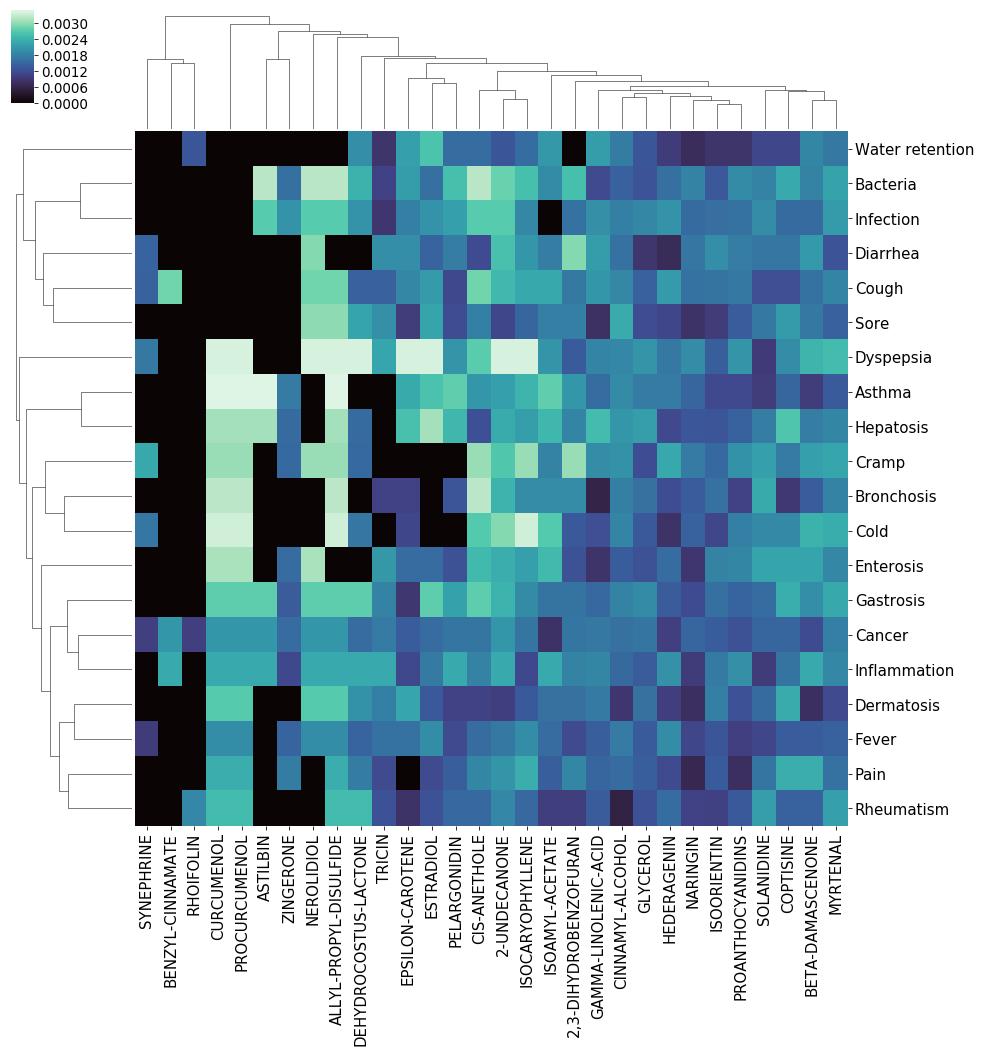

In [ ]:
cuis_indic_select = find_topspec_indic(NUM_INDIC, cuis_phyto2indic_select)
plot_indic2phyto_heatmap(indic2phyto2spec_cuis, cuis_indic_select, cuis_phyto_select)
plt.savefig(result_folder + 'heatmap_plots/pairwise_filtered/cuis_phyto2indic_heatmap.png', bbox_inches = "tight")

In [ ]:
num_indic_list = []
for phyto, indic2spec in phyto2indic2spec_cuis.items():
    #print(indic2spec)
    break
len(cuis_phyto_select)

30

In [ ]:
import math

def get_df_cytoscape(indic2phyto2spec, indic_select, phyto_select):
    indic_phyto_score = []
    for indic, phyto2spec in indic2phyto2spec.items():
        if indic in indic_select:
            #print(len(phyto2spec))
            for phyto, spec in phyto2spec.items():
                if phyto in phyto_select:
                    if math.isnan(spec):
                        spec_score = 0
                    else:
                        spec_score = spec * 10000
                    indic_phyto_score.append((indic, phyto, spec_score))
    indic2phyto_edge_df = []
    # preserve ones with high spec score
    indic_phyto_score_top = sorted(indic_phyto_score, key=lambda item: item[2], reverse=True)[:TOP_K_SCORE]
    indic_top = list(set([triple[0] for triple in indic_phyto_score_top]))
    phyto_top = list(set([triple[1] for triple in indic_phyto_score_top]))
    #print(indic_top)
    for indic in indic_top:
        for phyto in phyto_top:
            try:
                spec = indic2phyto2spec[indic][phyto]
            except:
                spec = 0
            if math.isnan(spec):
                spec_score = 0
            else:
                spec_score = spec * 10000
            indic2phyto_edge_df.append({'Source':phyto, 'Target':indic, 'Weight': int(spec_score)})    
    node_attr_df = []
    for indic in indic_top:
        node_attr_df.append({'Node_name': indic, 'nodetypes':'Target'})
    for phyto in phyto_top:
        node_attr_df.append({'Node_name': phyto, 'nodetypes':'Source'})

    indic2phyto_edge_df = pd.DataFrame(indic2phyto_edge_df)
    node_attr_df = pd.DataFrame(node_attr_df)
    return indic2phyto_edge_df, node_attr_df

# top 30
TOP_K_SCORE = 30
cuis_indic2phyto_edge_df,cuis_node_attr_df = get_df_cytoscape(indic2phyto2spec_cuis, cuis_indic_select, cuis_phyto_select)
cuis_indic2phyto_edge_df.to_excel(result_folder + "heatmap_plots/pairwise_filtered/cuis_indic2phyto_edge_cytoscape.xlsx")  
cuis_node_attr_df.to_excel(result_folder + "heatmap_plots/pairwise_filtered/cuis_node_attr_cytoscape.xlsx")  

# top 64
TOP_K_SCORE = 64
indic2phyto_edge_df, node_attr_df = get_df_cytoscape(indic2phyto2specificity_pairwise_filtered,indic_select, phyto_select)

indic2phyto_edge_df.to_excel(result_folder + "heatmap_plots/pairwise_filtered/indic2phyto_edge_cytoscape.xlsx")  
node_attr_df.to_excel(result_folder + "heatmap_plots/pairwise_filtered/node_attr_cytoscape.xlsx")  




In [ ]:
TOP_K

5

In [ ]:
# PICK (indic, phyto) with highest spec scores
import math
TOP_K_SCORE = 800
# specificity score (i,p) =  #spices relate to (i,p) /( #spices relate to i  x  #spices relate to p)
col_names = ['indication (i)','phytochemical (p)','specificity score','#spices relate to (i,p)','#spices relate to i','#spices relate to p']
                                                                                         
def find_top_spec_pair(indic2phyto2score, top_k=TOP_K_SCORE):
    indic_phyto_score = []
    for indic, phyto2score in indic2phyto2score.items():
        for phyto, spec in phyto2score.items():
            if not math.isnan(spec):
                a = indic2spice[indic] 
                indic_phyto_score.append({col_names[0]:indic, 
                                          col_names[1]:phyto, 
                                          col_names[2]:spec, 
                                          col_names[3]:indic2phyto2score_all[indic][phyto], 
                                          col_names[4]:len(indic2spice[indic]), 
                                          col_names[5]:phyto2spicecount[phyto]})
    indic_phyto_score_top = sorted(indic_phyto_score, key=lambda item: item['specificity score'], reverse=True)[:TOP_K_SCORE]
    return indic_phyto_score_top

print(f'(indic i,   phyto p,   specificity score,  #spices relate to (i,p),   #spices relate to i,   #spices relate to p)')
#find_top_spec_pair(indic2phyto2specificity_pairwise_filtered, top_k=30)
top_spec_df_cuis = pd.DataFrame(find_top_spec_pair(indic2phyto2spec_cuis,top_k=TOP_K_SCORE),columns=col_names)
top_spec_df_cuis.to_excel(result_folder+'top'+str(TOP_K_SCORE)+'specificity_cuis.xlsx')

top_spec_df = pd.DataFrame(find_top_spec_pair(indic2phyto2specificity_pairwise_filtered,top_k=TOP_K_SCORE),columns=col_names)
top_spec_df.to_excel(result_folder+'top'+str(TOP_K_SCORE)+'specificity.xlsx')

(indic i,   phyto p,   specificity score,  #spices relate to (i,p),   #spices relate to i,   #spices relate to p)


In [ ]:
phyto_select

['VANILLYL-AMINE',
 'CAPSORUBIN',
 'DIHYDROCAPSAICIN',
 'METHYL-NONANOATE',
 'CAPSIDIOL',
 'ALLYLMETHYLSULFIDE',
 'ALLYL-METHYL-DISULFIDE',
 'ALLYL-PROPYL-DISULFIDE',
 'ENDOLYSIN',
 'ALLICIN',
 'CUCURBIC-ACID',
 '7BETA,12ALPHA-DIHYDROXYKAURENOLIDE',
 'PERIPLOCYMARIN',
 'HYDRASTINE',
 'DIANETHOLE',
 'PTEROSTILBENE',
 'EPSILON-VINIFERIN',
 'GITOXIN',
 'DIGITOXIN',
 'CAFFEOYLTARTARIC-ACID',
 'INDOLE-3-CARBINOL',
 'SULFORAPHANE',
 'FORMONONETIN',
 'CUCURBITIN',
 'TETRAMETHYL-PYRAZINE',
 'CYMAROL',
 'STROPHANTHIDIN',
 'GLUCOSAMINE',
 'P-ANISALDEHYDE',
 '3-PHENYL-PROPYL-ACETATE',
 'CUCURBITACIN-D',
 'O-METHOXYCINNAMALDEHYDE',
 'OLEANOLIC-ACID-METHYL-ESTER',
 'ASTILBIN',
 'PHENETHYL-ISOTHIOCYANATE',
 'VIOLIN',
 'GALANTHAMINE',
 'APOATROPINE',
 'TRANS-ISOASARONE',
 'CYANIDIN-3-O-BETA-D-GLUCOSIDE']